In [65]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [3]:
import tensorflow as tf

from sklearn.metrics import classification_report

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
import pickle

Data preparation from pre-processed csv file

In [ ]:
# read in dataset workbook (multiple captures have been combined into one notebook prior to processing)
processed_data = pd.read_csv('clean_data.csv', index_col=0)

In [5]:
processed_data

destination_port  flow_duration  total_fwd_packets  \
0                   54865              3                  2   
1                   55054            109                  1   
2                   55055             52                  1   
3                   46236             34                  1   
4                   54863              3                  2   
...                   ...            ...                ...   
2827151                53          32215                  4   
2827152                53            324                  2   
2827153             58030             82                  2   
2827154                53        1048635                  6   
2827155                53          94939                  4   

         total_backward_packets  total_length_of_fwd_packets  \
0                             0                           12   
1                             1                            6   
2                             1                            6   
3                             1                            6   
4                             0                           12   
...                         ...                          ...   
2827151                       2                          112   
2827152                       2                           84   
2827153                       1                           31   
2827154                       2                          192   
2827155                       2                          188   

         total_length_of_bwd_packets  fwd_packet_length_max  \
0                                  0                      6   
1                                  6                      6   
2                                  6                      6   
3                                  6                      6   
4                                  0                      6   
...                              ...                    ...   
2827151                          152                     28   
2827152                          362                     42   
2827153                            6                     31   
2827154                          256                     32   
2827155                          226                     47   

         fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
0                            6                     6.0                0.00000   
1                            6                     6.0                0.00000   
2                            6                     6.0                0.00000   
3                            6                     6.0                0.00000   
4                            6                     6.0                0.00000   
...                        ...                     ...                    ...   
2827151                     28                    28.0                0.00000   
2827152                     42                    42.0                0.00000   
2827153                      0                    15.5               21.92031   
2827154                     32                    32.0                0.00000   
2827155                     47                    47.0                0.00000   

         ...  min_seg_size_forward  active_mean  active_std  active_max  \
0        ...                    20          0.0         0.0           0   
1        ...                    20          0.0         0.0           0   
2        ...                    20          0.0         0.0           0   
3        ...                    20          0.0         0.0           0   
4        ...                    20          0.0         0.0           0   
...      ...                   ...          ...         ...         ...   
2827151  ...                    20          0.0         0.0           0   
2827152  ...                    20          0.0         0.0           0   
2827153  ...                    32          0.0         0.0           0   
282

In [7]:
processed_data.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'fwd_urg_flags',
       'fwd_header_length', 'bwd_header_length', 'fwd_packets/s',
       'bwd_packets/s', 'min_packet_length', 'max_packet_length',
       'packet_length_mean', 'packet_length_std', 'packet_length_variance',
       'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count',

In [89]:
# Functions for encoding and decoding label values

def encode(data):
    """Encodes any feature with types category and object to numerical values i.e. the label feature"""
    columnsToEncode = list(data.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        print('\n Encoding Feature: ', feature)
        try:
            data[feature] = le.fit_transform(data[feature])
        except:
            print('Error encoding '+feature)
    return data

# def decode_all(data):
#     """Reverse encoding to return labels to type object"""
#     le = LabelEncoder()
#     data['label'] = le.inverse_transform(data['label'])
#     return data

def decode(data):
    le = LabelEncoder()
    np.unique(data)
    d = le.fit(data)
    d = le.inverse_transform(data)
    #print('d after inverse: ', d)
    d = pd.Series(d)
    #print('d after Series: ', d)
    return d

Machine Learning IDS Model

In [90]:
#confusion matrix
def con_matrix(data):
    plt.figure(figsize = (11,11))
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, annot_kws={"size": 14}, fmt='g')
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    ax.xaxis.set_ticklabels(l_names, fontsize=12,rotation='90'); ax.yaxis.set_ticklabels(l_names, fontsize=12,rotation='0');
    
    print(plt)

In [91]:
#Hidden layer node calculation function
def hidden_nodes():
    lbl_len = len(d.unique())
    nodes_in_layer = fts_train_norm.shape[1]/3*2+lbl_len
    return int(nodes_in_layer)

In [92]:
def ids(f_train, f_test, lbl_train, lbl_test):
     
    model = tf.keras.models.Sequential([

                tf.keras.layers.Flatten(input_shape=(f_train.shape[1],)),
                tf.keras.layers.Dense(hidden_nodes(), activation='relu'),
                tf.keras.layers.Dense(11, activation='softmax')
                ])

    model.compile(optimizer='adam',
         loss='sparse_categorical_crossentropy', metrics='accuracy')

    epoch = 10
    batch = 500

    model.fit(f_train,
                lbl_train,
                epochs=epoch,
                batch_size = batch)

    lbl_pred = np.argmax(model.predict(f_test, verbose=0), axis=-1)
    
    report = classification_report(lbl_test, lbl_pred, target_names = l_names)
    
    lbl_test = decode(lbl_test)
    lbl_pred = decode(lbl_pred)
    
    cross_tab = pd.crosstab(lbl_test, lbl_pred)
    con_matrix(cross_tab)
    
    print(report)
    
    
    return lbl_pred, lbl_test

GAN Model for synthesising data

In [5]:
from imblearn.under_sampling import RandomUnderSampler

data = processed_data
# under sample dominant class
data_labels = data[['label']]
print(data_labels.value_counts())

data_features = data.drop(columns=['label'])

#Assign down sampling ratios for required samples
sampling_strategy = {'BENIGN': 227132}

undersample = RandomUnderSampler(sampling_strategy=sampling_strategy)

data_features, data_labels = undersample.fit_resample(data_features, data_labels)

data = pd.concat([data_features, data_labels], axis=1)

label                 
BENIGN                    2271320
DoS Hulk                   230124
PortScan                   158804
DDoS                       128025
DoS GoldenEye               10293
FTP-Patator                  7935
SSH-Patator                  5897
DoS slowloris                5796
DoS Slowhttptest             5499
Bot                          1956
Web Attack Brute Force       1507
dtype: int64


In [7]:
data['label'].value_counts()

DoS Hulk                  230124
BENIGN                    227132
PortScan                  158804
DDoS                      128025
DoS GoldenEye              10293
FTP-Patator                 7935
SSH-Patator                 5897
DoS slowloris               5796
DoS Slowhttptest            5499
Bot                         1956
Web Attack Brute Force      1507
Name: label, dtype: int64

In [8]:
# Save data
output_path = 'undersampled_data.csv'
# fake_data_df.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
data.to_csv(output_path)

In [9]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding

In [10]:
def lbl_df(data):
    """Convert labels array to dataframe"""
    data = pd.DataFrame(data, columns = ['label'])
    data.astype('int32').dtypes   
    return data

build_generator(), build_discriminator(), build_gan() and train() adapted from https://github.com/im-p/tabular-data-with-gan/blob/master/opinn%C3%B6ytety%C3%B6_GAN_Engl_Final.ipynb

In [31]:
data

destination_port  flow_duration  total_fwd_packets  \
0                    443         152664                 10   
1                     80        5324790                  3   
2                     53            170                  2   
3                    443      117038418                 20   
4                    443        4096569                  8   
...                  ...            ...                ...   
782963                80        5541157                  3   
782964                80        5277783                  3   
782965                80        4998846                  3   
782966                80        2479214                  3   
782967                80        1221031                  3   

        total_backward_packets  total_length_of_fwd_packets  \
0                            5                          984   
1                            1                           12   
2                            2                           90   
3                           24                         2626   
4                            7                         1476   
...                        ...                          ...   
782963                       1                            0   
782964                       1                            0   
782965                       1                            0   
782966                       1                            0   
782967                       1                            0   

        total_length_of_bwd_packets  fwd_packet_length_max  \
0                               975                    741   
1                                 0                      6   
2                               172                     45   
3                             10402                   1696   
4                              3361                    797   
...                             ...                    ...   
782963                            0                      0   
782964                            0                      0   
782965                            0                      0   
782966                            0                      0   
782967                            0                      0   

        fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
0                           0                    98.4             230.477379   
1                           0                     4.0               3.464102   
2                          45                    45.0               0.000000   
3                           0                   131.3             375.538084   
4                           0                   184.5             306.225874   
...                       ...                     ...                    ...   
782963                      0                     0.0               0.000000   
782964                      0                     0.0               0.000000   
782965                      0                     0.0               0.000000   
782966                      0                     0.0               0.000000   
782967                      0                     0.0               0.000000   

        ...  min_seg_size_forward  active_mean   active_std  active_max  \
0       ...                    32          0.0       0.0000           0   
1       ...                    20          0.0       0.0000           0   
2       ...                    20          0.0       0.0000           0   
3       ...                    20     486620.0  357588.1419      739473   
4       ...                    32          0.0       0.0000           0   
...     ...                   ...          ...          ...         ...   
782963  ...                    32          0.0       0.0000           0   
782964  ...                    32          0.0       0.0000           0   
782965  ...                    32          0.0       0.0000           0   
782966  ...                    32          0.0    

In [11]:
def build_generator(n_columns, latent_dim):
    model = Sequential()
    model.add(Dense(64, kernel_initializer = "he_uniform", input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(128,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(n_columns, activation = "sigmoid"))

    return model

def build_discriminator(inputs_n, optimizer):
    model = Sequential()
    model.add(Dense(512,  kernel_initializer = "he_uniform", input_dim = inputs_n))
    model.add(LeakyReLU(0.2))
    model.add(Dense(128,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(Dense(64,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(Dense(32,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

    return model

def build_gan(generator, discriminator, optimizer):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer)

    return model


In [12]:
def train(gan, generator, discriminator, data_real, latent_dim, l, n_epochs, n_batch, n_eval):
    #assign y from data_(df)
    data_label = data_real['label']

    #drop label column & scale back to numpy
    data = data_real.drop(columns=['label'])
    data = min_max_scaler.transform(data)
   
    
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    #lists for stats from the model
    generator_loss = []
    discriminator_loss = []
    
    #generate class labels for fake = 0 and real = 1
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    #training loop

    print(f'GAN training of label: {l}, samples = {data.shape[0]}')
    
#     best_loss = float('inf')

    for j in range(n_epochs):

        #select random batch from the real numerical data
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]

        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses
        d_loss_real, _ = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, _ = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)

        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)
        generator_loss.append(g_loss)
        
        #evaluate progress
        if (j+1) % n_eval == 0:
            
            print (f"Label: {l} Epoch: %d [Generator loss: %f] [Discriminator loss: %f]" % (j + 1, g_loss, d_loss))
            
#         # Save best weigths
#         if g_loss < best_loss and d_loss < 1:
#             # Save the model weights to a file
#             filename = str(l) + '.h5'
#             gan.save_weights(filename)
#             best_loss = g_loss

    #plot losses after training
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title(f"Stats from training GAN, label: {l}")
    plt.legend()
    plt.grid()

Target distribution for test data = 161087
Generating 2095 samples for label 0
GAN training of label: 0, samples = 158992
8/8 [==============================] - 0s 4ms/step
Label: 0 Epoch: 250 [Generator loss: 7.465616] [Discriminator loss: 0.348684]
8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 4ms/step
Label: 0 Epoch: 500 [Generator loss: 3.240428] [Discriminator loss: 0.486591]
8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 4ms/step
Label: 0 Epoch: 750 [Generator loss: 2.401916] [Discriminator loss: 0.541475]
8/8 [==============================] - 0s 7ms/step


8/8 [==============================] - 0s 6ms/step
Label: 0 Epoch: 1000 [Generator loss: 1.336720] [Discriminator loss: 0.587998]
8/8 [==============================] - 0s 6ms/step
Generated 2095 samples
Generating 159718 samples for label 1
GAN training of label: 1, samples = 1369
8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 7ms/step
Label: 1 Epoch: 250 [Generator loss: 9.877166] [Discriminator loss: 0.511114]
8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 7ms/step
Label: 1 Epoch: 500 [Generator loss: 3.904559] [Discriminator loss: 0.504976]
8/8 [==============================] - 0s 10ms/step


8/8 [==============================] - 0s 6ms/step
Label: 1 Epoch: 750 [Generator loss: 2.259694] [Discriminator loss: 0.567403]
8/8 [==============================] - 0s 8ms/step


8/8 [==============================] - 0s 13ms/step
Label: 1 Epoch: 1000 [Generator loss: 1.227941] [Discriminator loss: 0.574932]
8/8 [==============================] - 0s 12ms/step
Generated 159718 samples
Generating 71470 samples for label 2
GAN training of label: 2, samples = 89617
8/8 [==============================] - 0s 7ms/step


8/8 [==============================] - 0s 8ms/step
Label: 2 Epoch: 250 [Generator loss: 3.775386] [Discriminator loss: 0.606679]
8/8 [==============================] - 0s 10ms/step
Label: 2 Epoch: 500 [Generator loss: 1.988121] [Discriminator loss: 0.623165]


8/8 [==============================] - 0s 10ms/step
Label: 2 Epoch: 750 [Generator loss: 2.216213] [Discriminator loss: 0.622543]
8/8 [==============================] - 0s 10ms/step


8/8 [==============================] - 0s 10ms/step
Label: 2 Epoch: 1000 [Generator loss: 1.840336] [Discriminator loss: 0.623615]
8/8 [==============================] - 0s 19ms/step
Generated 71470 samples
Generating 153882 samples for label 3
GAN training of label: 3, samples = 7205
8/8 [==============================] - 0s 14ms/step


8/8 [==============================] - 0s 12ms/step
Label: 3 Epoch: 250 [Generator loss: 6.680184] [Discriminator loss: 0.565123]
8/8 [==============================] - 0s 20ms/step


8/8 [==============================] - 0s 11ms/step
Label: 3 Epoch: 500 [Generator loss: 3.316423] [Discriminator loss: 0.573587]
8/8 [==============================] - 0s 11ms/step


8/8 [==============================] - 0s 11ms/step
Label: 3 Epoch: 750 [Generator loss: 2.015543] [Discriminator loss: 0.597916]
8/8 [==============================] - 0s 13ms/step


8/8 [==============================] - 0s 12ms/step
Label: 3 Epoch: 1000 [Generator loss: 1.056267] [Discriminator loss: 0.642766]
8/8 [==============================] - 0s 12ms/step
Generated 153882 samples
Generating 0 samples for label 4
Generating 157238 samples for label 5
GAN training of label: 5, samples = 3849
8/8 [==============================] - 0s 12ms/step


8/8 [==============================] - 0s 12ms/step
Label: 5 Epoch: 250 [Generator loss: 6.973362] [Discriminator loss: 0.439321]
8/8 [==============================] - 0s 25ms/step


8/8 [==============================] - 0s 15ms/step
Label: 5 Epoch: 500 [Generator loss: 3.725370] [Discriminator loss: 0.466403]
8/8 [==============================] - 0s 13ms/step
Label: 5 Epoch: 750 [Generator loss: 2.750355] [Discriminator loss: 0.545452]
8/8 [==============================] - 0s 27ms/step


8/8 [==============================] - 0s 26ms/step
Label: 5 Epoch: 1000 [Generator loss: 1.574368] [Discriminator loss: 0.535646]
8/8 [==============================] - 0s 15ms/step
Generated 157238 samples
Generating 157030 samples for label 6
GAN training of label: 6, samples = 4057
8/8 [==============================] - 0s 15ms/step


8/8 [==============================] - 0s 15ms/step
Label: 6 Epoch: 250 [Generator loss: 5.535616] [Discriminator loss: 0.451386]
8/8 [==============================] - 0s 17ms/step


8/8 [==============================] - 0s 14ms/step
Label: 6 Epoch: 500 [Generator loss: 3.695575] [Discriminator loss: 0.505731]
8/8 [==============================] - 0s 24ms/step


8/8 [==============================] - 0s 30ms/step
Label: 6 Epoch: 750 [Generator loss: 2.669402] [Discriminator loss: 0.499956]
8/8 [==============================] - 0s 17ms/step


8/8 [==============================] - 0s 24ms/step
Label: 6 Epoch: 1000 [Generator loss: 1.729091] [Discriminator loss: 0.532979]
8/8 [==============================] - 0s 16ms/step
Generated 157030 samples
Generating 155532 samples for label 7
GAN training of label: 7, samples = 5555
8/8 [==============================] - 0s 15ms/step


8/8 [==============================] - 0s 18ms/step
Label: 7 Epoch: 250 [Generator loss: 4.883238] [Discriminator loss: 0.631397]
8/8 [==============================] - 0s 25ms/step


8/8 [==============================] - 0s 17ms/step
Label: 7 Epoch: 500 [Generator loss: 2.960783] [Discriminator loss: 0.667764]
8/8 [==============================] - 0s 18ms/step
Label: 7 Epoch: 750 [Generator loss: 2.153691] [Discriminator loss: 0.665882]
8/8 [==============================] - 0s 18ms/step


8/8 [==============================] - 0s 18ms/step
Label: 7 Epoch: 1000 [Generator loss: 1.666668] [Discriminator loss: 0.650648]
8/8 [==============================] - 0s 20ms/step


8/8 [==============================] - 0s 20ms/step
Generated 155532 samples
Generating 49924 samples for label 8
GAN training of label: 8, samples = 111163
8/8 [==============================] - 0s 34ms/step
Label: 8 Epoch: 250 [Generator loss: 5.322448] [Discriminator loss: 0.639058]
8/8 [==============================] - 0s 19ms/step


8/8 [==============================] - 0s 20ms/step
Label: 8 Epoch: 500 [Generator loss: 3.676425] [Discriminator loss: 0.662717]
8/8 [==============================] - 0s 20ms/step


8/8 [==============================] - 0s 21ms/step
Label: 8 Epoch: 750 [Generator loss: 2.481272] [Discriminator loss: 0.676672]
8/8 [==============================] - 0s 20ms/step


8/8 [==============================] - 0s 21ms/step
Label: 8 Epoch: 1000 [Generator loss: 0.993321] [Discriminator loss: 0.604026]
8/8 [==============================] - 0s 21ms/step
Generated 49924 samples
Generating 156959 samples for label 9
GAN training of label: 9, samples = 4128
8/8 [==============================] - 0s 37ms/step


8/8 [==============================] - 0s 21ms/step
Label: 9 Epoch: 250 [Generator loss: 4.233058] [Discriminator loss: 0.597021]
8/8 [==============================] - 0s 21ms/step


8/8 [==============================] - 0s 22ms/step
Label: 9 Epoch: 500 [Generator loss: 2.218890] [Discriminator loss: 0.600854]
8/8 [==============================] - 0s 24ms/step
Label: 9 Epoch: 750 [Generator loss: 2.136594] [Discriminator loss: 0.607542]
8/8 [==============================] - 0s 22ms/step


8/8 [==============================] - 0s 26ms/step
Label: 9 Epoch: 1000 [Generator loss: 1.166910] [Discriminator loss: 0.614967]
8/8 [==============================] - 0s 44ms/step


8/8 [==============================] - 0s 24ms/step
Generated 156959 samples
Generating 160032 samples for label 10
GAN training of label: 10, samples = 1055
8/8 [==============================] - 0s 23ms/step
Label: 10 Epoch: 250 [Generator loss: 10.723265] [Discriminator loss: 0.517418]
8/8 [==============================] - 0s 32ms/step


8/8 [==============================] - 0s 24ms/step
Label: 10 Epoch: 500 [Generator loss: 7.914222] [Discriminator loss: 0.623322]
8/8 [==============================] - 0s 26ms/step


8/8 [==============================] - 0s 25ms/step
Label: 10 Epoch: 750 [Generator loss: 1.440081] [Discriminator loss: 0.659742]
8/8 [==============================] - 0s 25ms/step


8/8 [==============================] - 0s 24ms/step
Label: 10 Epoch: 1000 [Generator loss: 1.182008] [Discriminator loss: 0.667233]
8/8 [==============================] - 0s 27ms/step
Generated 160032 samples


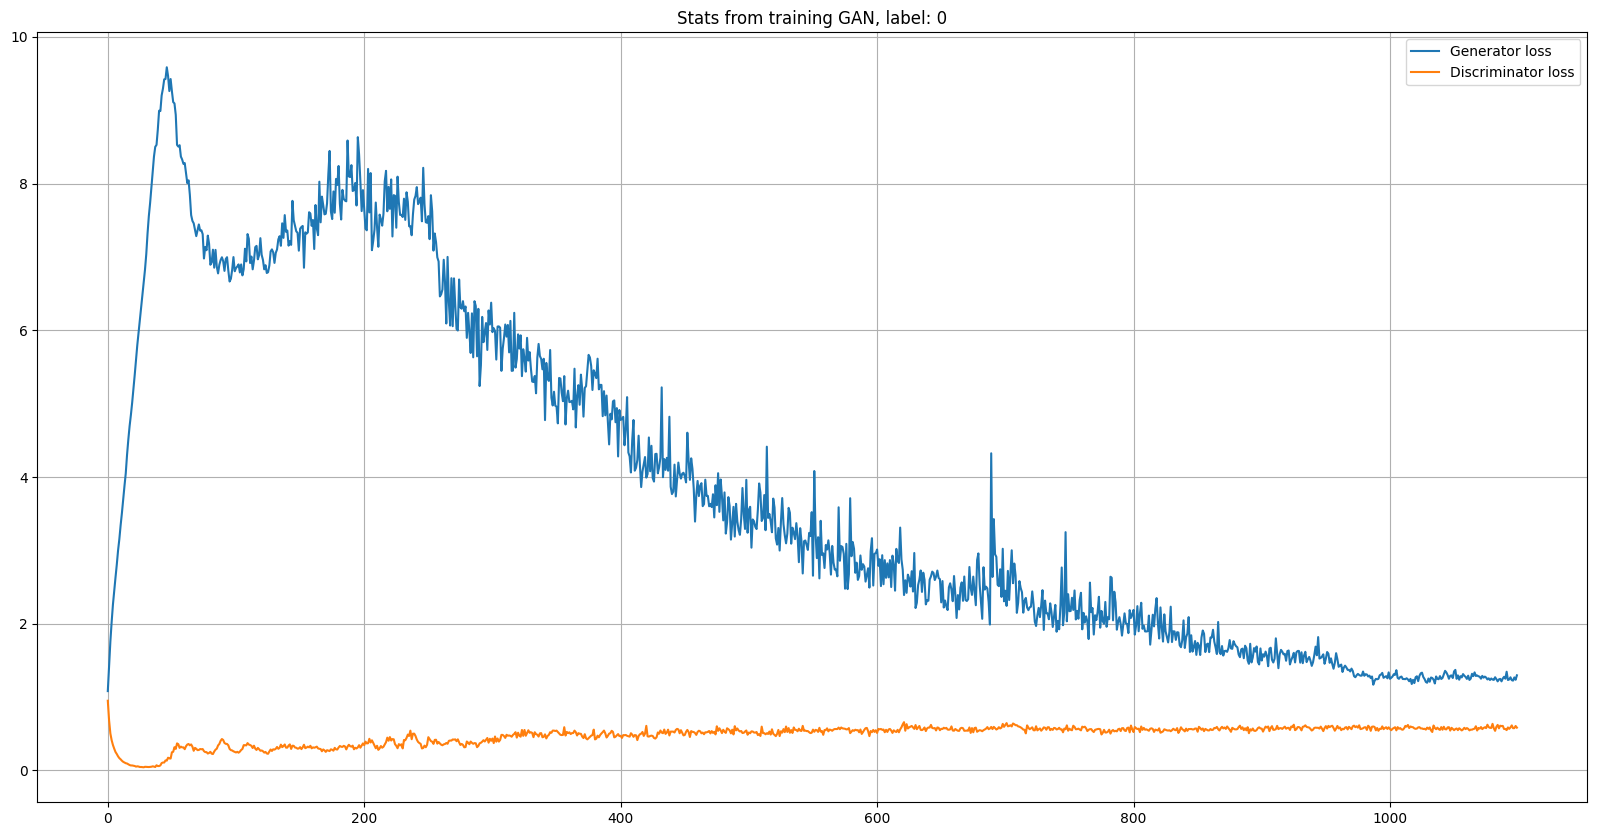

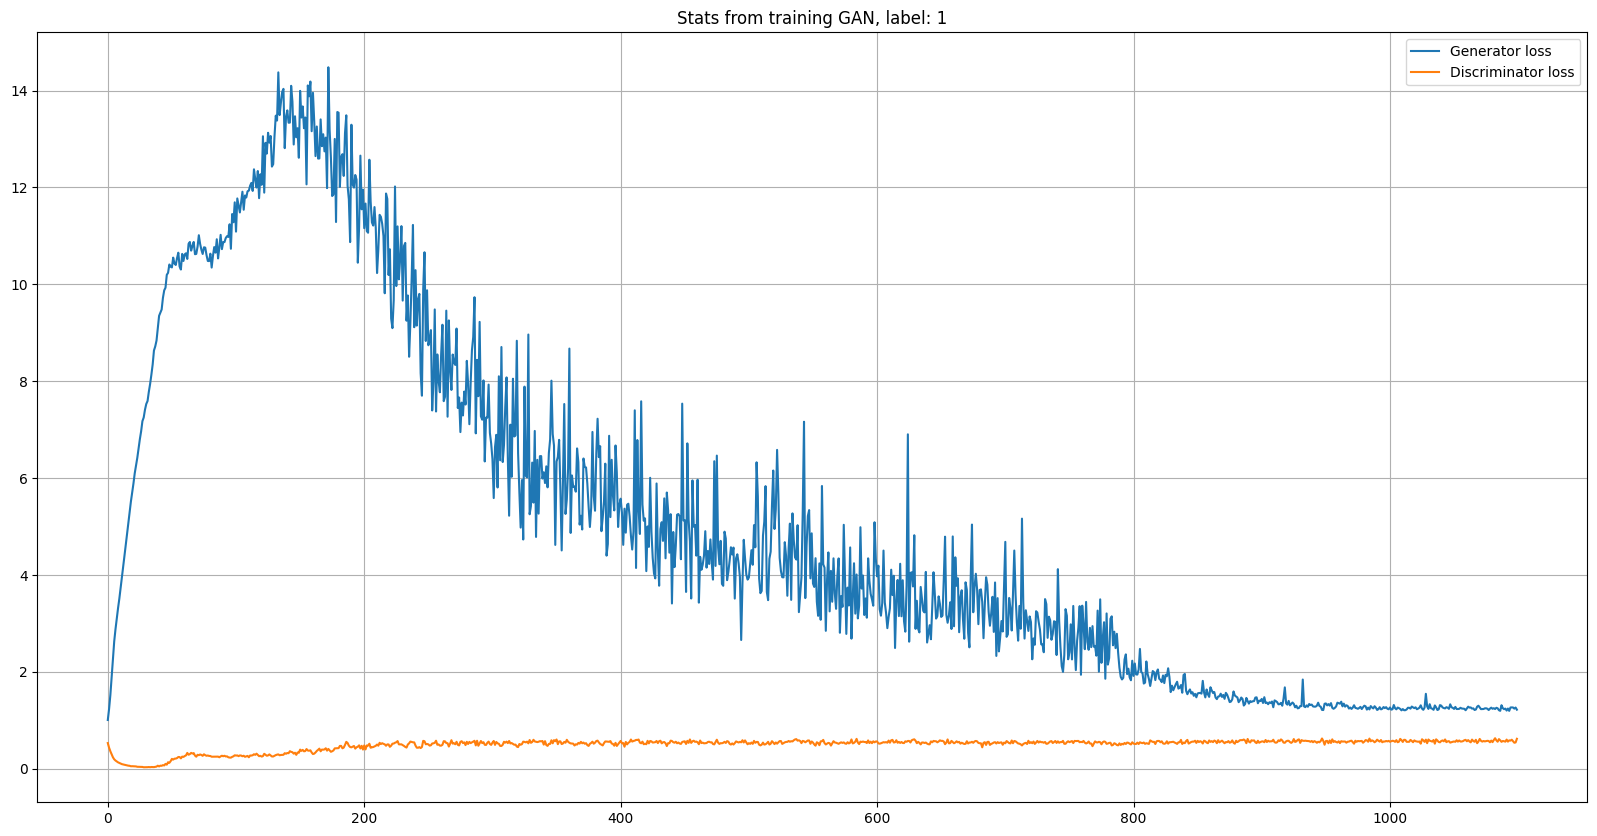

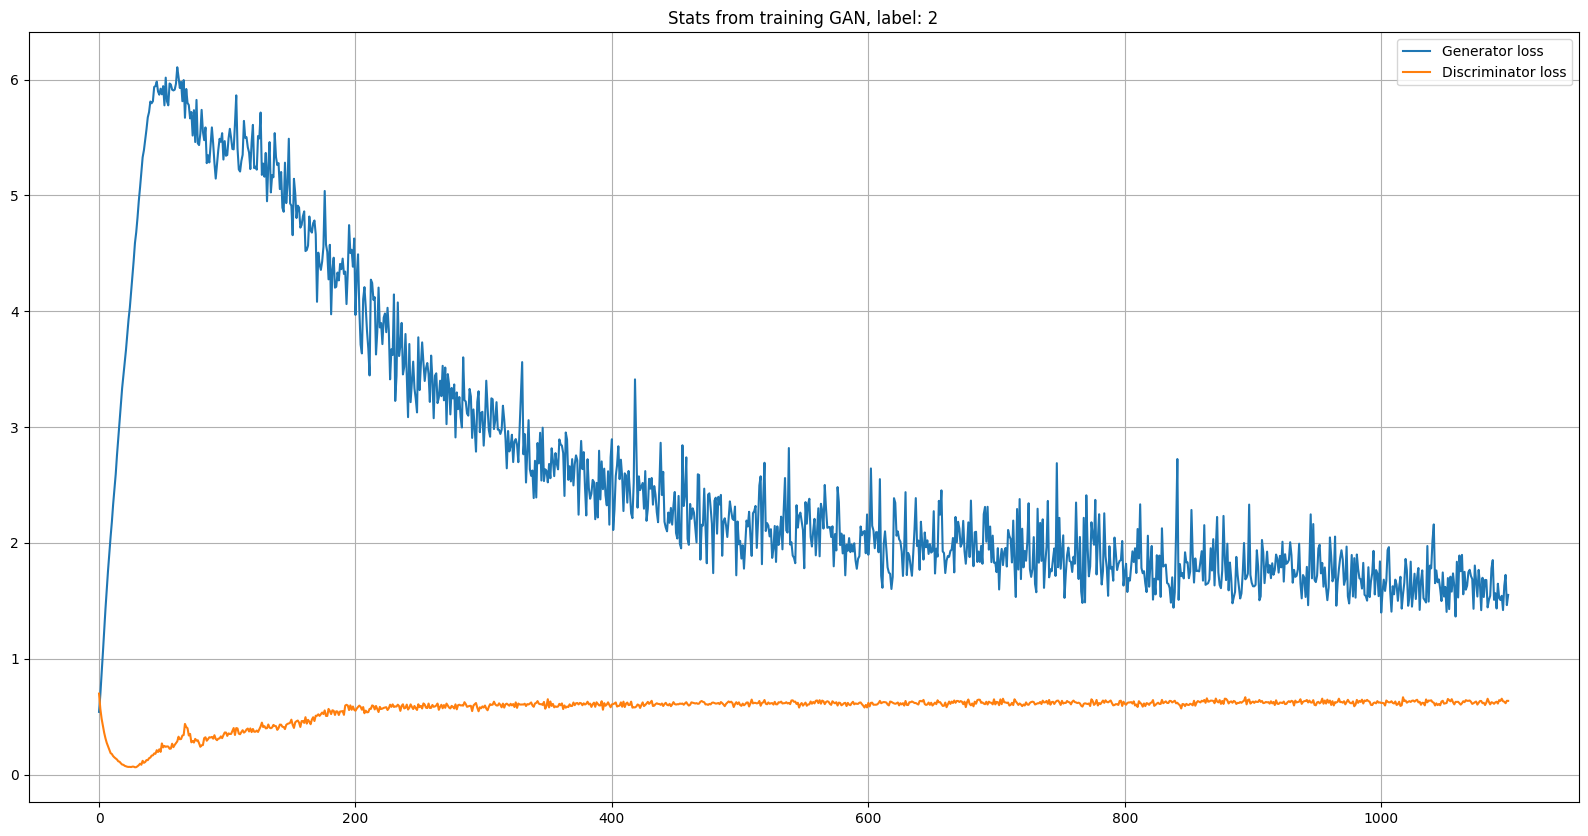

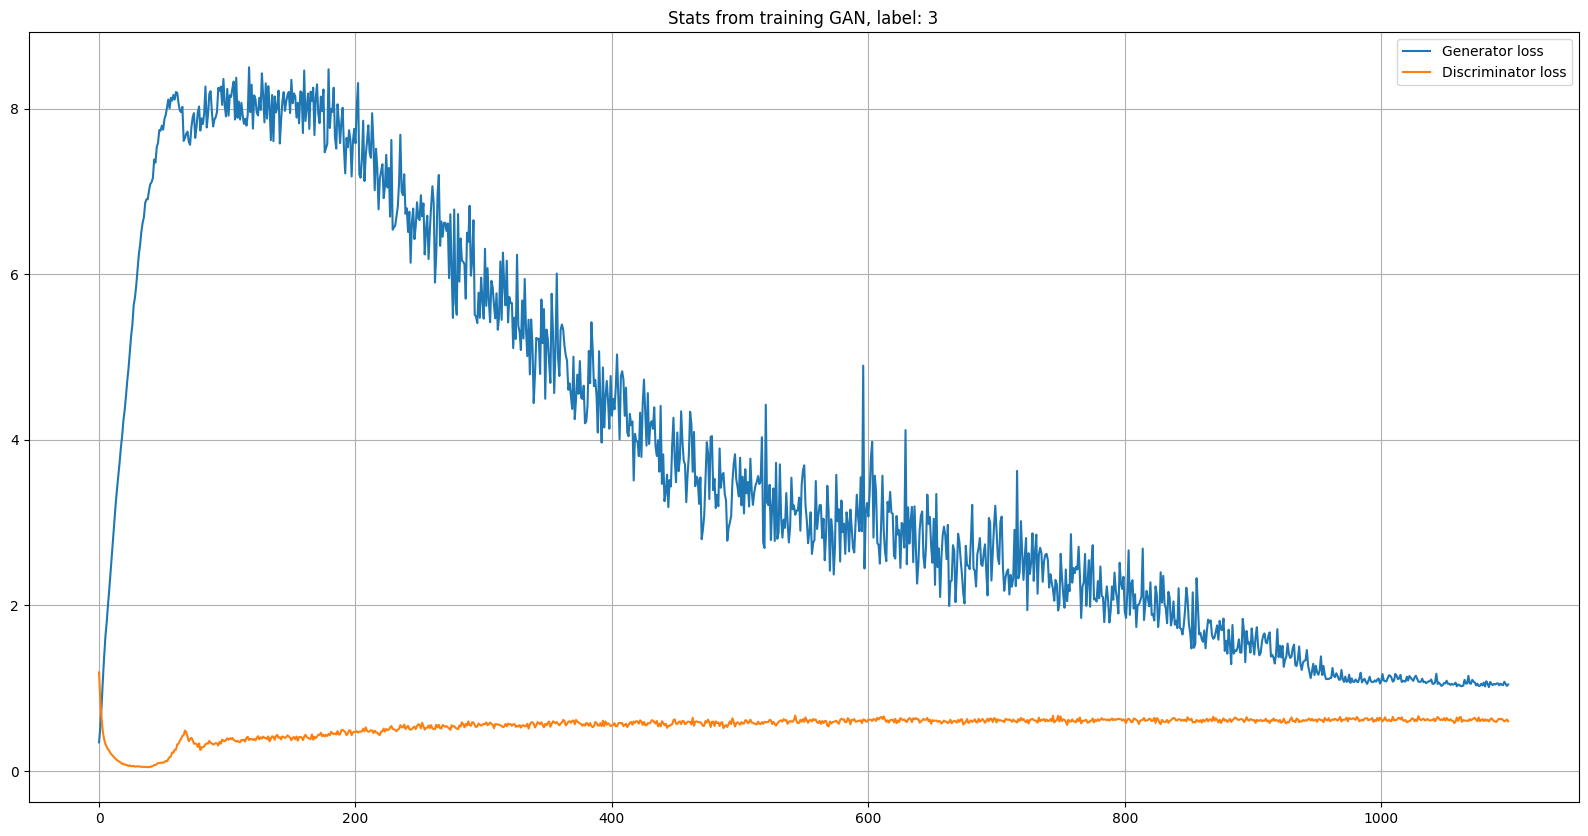

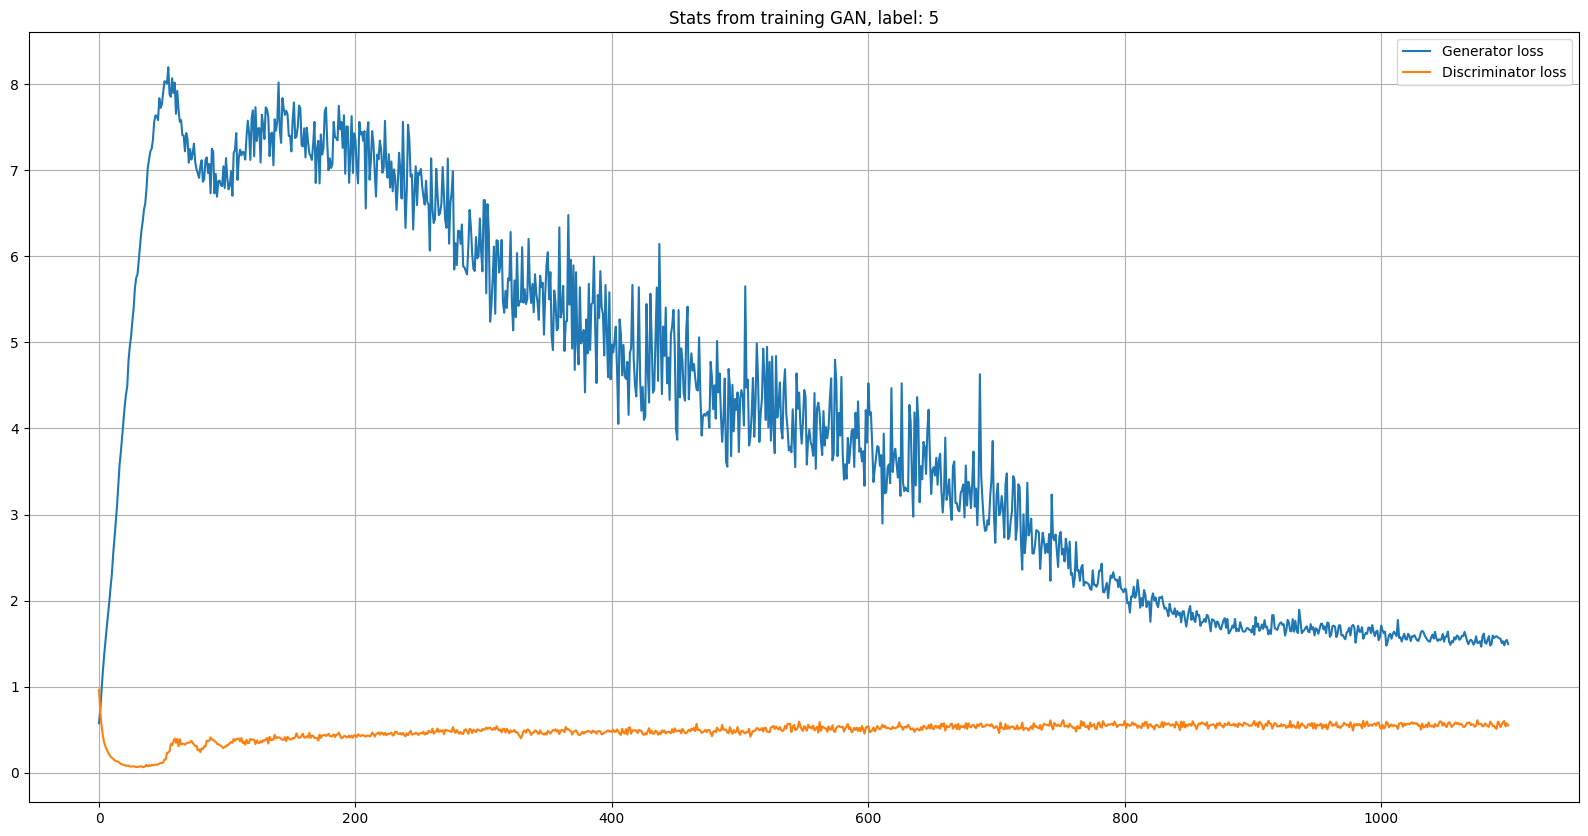

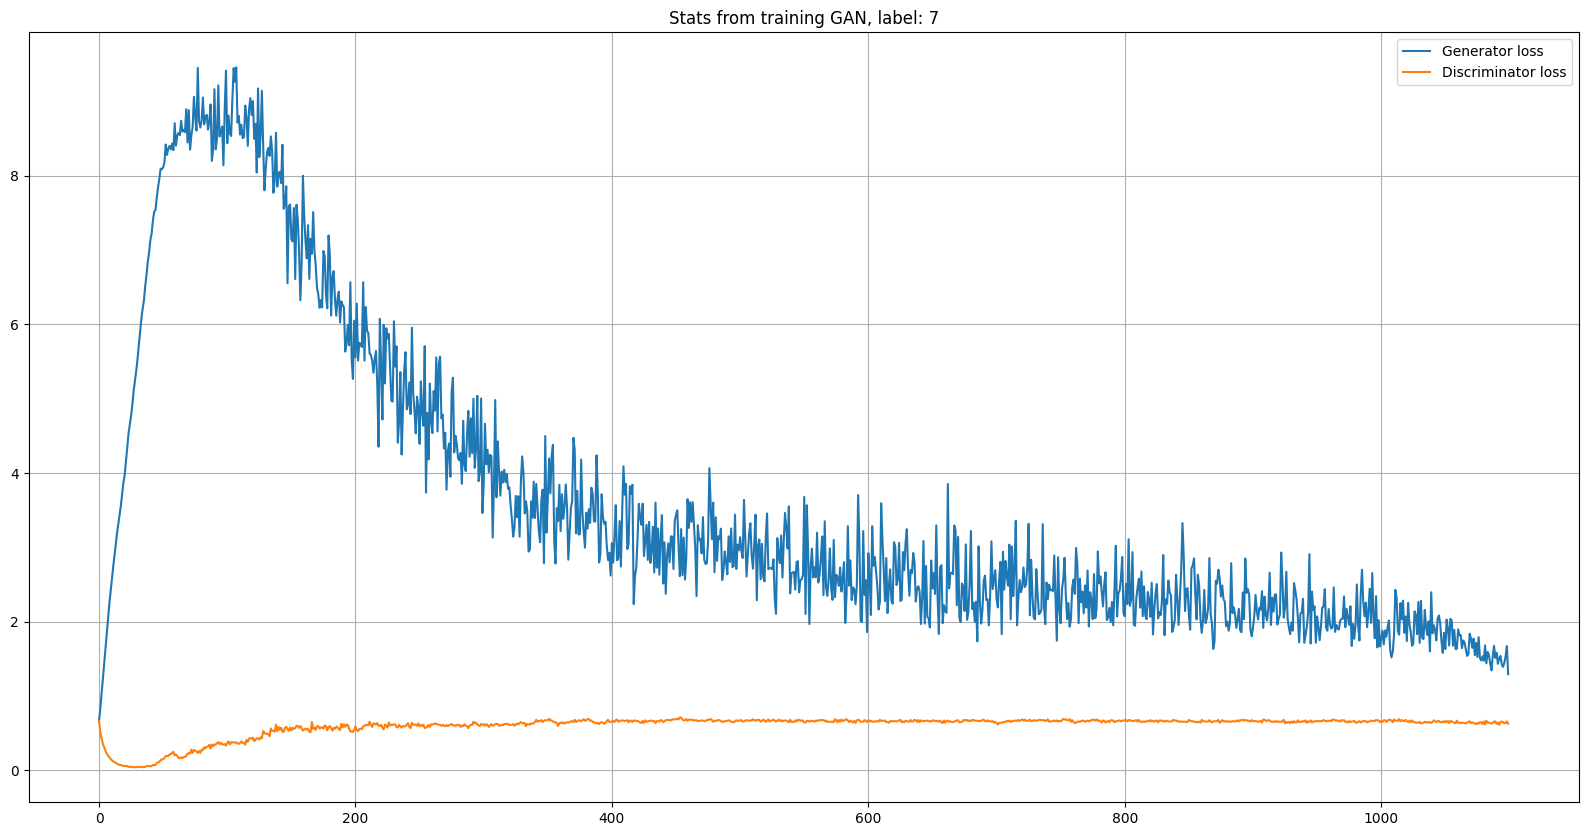

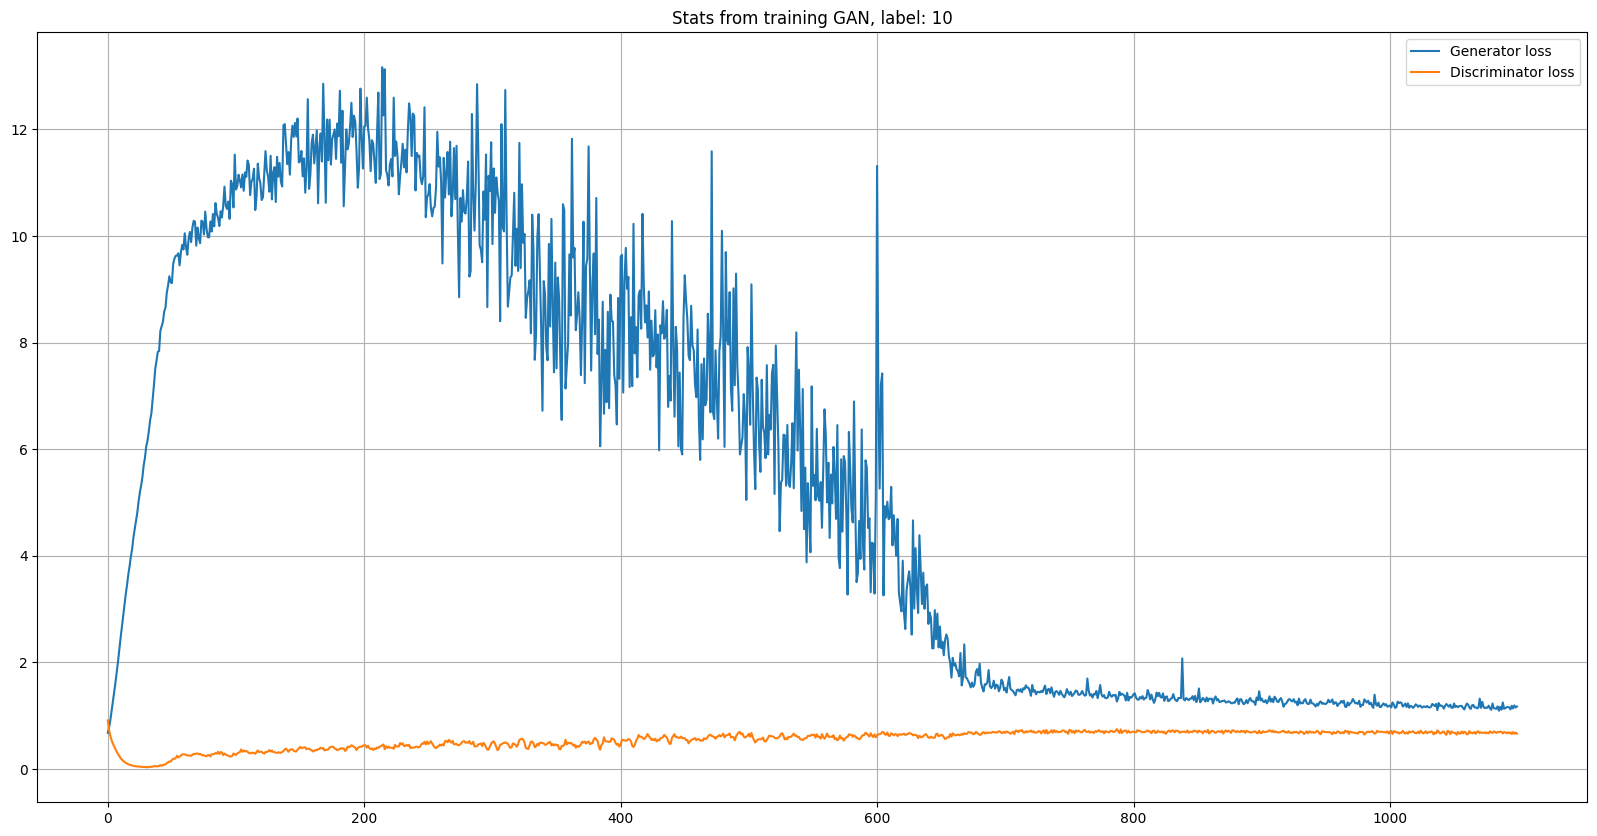

In [13]:
def convert_to_dataframe(arr, c):
    """Convert a numpy array to a pandas dataframe."""
    #print(features.columns)
    return pd.DataFrame(arr, columns=c)

def generate_fake_data_for_label(real_data, label, num_to_generate, input_dimension, latent_dim, c):
    """Generate synthetic data to balance the specified label."""
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    generator = build_generator(input_dimension.shape[1], latent_dim)
    discriminator = build_discriminator(input_dimension.shape[1], optimizer)
    gan = build_gan(generator, discriminator, optimizer)
    train(gan, generator, discriminator, real_data, latent_dim, label, n_epochs=1100, n_batch=500, n_eval=250)

    # generate synthetic data to balance the label
    noise = np.random.normal(0, 1, (num_to_generate, latent_dim))
    gen_data = generator(noise)

    # convert numpy array to dataframe and add label column
    data_generated = convert_to_dataframe(min_max_scaler.inverse_transform(gen_data), c)
    data_generated['label'] = label
    
    return data_generated

#split label and feature data 
labels = data[['label']]
labels = np.array(labels).ravel() # ensure it's a 1D array of shape (n_samples, )

features = data.drop(columns=['label'])

# print(features.columns)

#encode labels to numbers
LE = LabelEncoder()
LE.fit(labels)
# save the label encoder object to a file
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(LE, f)
    
labels = LE.transform(labels)
d = LE.inverse_transform(labels)
d = pd.Series(d)

# convert labels to a dataframe
labels_df = lbl_df(labels)

# print('\n\n\n\n\n')
# print(labels_df.columns)

# split data into train and test sets
fts_train, fts_test, lbl_train, lbl_test = train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)

# normalize feature data
min_max_scaler = MinMaxScaler().fit(fts_train)
fts_train_norm = min_max_scaler.transform(fts_train)
fts_test_norm = min_max_scaler.transform(fts_test)

# convert normalized feature data to dataframes
fts_train_df = convert_to_dataframe(min_max_scaler.inverse_transform(fts_train_norm), features.columns)
fts_test_df = convert_to_dataframe(min_max_scaler.inverse_transform(fts_test_norm), features.columns)

# convert lbl_train to a dataframe
lbl_train_df = convert_to_dataframe(lbl_train, ['label'])
# concatenate fts_train_df and lbl_train_df along columns
fts_train_df = pd.concat([fts_train_df, lbl_train_df], axis=1)

# convert lbl_test to a dataframe
lbl_test_df = convert_to_dataframe(lbl_test, ['label'])
# concatenate fts_test_df and lbl_test_df along columns
fts_test_df = pd.concat([fts_test_df, lbl_test_df], axis=1)

input_dimension = fts_test_df.drop(columns=['label'])

# get unique labels and their counts
unique_labels, label_counts = np.unique(fts_train_df['label'], return_counts=True)
target = label_counts.max()
print('Target distribution for test data =', target)

# generate synthetic data for each label with count less than the target count
fake_data_df = pd.DataFrame(columns=list(features.columns) + ['label'])
for label, count in zip(unique_labels, label_counts):
#     print(target)
#     print(count)
    gen_num = target - count
    print(f'Generating {gen_num} samples for label {label}')
    if not gen_num:
        continue
    elif gen_num < 0:
        print('ERROR, ERROR: GEN_NUM IS NEGATIVE!')
    else:
        real_data = fts_train_df.loc[fts_train_df['label'] == label]
        fake_data_for_label = generate_fake_data_for_label(real_data, label, gen_num, input_dimension, latent_dim=12, c=features.columns)
        print(f'Generated {fake_data_for_label.shape[0]} samples')
        fake_data_df = fake_data_df.append(fake_data_for_label, ignore_index=True)


In [14]:
# Make sure the column types of generated data is correct
# fake_data_df = fake_data_df.astype(fts_train_df.dtypes.to_dict())
fake_data_df = fake_data_df.astype(data.dtypes.to_dict())
fake_data_df['label'] = fake_data_df['label'].astype('int64')
fake_data_df

destination_port  flow_duration  total_fwd_packets  \
0                      21          25850                 13   
1                       9          20127                 19   
2                    9749         514025                  7   
3                    7684        1199810                 24   
4                       5      109250828                 52   
...                   ...            ...                ...   
1223875                 4        5680384                  7   
1223876                 6        5547825                  5   
1223877                 3        5799850                  8   
1223878                 7        5484685                  4   
1223879                 4        5493764                  5   

         total_backward_packets  total_length_of_fwd_packets  \
0                            18                          118   
1                            29                          210   
2                            14                           90   
3                            35                          291   
4                            62                          474   
...                         ...                          ...   
1223875                       8                           62   
1223876                       5                           56   
1223877                       9                           54   
1223878                       4                           55   
1223879                       5                           56   

         total_length_of_bwd_packets  fwd_packet_length_max  \
0                              48767                      7   
1                              69824                     17   
2                              31865                    126   
3                             109945                     69   
4                             250183                    145   
...                              ...                    ...   
1223875                        19613                      1   
1223876                        15708                      0   
1223877                        22165                      1   
1223878                        12346                      0   
1223879                        14593                      0   

         fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
0                           29                4.008252               0.459106   
1                          152                7.563452               0.767648   
2                            0               60.860518              48.847031   
3                            1               18.525799              15.457809   
4                            0                2.673869               7.117347   
...                        ...                     ...                    ...   
1223875                      0                0.861986               0.696674   
1223876                      0                0.601177               0.943755   
1223877                      0                1.217587               0.516630   
1223878                      0                0.438023               1.004729   
1223879                      0                0.606852               0.789981   

         ...  min_seg_size_forward    active_mean    active_std  active_max  \
0        ...              -1246677    1215.848735   2049.593176        2531   
1        ...              -1680981    1225.386820   3793.475608        2243   
2        ...              -5915188  159015.603410  20007.379912       21960   
3        ...             -13516563  107875.097590  29565.463588       39991   
4        ...               -874357   60188.366915  15278.844070     4358373   
...      ...                   ...            ...           ...         ...   
1223875  ...               -756821    2238.158645   1618.858750        2890   
1223876  ...               -504309    1539.034432   1224.847772        4165   
1223877  ...               -749525    2775

In [15]:
fake_data_df['label'].value_counts()

10    160032
1     159718
5     157238
6     157030
9     156959
7     155532
3     153882
2      71470
8      49924
0       2095
Name: label, dtype: int64

In [16]:
# SAVE fake_data_df
output_path = 'aug_data_1.csv'
# fake_data_df.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
fake_data_df.to_csv(output_path)

In [21]:
# SAVE TRAINING SET AND TEST SET
output_path = 'fts_train_df.csv'
fts_train_df.to_csv(output_path)

output_path = 'fts_test_df.csv'
fts_test_df.to_csv(output_path)

# MAKE SURE EVERYTHING YOU NEED IS SAVED BEFORE CONTINUING WITH THE IDS OR OTHER MODEL

In [106]:
from keras.optimizers import RMSprop
from keras.backend import clip
from keras import backend as K

def build_wgan_generator(n_columns, latent_dim):
    model = Sequential([
        Dense(128, kernel_initializer="he_uniform", input_dim=latent_dim),
        LeakyReLU(0.2),
        layers.Dropout(0.5),
        BatchNormalization(momentum=0.8),
        Dense(256, kernel_initializer="he_uniform"),
        LeakyReLU(0.2),
        layers.Dropout(0.5),
        BatchNormalization(momentum=0.8),
#         Dense(512, kernel_initializer="he_uniform"),
#         LeakyReLU(0.2),
#         layers.Dropout(0.5),
#         BatchNormalization(momentum=0.8),
        Dense(512, kernel_initializer="he_uniform"),
        LeakyReLU(0.2),
        layers.Dropout(0.5),
        BatchNormalization(momentum=0.8),
        Dense(1024, kernel_initializer="he_uniform"),
        LeakyReLU(0.2),
        layers.Dropout(0.5),
        BatchNormalization(momentum=0.8),
        Dense(n_columns, activation="tanh")
    ])
    return model

def build_wgan_discriminator(n_columns, optimizer, clip_value=0.01):
    model = Sequential([
        Dense(128, kernel_initializer="he_uniform", input_dim=n_columns),
        LeakyReLU(0.2),
#         Dense(256, kernel_initializer="he_uniform"),
#         LeakyReLU(0.2),
#         Dense(128, kernel_initializer="he_uniform"),
#         LeakyReLU(0.2),
        Dense(32, kernel_initializer="he_uniform"),
        LeakyReLU(0.2),
        Dense(8, kernel_initializer="he_uniform"),
        LeakyReLU(0.2),
        Dense(1)
    ])
    model.compile(loss=wasserstein_loss, optimizer=optimizer)
    return model

def wasserstein_loss(lbl_true, lbl_pred):
    return -K.mean(lbl_true * lbl_pred)

def build_wgan(generator, discriminator, optimizer):
    model = Sequential([generator, discriminator])
    model.compile(loss=wasserstein_loss, optimizer=optimizer)
    return model

def generate_fake_samples(generator, latent_dim, n_samples):
    fts_input = generate_latent_points(latent_dim, n_samples)
    fts = generator.predict(fts_input)
    lbl = -np.ones((n_samples, 1))
    return fts, lbl

def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(n_samples, latent_dim)
    return x_input

def compute_wasserstein_distance(generator, discriminator, real_samples, latent_dim, n_samples):
    # Generate fake samples
    fake_samples = generator.predict(np.random.randn(n_samples, latent_dim))
    # Compute discriminator scores for real and fake samples
    real_scores = discriminator.predict(real_samples)
    fake_scores = discriminator.predict(fake_samples)
    # Compute Wasserstein distance
    wasserstein_distance = tf.reduce_mean(fake_scores) - tf.reduce_mean(real_scores)
    return wasserstein_distance

def train_wgan(generator, discriminator, gan, data, latent_dim, n_epochs, n_batch, n_eval):
    d_loss = []
    g_loss = []
    wasser = []
    half_batch = int(n_batch / 2)
    
    lbl = data['label'].unique()[0]
    print(f'GAN training of label: {lbl}, samples = {data.shape[0]}')
    
    data = data.drop(columns=['label'])
    data = min_max_scaler.transform(data)
    data = convert_to_dataframe(data, features.columns)
    
    clip_value = 0.01
    
    for i in range(n_epochs):
        
        idx = np.random.choice(data.shape[0], half_batch, replace=False)
        fts_real = data.iloc[idx]
        fts_fake, lbl_fake = generate_fake_samples(generator, latent_dim, half_batch)
        lbl_real = -np.ones((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(fts_real, lbl_real)
        d_loss_fake = discriminator.train_on_batch(fts_fake, lbl_fake)
        d_loss_epoch = 0.5 * np.add(d_loss_real, d_loss_fake)

        for l in discriminator.layers:
            weights = l.get_weights()
            weights = [clip(w, -clip_value, clip_value) for w in weights]
            l.set_weights(weights)
        for j in range(10):
            fts_gan = generate_latent_points(latent_dim, n_batch)
            lbl_gan = -np.ones((n_batch, 1))
            g_loss_epoch = gan.train_on_batch(fts_gan, lbl_gan)

        d_loss.append(d_loss_epoch)
        g_loss.append(g_loss_epoch)
        
        wasserstein_distance = compute_wasserstein_distance(generator, discriminator, fts_real, latent_dim, n_batch)
        wasser.append(wasserstein_distance)
        
        print("Epoch {}: Generator loss={}, Discriminator loss={}, Wasserstein distance={}".format(i, g_loss_epoch, d_loss_epoch, wasserstein_distance))
#         print (f"Label: {lbl} Epoch: %d [Generator loss: %f] [Discriminator loss: %f]" % (j + 1, g_loss_epoch, d_loss_epoch))

    #plot losses after training
    plt.figure(figsize = (20, 10))
    plt.plot(g_loss, label = "Generator loss")
    plt.plot(d_loss, label = "Discriminator loss")
    plt.title(f"Stats from training GAN, label: {lbl}")
    plt.legend()
    plt.grid()
    
    #plot w distance after training
    plt.figure(figsize = (20, 10))
    plt.plot(range(n_epochs), wasser)
    plt.xlabel('Epoch')
    plt.ylabel('Wasserstein distance')
    plt.grid()
        
    return d_loss, g_loss


Target distribution for test data = 161087
Generating 2095 samples for label 0
GAN training of label: 0, samples = 158992
16/16 [==============================] - 0s 5ms/step
Epoch 0: Generator loss=-0.001887207617983222, Discriminator loss=0.1857181414961815, Wasserstein distance=-1.2957025319337845e-06
16/16 [==============================] - 0s 4ms/step
Epoch 1: Generator loss=-0.003222599159926176, Discriminator loss=-0.0020636864937841892, Wasserstein distance=-1.4633405953645706e-06
16/16 [==============================] - 0s 9ms/step
Epoch 2: Generator loss=-0.004477332811802626, Discriminator loss=-0.003380468813702464, Wasserstein distance=-1.7103739082813263e-06
16/16 [==============================] - 0s 5ms/step
Epoch 3: Generator loss=-0.0057200598530471325, Discriminator loss=-0.004632106749340892, Wasserstein distance=-1.9827857613563538e-06
16/16 [==============================] - 0s 4ms/step
Epoch 4: Generator loss=-0.006965432316064835, Discriminator loss=-0.005875199

16/16 [==============================] - 0s 5ms/step
Epoch 7: Generator loss=-0.010779979638755322, Discriminator loss=-0.009666354395449162, Wasserstein distance=-3.816559910774231e-06
16/16 [==============================] - 0s 4ms/step
Epoch 8: Generator loss=-0.011343668214976788, Discriminator loss=-0.010946028865873814, Wasserstein distance=-4.620291292667389e-06
16/16 [==============================] - 0s 4ms/step
Epoch 9: Generator loss=-0.01142297126352787, Discriminator loss=-0.01151087274774909, Wasserstein distance=-5.879439413547516e-06
16/16 [==============================] - 0s 4ms/step
Epoch 10: Generator loss=-0.011504760012030602, Discriminator loss=-0.011591235641390085, Wasserstein distance=-7.595866918563843e-06
16/16 [==============================] - 0s 4ms/step
Epoch 11: Generator loss=-0.011576900258660316, Discriminator loss=-0.011674090288579464, Wasserstein distance=-1.057889312505722e-05
16/16 [==============================] - 0s 4ms/step
Epoch 12: Generat

16/16 [==============================] - 0s 4ms/step
Epoch 14: Generator loss=-0.011676187627017498, Discriminator loss=-0.011807297356426716, Wasserstein distance=-4.063360393047333e-05
16/16 [==============================] - 0s 5ms/step
Epoch 15: Generator loss=-0.01171028707176447, Discriminator loss=-0.011843226384371519, Wasserstein distance=-6.227008998394012e-05
16/16 [==============================] - 0s 4ms/step
Epoch 16: Generator loss=-0.011745494790375233, Discriminator loss=-0.011881431099027395, Wasserstein distance=-9.463541209697723e-05
16/16 [==============================] - 0s 4ms/step
Epoch 17: Generator loss=-0.011782985180616379, Discriminator loss=-0.01192409172654152, Wasserstein distance=-0.00014461949467658997
16/16 [==============================] - 0s 5ms/step
Epoch 18: Generator loss=-0.011824560351669788, Discriminator loss=-0.011976581998169422, Wasserstein distance=-0.00021424144506454468
16/16 [==============================] - 0s 4ms/step
Epoch 19: Ge

16/16 [==============================] - 0s 5ms/step
Epoch 1: Generator loss=-0.0032348716631531715, Discriminator loss=-0.0020726382499560714, Wasserstein distance=-3.102468326687813e-06
16/16 [==============================] - 0s 4ms/step
Epoch 2: Generator loss=-0.004499650560319424, Discriminator loss=-0.003394130151718855, Wasserstein distance=-3.6028213798999786e-06
16/16 [==============================] - 0s 5ms/step
Epoch 3: Generator loss=-0.005759818013757467, Discriminator loss=-0.004656829405575991, Wasserstein distance=-4.073139280080795e-06
16/16 [==============================] - 0s 5ms/step
Epoch 4: Generator loss=-0.007027927320450544, Discriminator loss=-0.005918779643252492, Wasserstein distance=-4.49642539024353e-06
16/16 [==============================] - 0s 4ms/step
Epoch 5: Generator loss=-0.008302274160087109, Discriminator loss=-0.007189050083979964, Wasserstein distance=-5.138106644153595e-06
16/16 [==============================] - 0s 5ms/step
Epoch 6: Genera

16/16 [==============================] - 0s 3ms/step
Epoch 8: Generator loss=-0.011380098760128021, Discriminator loss=-0.010989737696945667, Wasserstein distance=-6.279908120632172e-06
16/16 [==============================] - 0s 3ms/step
Epoch 9: Generator loss=-0.011445856653153896, Discriminator loss=-0.011547538917511702, Wasserstein distance=-8.63056629896164e-06
16/16 [==============================] - 0s 3ms/step
Epoch 10: Generator loss=-0.01150752417743206, Discriminator loss=-0.011614382732659578, Wasserstein distance=-1.284666359424591e-05
16/16 [==============================] - 0s 3ms/step
Epoch 11: Generator loss=-0.011567705310881138, Discriminator loss=-0.011676751542836428, Wasserstein distance=-1.881830394268036e-05
16/16 [==============================] - 0s 3ms/step
Epoch 12: Generator loss=-0.011614155024290085, Discriminator loss=-0.0117375492118299, Wasserstein distance=-2.7509406208992004e-05
16/16 [==============================] - 0s 3ms/step
Epoch 13: Generat

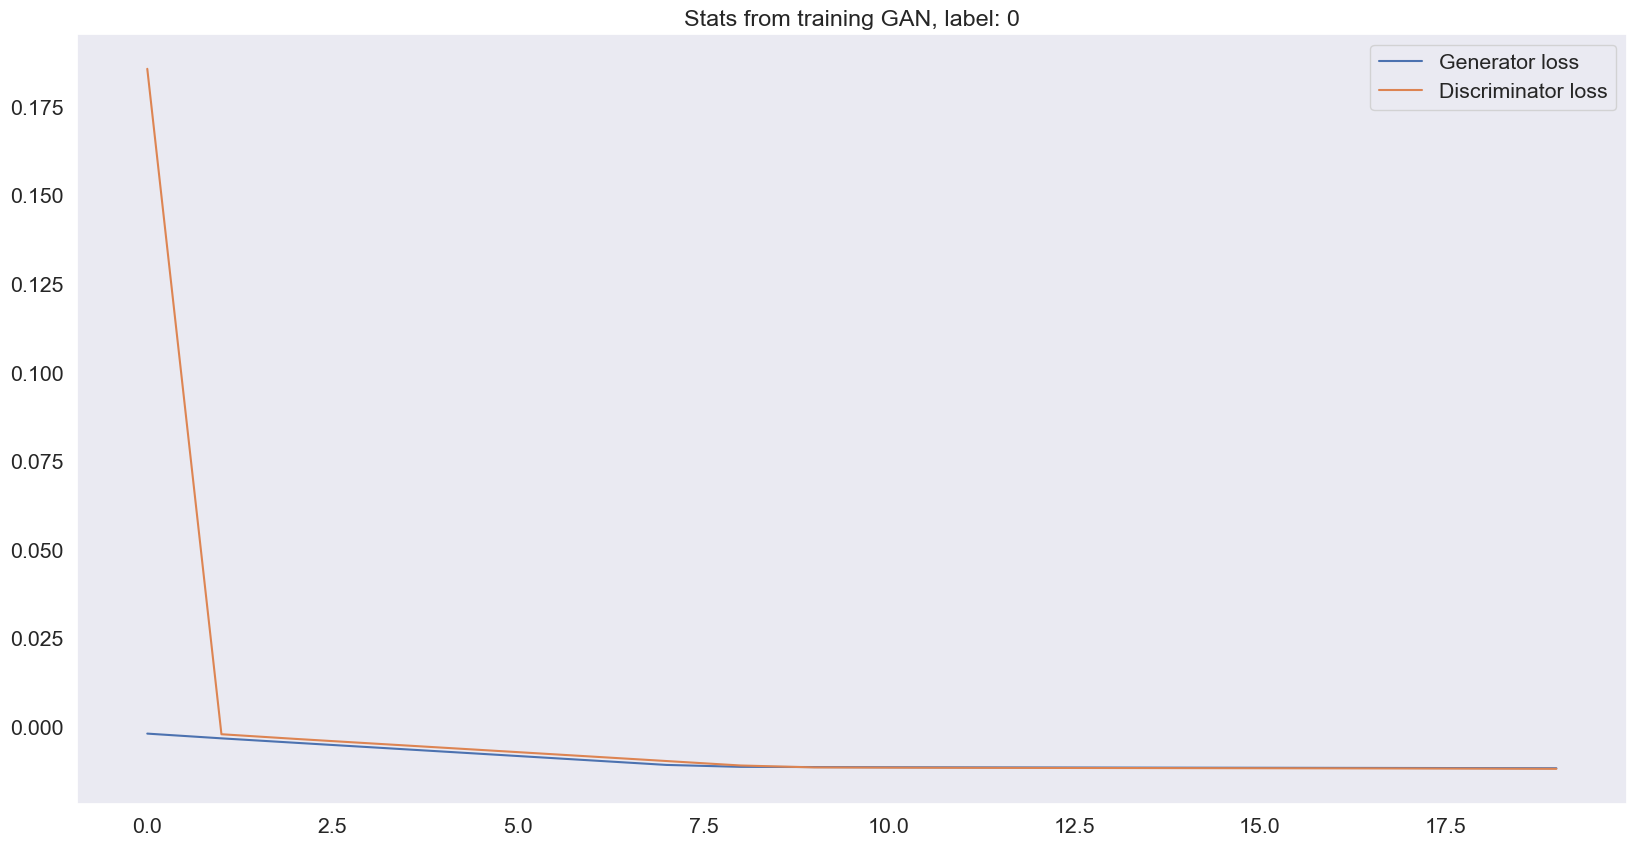

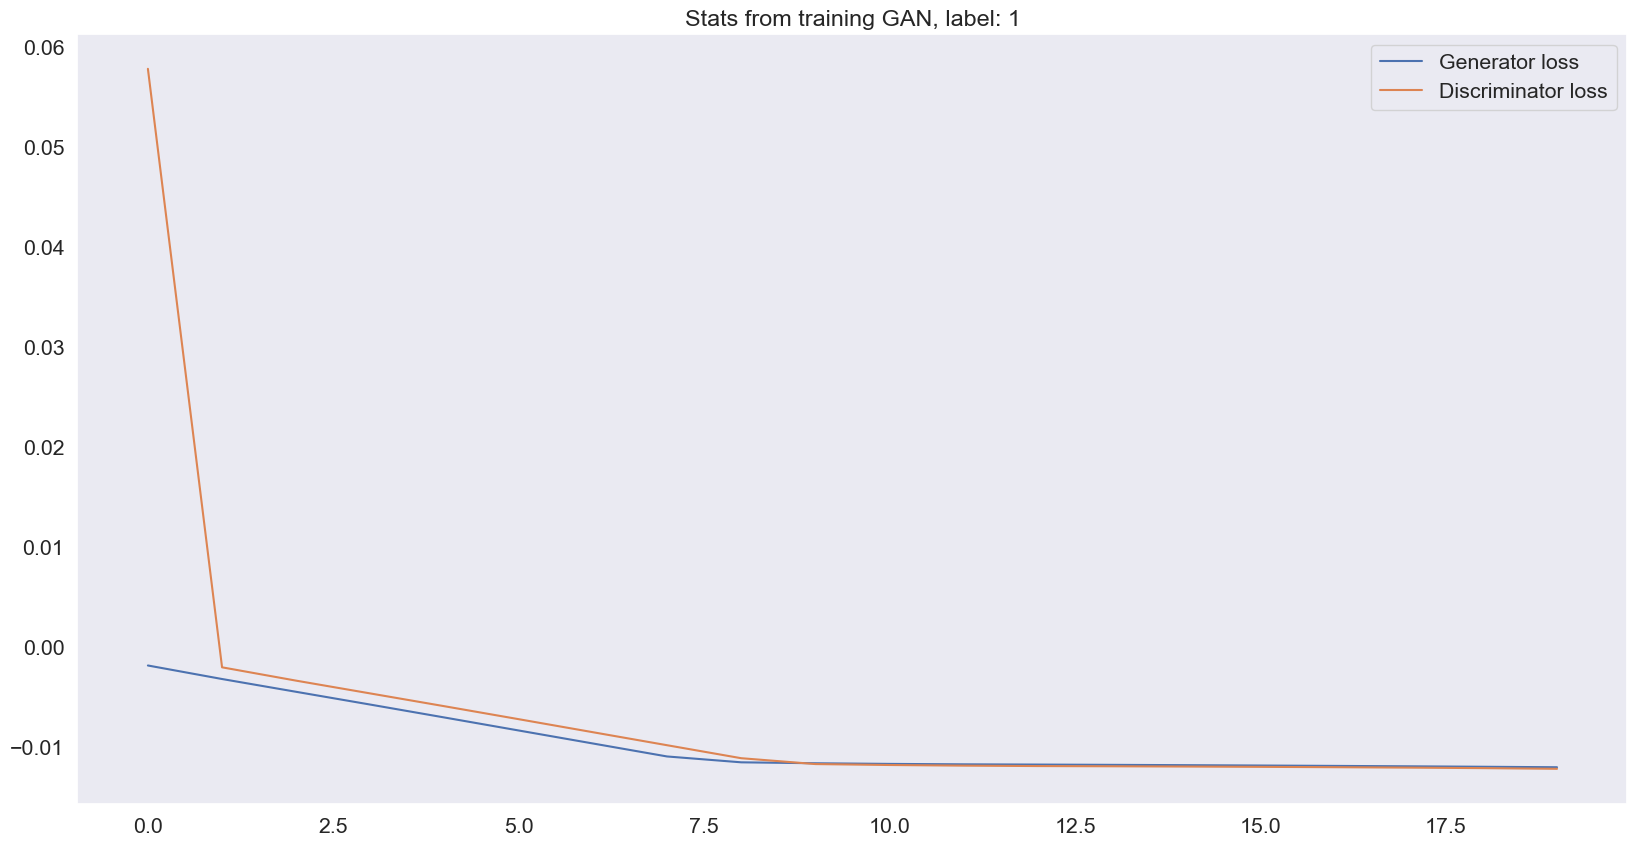

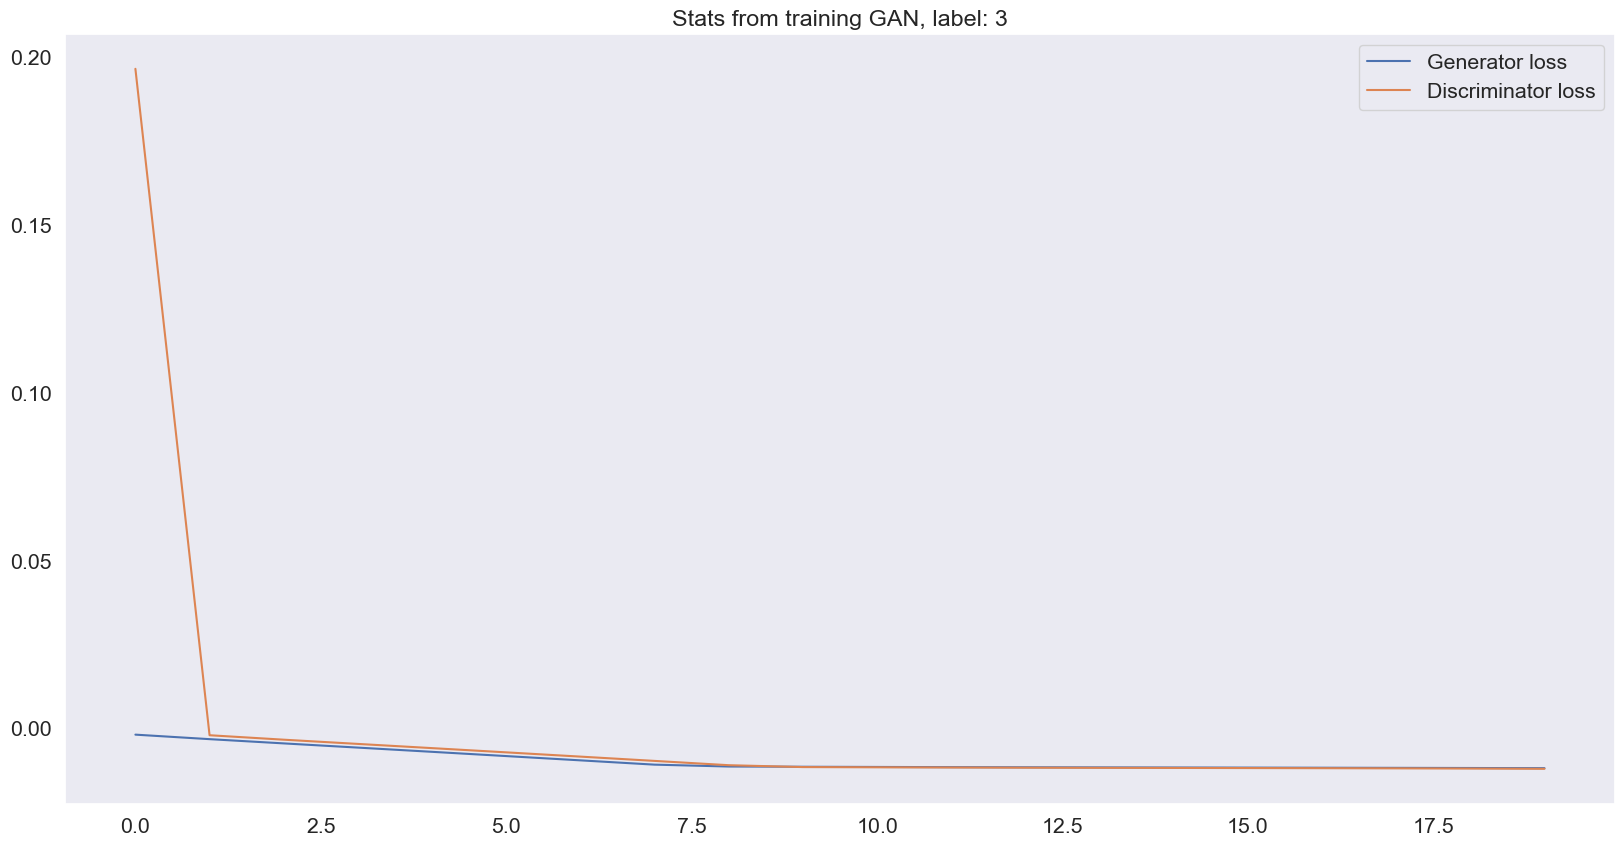

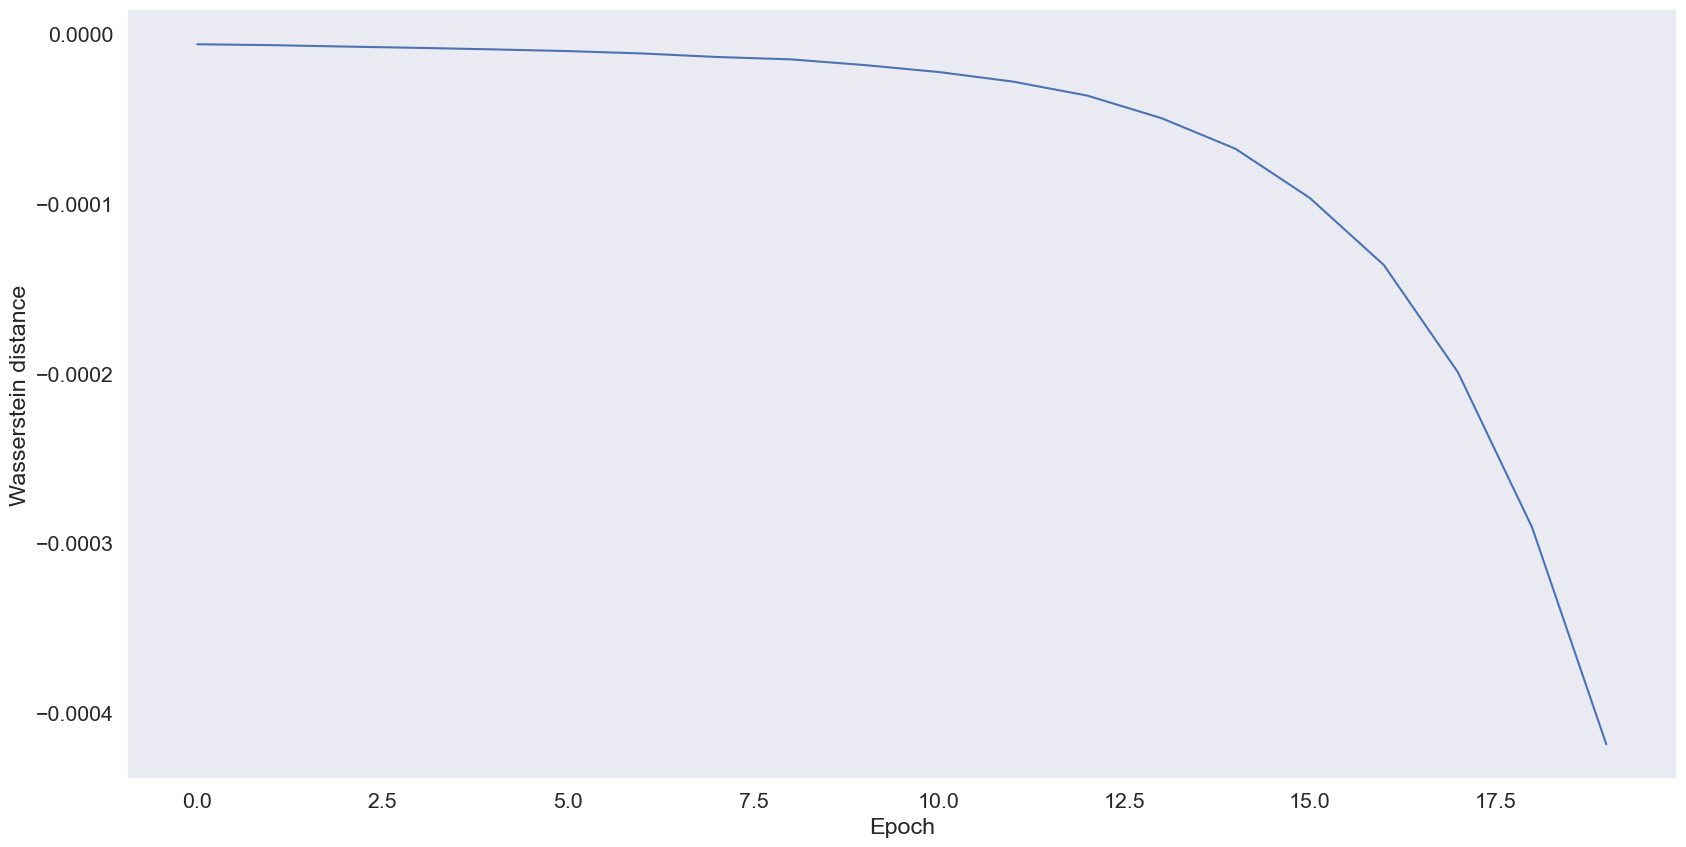

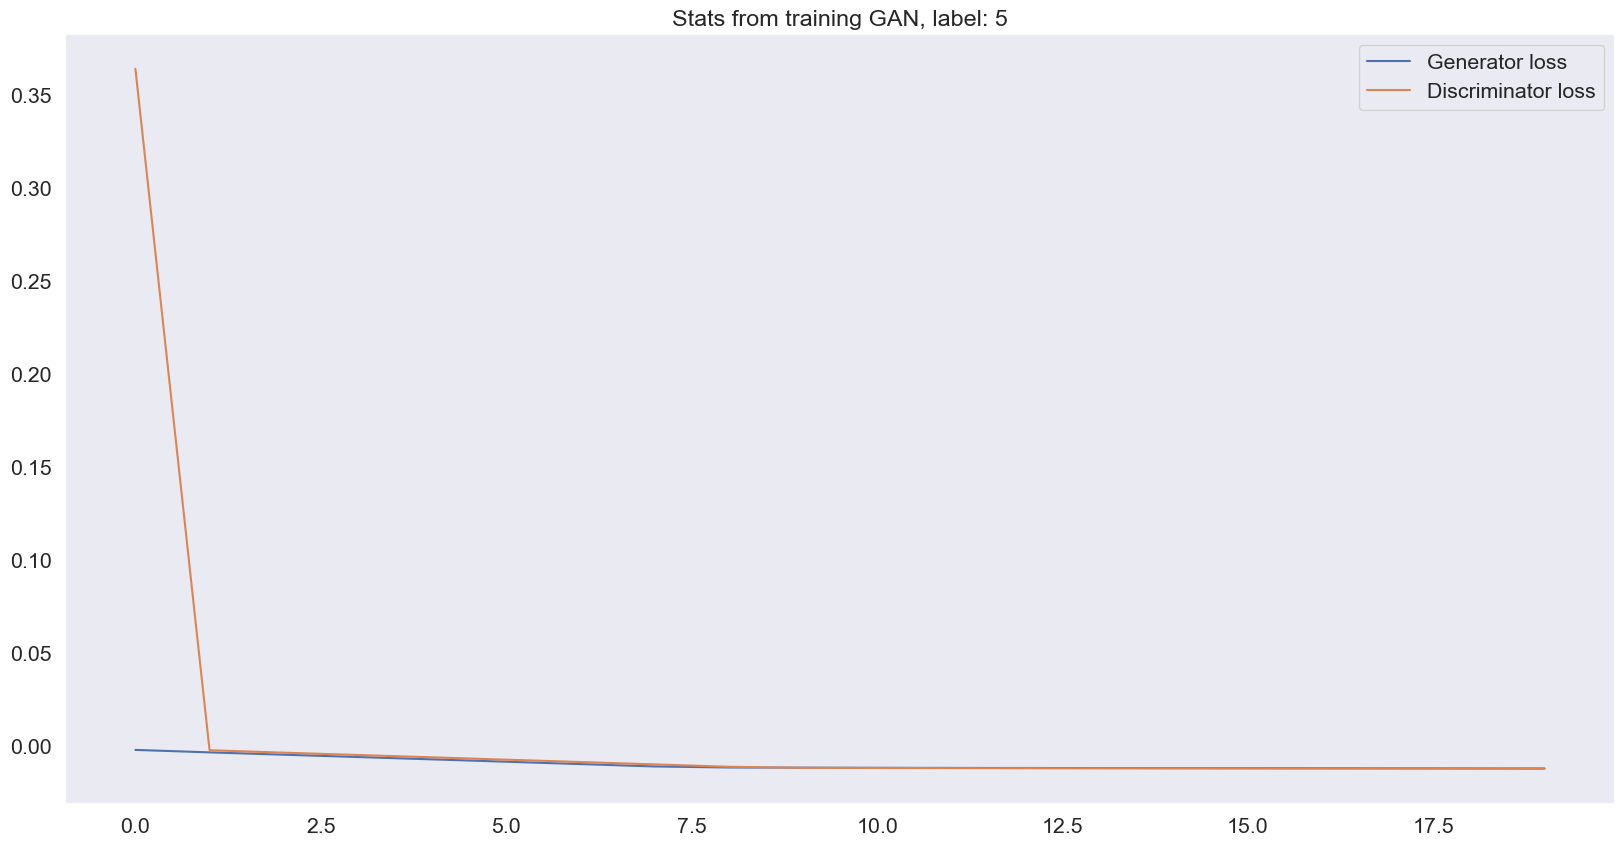

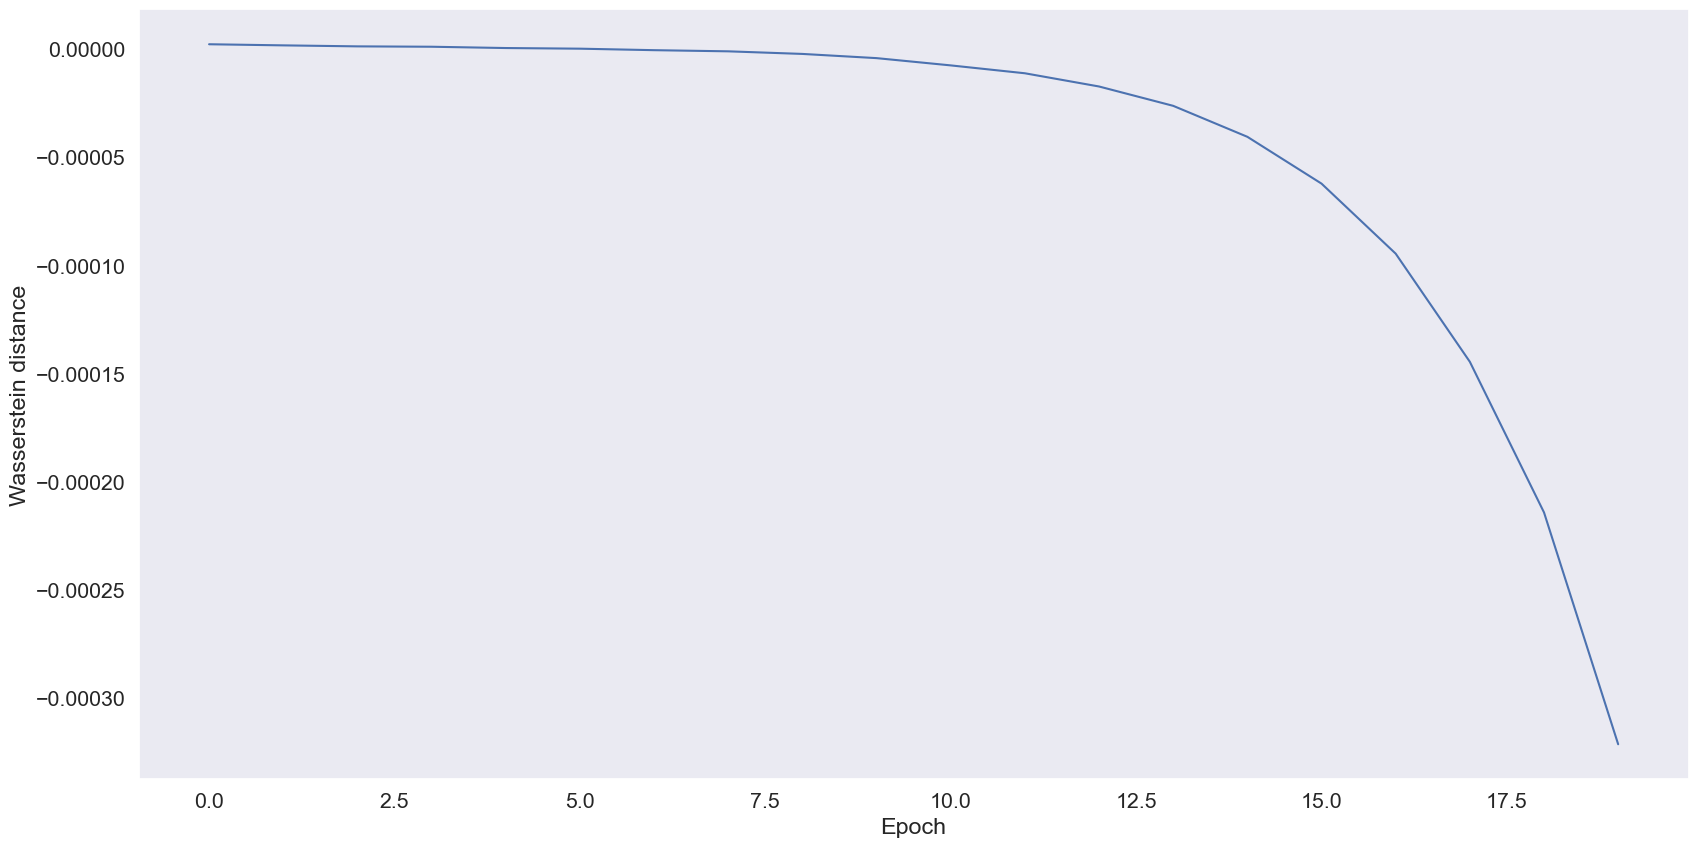

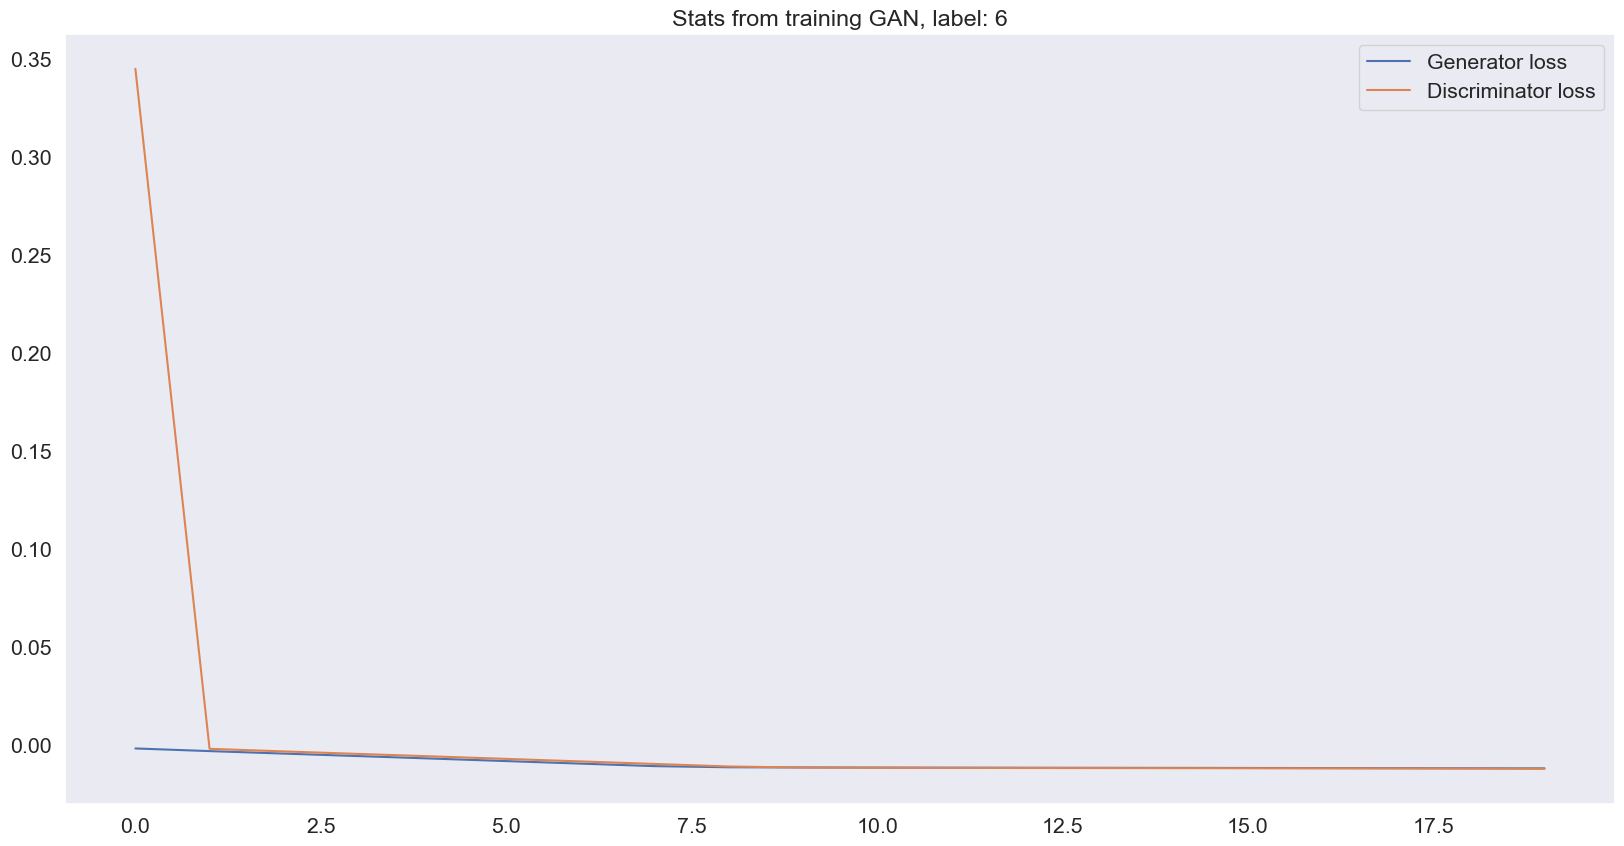

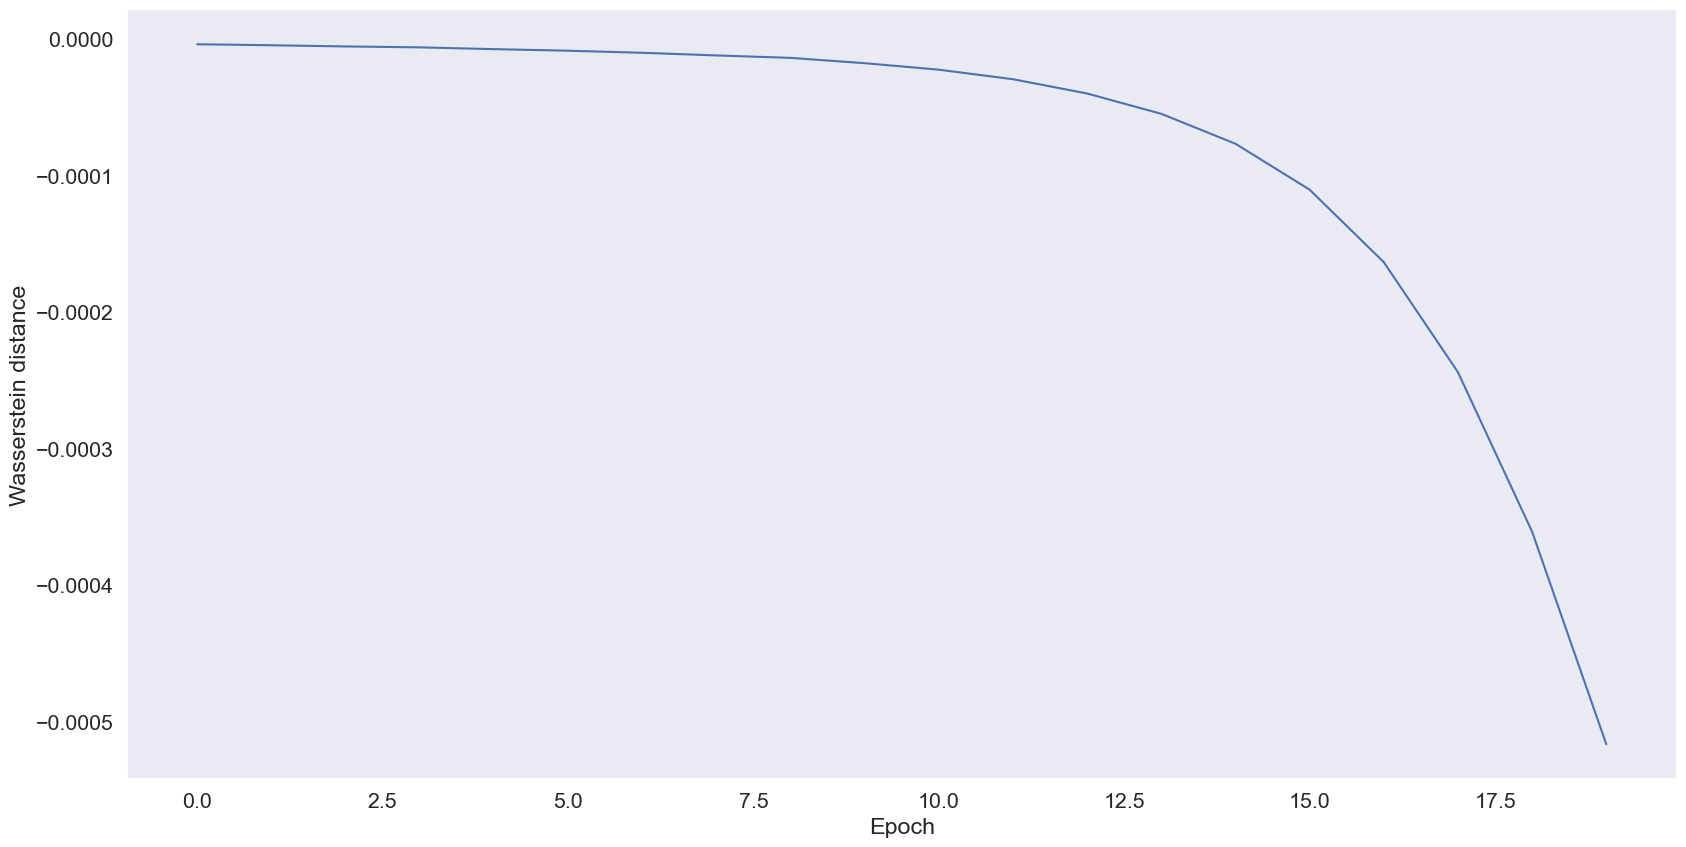

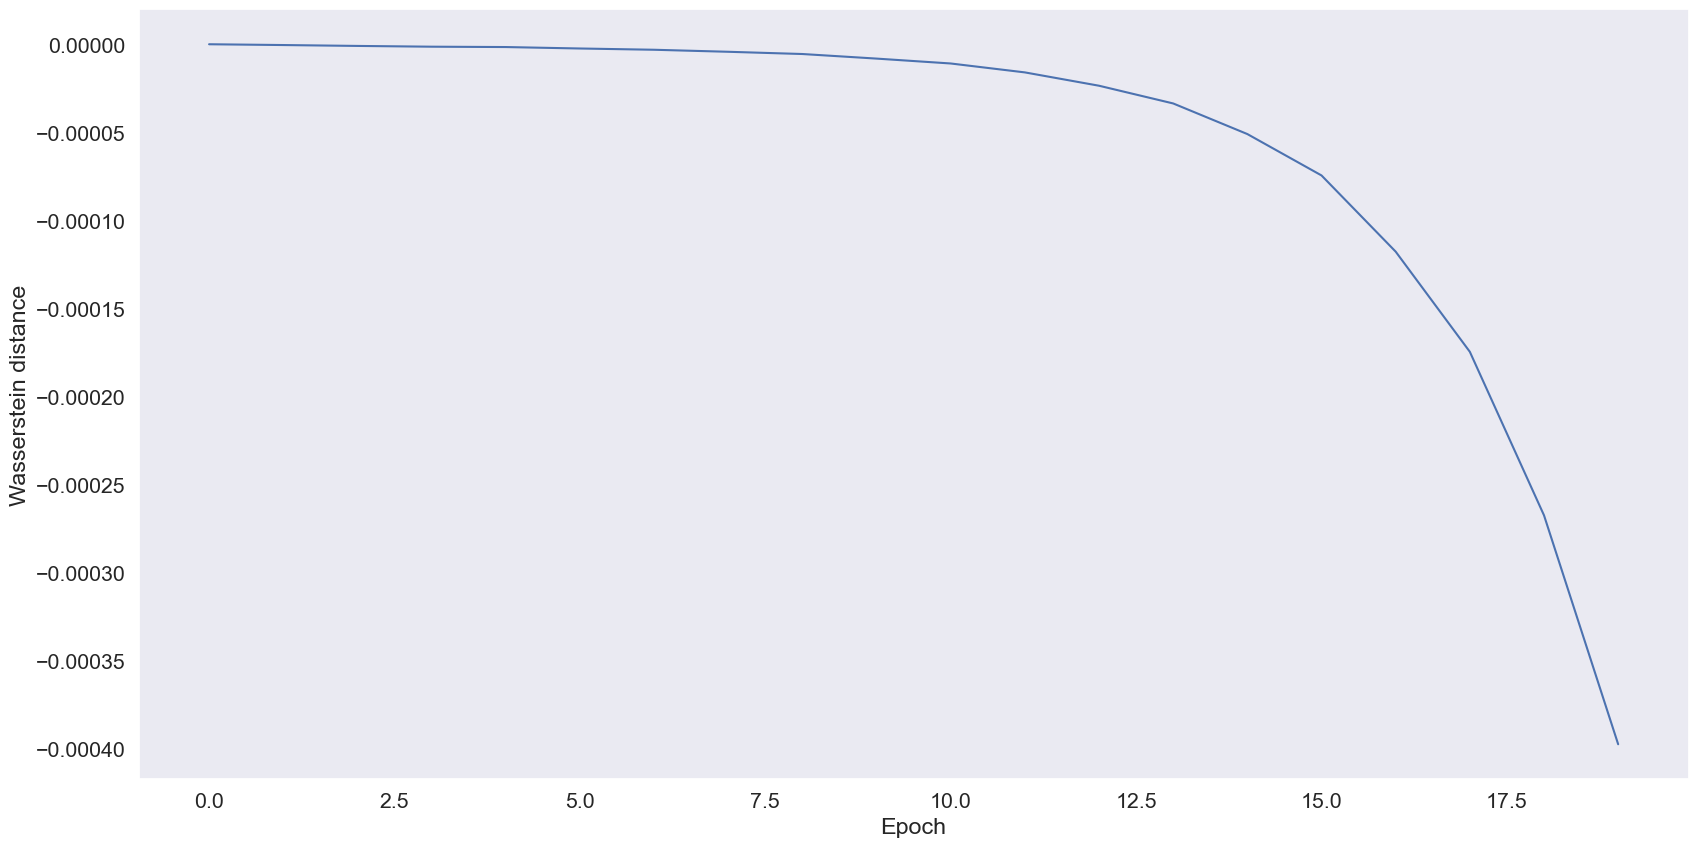

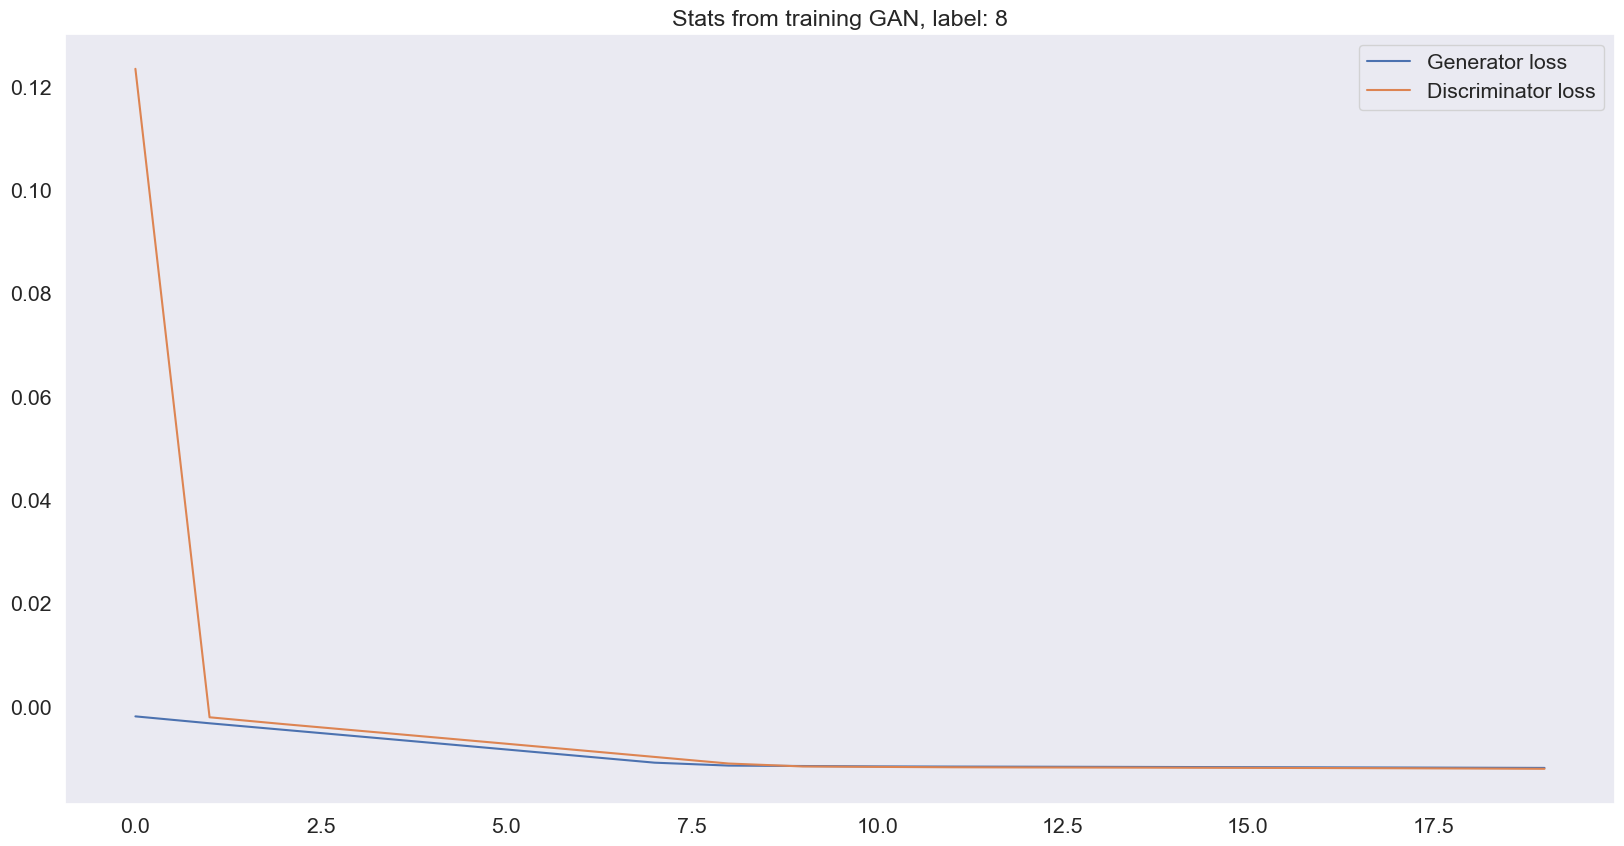

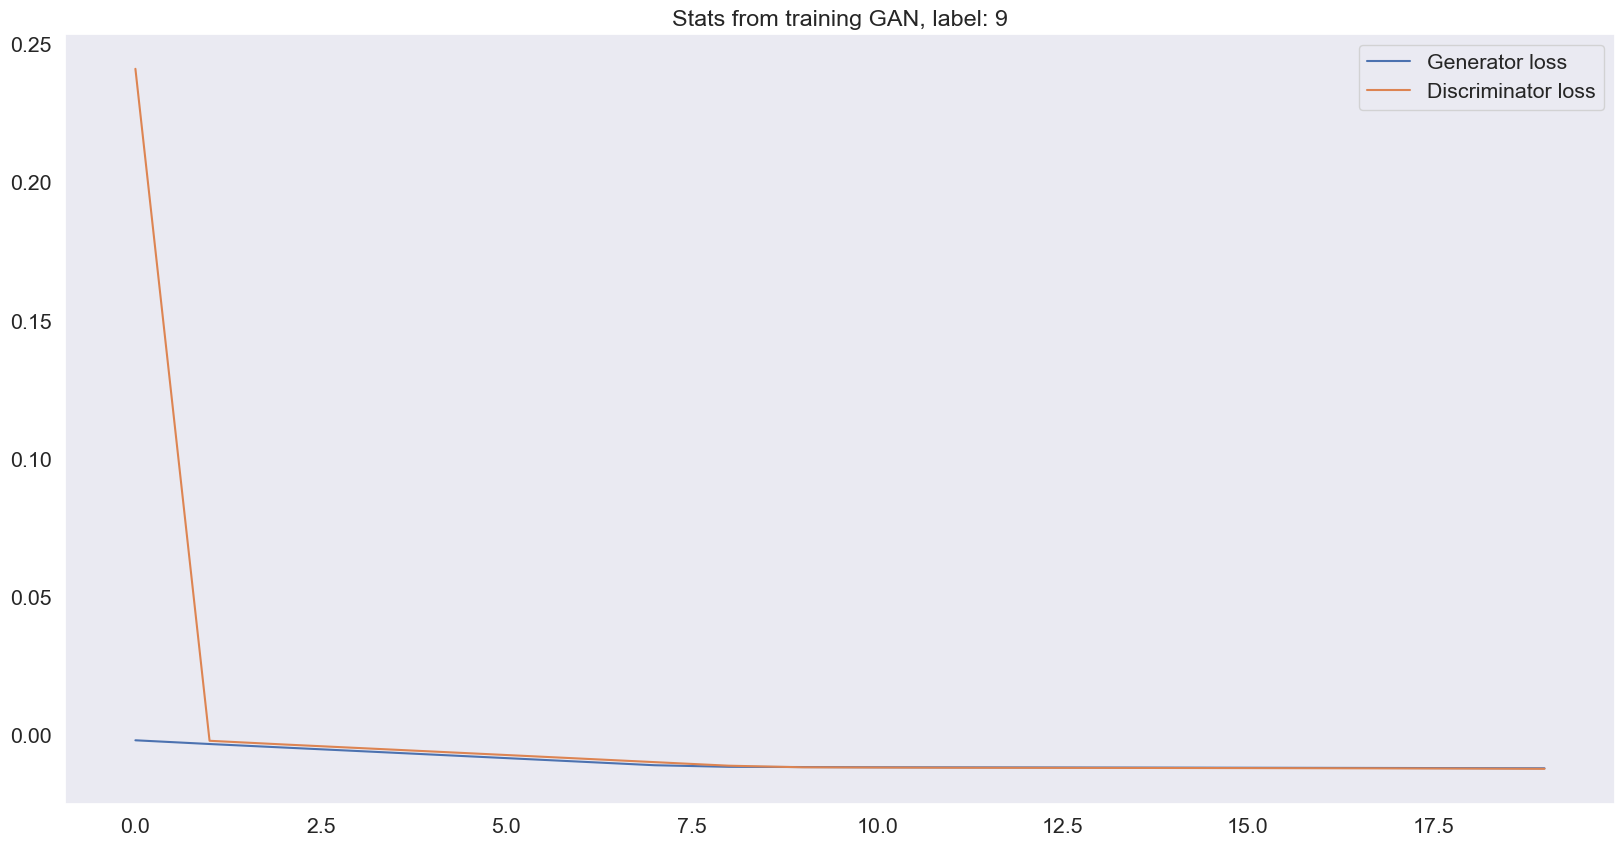

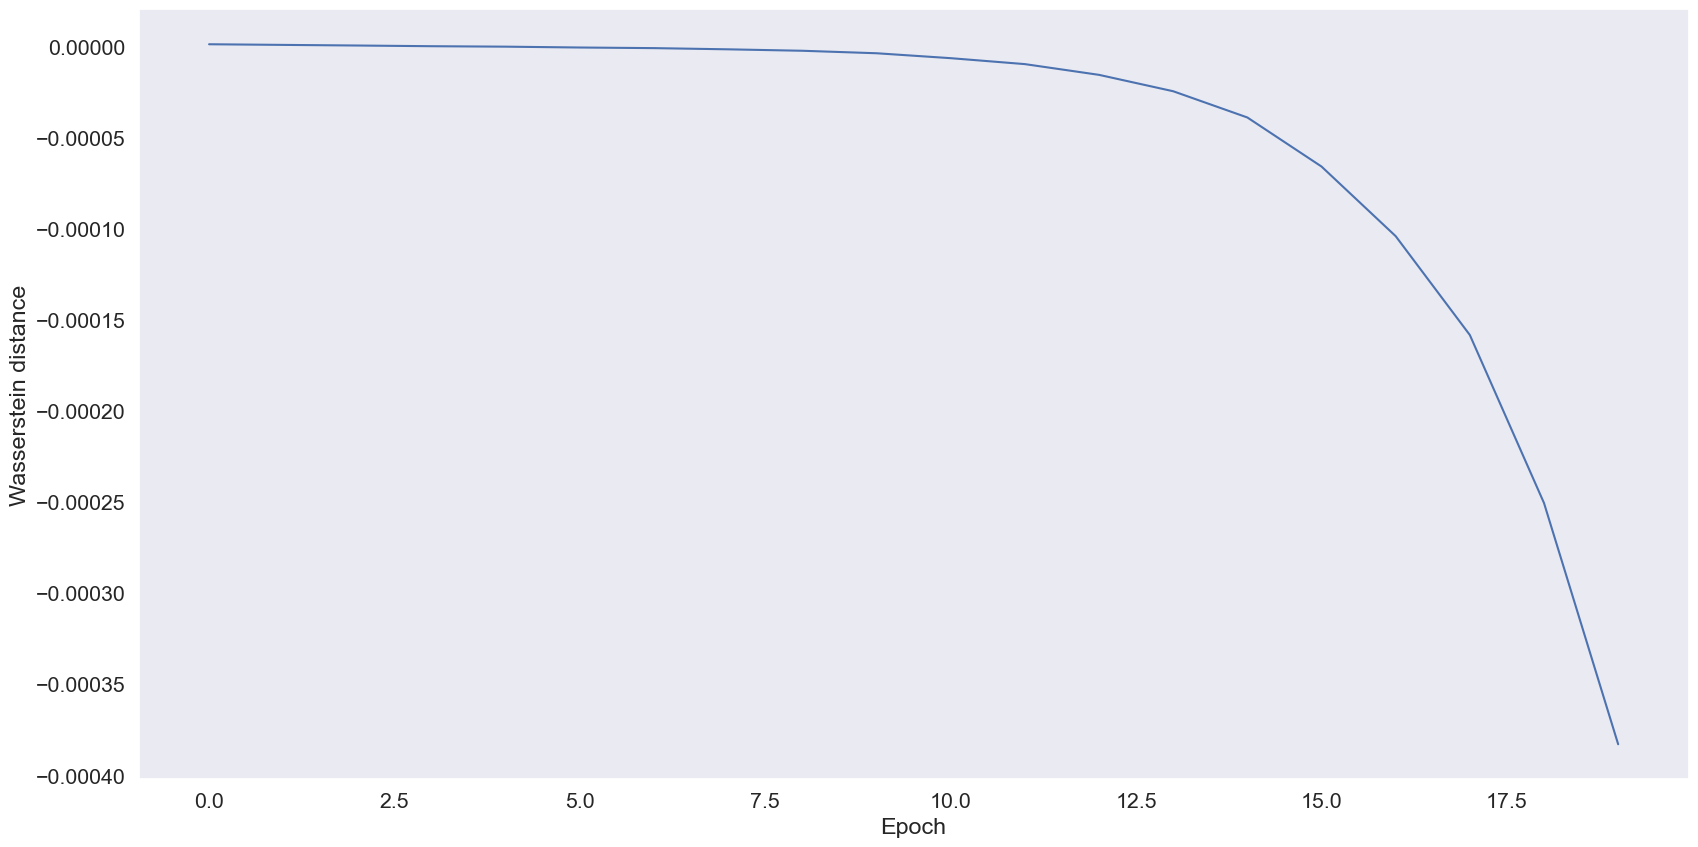

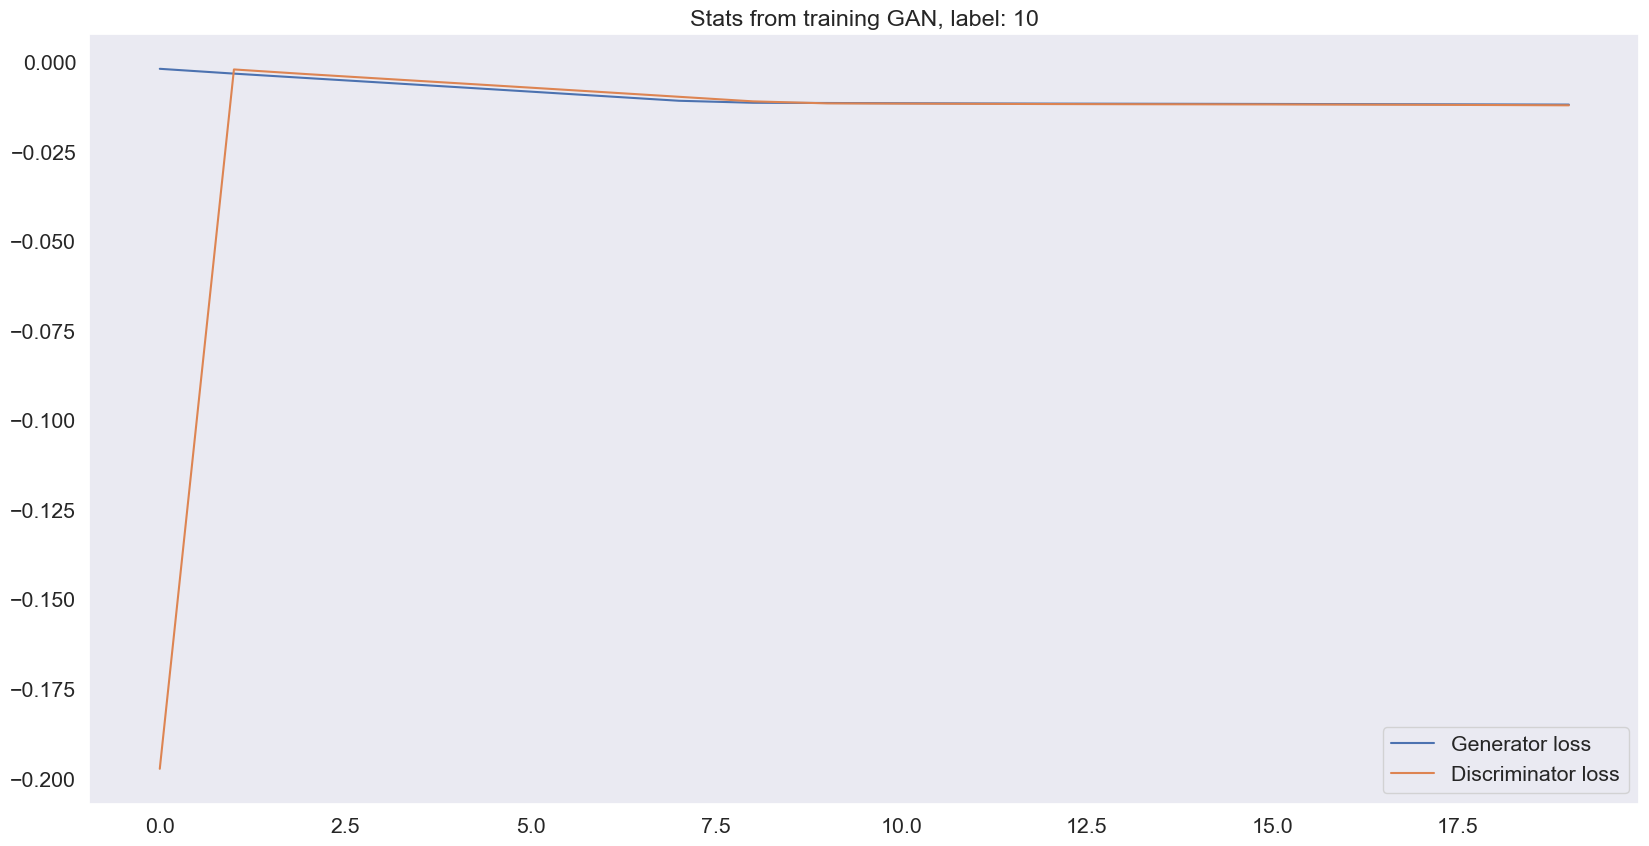

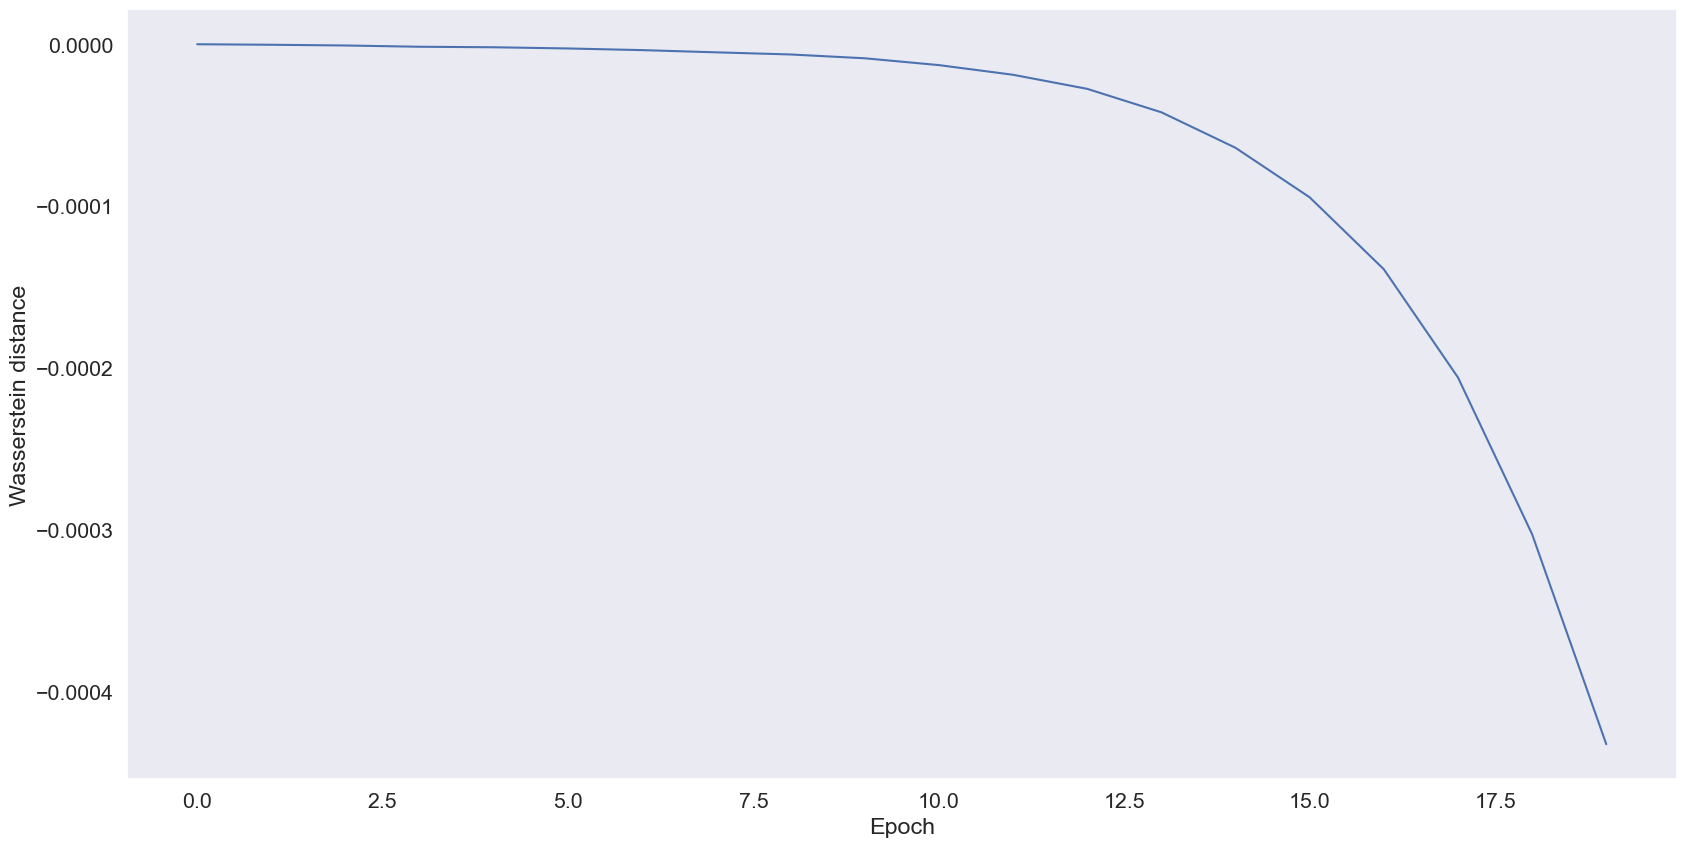

In [35]:
def convert_to_dataframe(arr, c):
    """Convert a numpy array to a pandas dataframe."""
    #print(features.columns)
    return pd.DataFrame(arr, columns=c)

def generate_fake_w(real_data, label, num_to_generate, input_dimension, latent_dim, c):
    """Generate synthetic data to balance the specified label."""
#     optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    w_optimizer = RMSprop(learning_rate=0.0001)
    w_generator = build_wgan_generator(input_dimension.shape[1], latent_dim)
    w_discriminator = build_wgan_discriminator(input_dimension.shape[1], w_optimizer)
    wgan = build_wgan(w_generator, w_discriminator, w_optimizer)
#     print(w_generator.layers[-1].output_shape)
#     print(w_discriminator.layers[0].input_shape)
#     print(wgan.input_shape)
#     # Calculate the number of batches
#     n_batches = real_data.shape[0] // 100
#     print('Batches = ', n_batches)
    train_wgan(w_generator, w_discriminator, wgan, real_data, latent_dim, n_epochs=20, n_batch=500, n_eval=250)

    # generate synthetic data to balance the label
    noise = np.random.normal(0, 1, (num_to_generate, latent_dim))
    gen_data = w_generator(noise)

    # convert numpy array to dataframe and add label column
    data_generated = convert_to_dataframe(min_max_scaler.inverse_transform(gen_data), c)
    data_generated['label'] = label
    
    return data_generated

# #split label and feature data 
# labels = data[['label']]
# labels = np.array(labels).ravel() # ensure it's a 1D array of shape (n_samples, )

# features = data.drop(columns=['label'])

# # print(features.columns)

# #encode labels to numbers
# LE = LabelEncoder()
# LE.fit(labels)
# # save the label encoder object to a file
# with open('label_encoder.pkl', 'wb') as f:
#     pickle.dump(LE, f)
    
# labels = LE.transform(labels)
# d = LE.inverse_transform(labels)
# d = pd.Series(d)

# # convert labels to a dataframe
# labels_df = lbl_df(labels)

# # print('\n\n\n\n\n')
# # print(labels_df.columns)

# # split data into train and test sets
# fts_train, fts_test, lbl_train, lbl_test = train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)

# # normalize feature data
# min_max_scaler = MinMaxScaler().fit(fts_train)
# fts_train_norm = min_max_scaler.transform(fts_train)
# fts_test_norm = min_max_scaler.transform(fts_test)

# # convert normalized feature data to dataframes
# fts_train_df = convert_to_dataframe(min_max_scaler.inverse_transform(fts_train_norm), features.columns)
# fts_test_df = convert_to_dataframe(min_max_scaler.inverse_transform(fts_test_norm), features.columns)

# # convert lbl_train to a dataframe
# lbl_train_df = convert_to_dataframe(lbl_train, ['label'])
# # concatenate fts_train_df and lbl_train_df along columns
# fts_train_df = pd.concat([fts_train_df, lbl_train_df], axis=1)

# # convert lbl_test to a dataframe
# lbl_test_df = convert_to_dataframe(lbl_test, ['label'])
# # concatenate fts_test_df and lbl_test_df along columns
# fts_test_df = pd.concat([fts_test_df, lbl_test_df], axis=1)

input_dimension = fts_test_df.drop(columns=['label'])

# get unique labels and their counts
unique_labels, label_counts = np.unique(fts_train_df['label'], return_counts=True)
target = label_counts.max()
print('Target distribution for test data =', target)

# generate synthetic data for each label with count less than the target count
fake_w_df = pd.DataFrame(columns=list(features.columns) + ['label'])
for label, count in zip(unique_labels, label_counts):
#     if count >= target:
#         continue
#     gen_num = target - count
#     print(f'Generating {gen_num} samples for label {label}')
    gen_num = target - count
    print(f'Generating {gen_num} samples for label {label}')
    if not gen_num:
        continue
    elif gen_num < 0:
        print('ERROR, ERROR: GEN_NUM IS NEGATIVE!')
    else:
        real_data = fts_train_df.loc[fts_train_df['label'] == label]
        fake_data_for_label_w = generate_fake_w(real_data, label, gen_num, input_dimension, latent_dim=32, c=features.columns)
        print(f'Generated {fake_data_for_label_w.shape[0]} samples for label {label}')
        fake_w_df = fake_w_df.append(fake_data_for_label_w, ignore_index=True)

In [38]:
fake_w_df

destination_port  flow_duration  total_fwd_packets  \
0                  -53997      -63795323            -144154   
1                  -24075      -34113166            -158827   
2                  -43222      -32468525            -105693   
3                  -20749      -38431100             -98293   
4                  -35856       -4434496             -44979   
...                   ...            ...                ...   
1223875            -31816      -48872049             -93824   
1223876            -39312       48685151             -32974   
1223877            -21708      -18850747             -61293   
1223878            -18526       46108134             -77295   
1223879            -39364        2199508            -103207   

         total_backward_packets  total_length_of_fwd_packets  \
0                        -35143                       660902   
1                         88223                         1196   
2                         60118                       400231   
3                        162692                       711925   
4                        136660                       849555   
...                         ...                          ...   
1223875                  220627                       227113   
1223876                  217510                      -225885   
1223877                  235776                       331367   
1223878                  228217                       -54617   
1223879                  240733                      -271490   

         total_length_of_bwd_packets  fwd_packet_length_max  \
0                          -96768980                   6178   
1                          -77569318                   9900   
2                           45403258                   6399   
3                         -115493209                  15926   
4                           91105905                  10315   
...                              ...                    ...   
1223875                    172889439                  13665   
1223876                    -82258051                   5702   
1223877                     22855570                  11514   
1223878                   -124754576                  11997   
1223879                    139942318                  10317   

         fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
0                         1172             2152.537428           -4986.685295   
1                         1079             2027.484120           -2192.257892   
2                         1713             -738.630216           -4326.586256   
3                         1263             -427.095636           -3198.014497   
4                         1529             -516.201193           -4446.467704   
...                        ...                     ...                    ...   
1223875                  -1093             5211.581258           -3477.896915   
1223876                  -1279             4629.875186           -3328.322529   
1223877                   -939             5217.069849           -1007.821061   
1223878                  -1114             4563.034764           -4648.971462   
1223879                  -1144             4557.603891           -3090.753819   

         ...  min_seg_size_forward   active_mean    active_std  active_max  \
0        ...            -706829167 -6.794074e+06 -1.822816e+06   -48535631   
1        ...            -747451207  2.590012e+06  2.458705e+06   -57649651   
2        ...            -459919884  1.240434e+07 -2.897702e+07   -57298565   
3        ...            -785013823 -1.166232e+07 -2.068405e+07   -68079290   
4        ...            -488722174 -8.552351e+06 -1.462327e+07   -65019761   
...      ...                   ...           ...           ...         ...   
1223875  ...            -477723816  9.795753e+06 -1.114253e+06    11168212   
1223876  ...            -274725899  1.775373e+07  2.930565e+07    44688862   
1223877  ...            -348634699  1.898214e+07  3

In [37]:
# Make sure the column types of generated data is correct
fake_w_df = fake_w_df.astype(data.dtypes.to_dict())
fake_w_df['label'] = fake_w_df['label'].astype('int64')
fake_w_df

destination_port  flow_duration  total_fwd_packets  \
0                  -53997      -63795323            -144154   
1                  -24075      -34113166            -158827   
2                  -43222      -32468525            -105693   
3                  -20749      -38431100             -98293   
4                  -35856       -4434496             -44979   
...                   ...            ...                ...   
1223875            -31816      -48872049             -93824   
1223876            -39312       48685151             -32974   
1223877            -21708      -18850747             -61293   
1223878            -18526       46108134             -77295   
1223879            -39364        2199508            -103207   

         total_backward_packets  total_length_of_fwd_packets  \
0                        -35143                       660902   
1                         88223                         1196   
2                         60118                       400231   
3                        162692                       711925   
4                        136660                       849555   
...                         ...                          ...   
1223875                  220627                       227113   
1223876                  217510                      -225885   
1223877                  235776                       331367   
1223878                  228217                       -54617   
1223879                  240733                      -271490   

         total_length_of_bwd_packets  fwd_packet_length_max  \
0                          -96768980                   6178   
1                          -77569318                   9900   
2                           45403258                   6399   
3                         -115493209                  15926   
4                           91105905                  10315   
...                              ...                    ...   
1223875                    172889439                  13665   
1223876                    -82258051                   5702   
1223877                     22855570                  11514   
1223878                   -124754576                  11997   
1223879                    139942318                  10317   

         fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
0                         1172             2152.537428           -4986.685295   
1                         1079             2027.484120           -2192.257892   
2                         1713             -738.630216           -4326.586256   
3                         1263             -427.095636           -3198.014497   
4                         1529             -516.201193           -4446.467704   
...                        ...                     ...                    ...   
1223875                  -1093             5211.581258           -3477.896915   
1223876                  -1279             4629.875186           -3328.322529   
1223877                   -939             5217.069849           -1007.821061   
1223878                  -1114             4563.034764           -4648.971462   
1223879                  -1144             4557.603891           -3090.753819   

         ...  min_seg_size_forward   active_mean    active_std  active_max  \
0        ...            -706829167 -6.794074e+06 -1.822816e+06   -48535631   
1        ...            -747451207  2.590012e+06  2.458705e+06   -57649651   
2        ...            -459919884  1.240434e+07 -2.897702e+07   -57298565   
3        ...            -785013823 -1.166232e+07 -2.068405e+07   -68079290   
4        ...            -488722174 -8.552351e+06 -1.462327e+07   -65019761   
...      ...                   ...           ...           ...         ...   
1223875  ...            -477723816  9.795753e+06 -1.114253e+06    11168212   
1223876  ...            -274725899  1.775373e+07  2.930565e+07    44688862   
1223877  ...            -348634699  1.898214e+07  3

In [39]:
# SAVE fake_data_df
output_path = 'aug_data_2.csv'
# fake_data_df.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
fake_w_df.to_csv(output_path)

In [157]:
# # SAVE TRAINING SET AND TEST SET
# output_path = 'fts_train_df.csv'
# fts_train_df.to_csv(output_path)

# output_path = 'fts_test_df.csv'
# fts_test_df.to_csv(output_path)

# # MAKE SURE EVERYTHING YOU NEED IS SAVED BEFORE CONTINUING WITH THE IDS OR OTHER MODEL

In [73]:
from keras.optimizers import RMSprop
from keras.backend import clip
from keras import backend as K

def build_wgan_generator_2(n_columns, latent_dim):
    model = Sequential([
        Dense(128, kernel_initializer="he_uniform", input_dim=latent_dim),
        LeakyReLU(0.2),
        layers.Dropout(0.5),
        BatchNormalization(momentum=0.8),
        Dense(256, kernel_initializer="he_uniform"),
        LeakyReLU(0.2),
        layers.Dropout(0.5),
        BatchNormalization(momentum=0.8),
#         Dense(512, kernel_initializer="he_uniform"),
#         LeakyReLU(0.2),
#         layers.Dropout(0.5),
#         BatchNormalization(momentum=0.8),
        Dense(512, kernel_initializer="he_uniform"),
        LeakyReLU(0.2),
        layers.Dropout(0.5),
        BatchNormalization(momentum=0.8),
        Dense(1024, kernel_initializer="he_uniform"),
        LeakyReLU(0.2),
        layers.Dropout(0.5),
        BatchNormalization(momentum=0.8),
        Dense(n_columns, activation="relu")
    ])
    return model

def build_wgan_discriminator_2(n_columns, optimizer, clip_value=0.01):
    model = Sequential([
        Dense(128, kernel_initializer="he_uniform", input_dim=n_columns),
        LeakyReLU(0.2),
#         Dense(256, kernel_initializer="he_uniform"),
#         LeakyReLU(0.2),
#         Dense(128, kernel_initializer="he_uniform"),
#         LeakyReLU(0.2),
        BatchNormalization(momentum=0.8),
        Dense(32, kernel_initializer="he_uniform"),
        LeakyReLU(0.2),
        BatchNormalization(momentum=0.8),
        Dense(8, kernel_initializer="he_uniform"),
        LeakyReLU(0.2),
        Dense(1)
    ])
    model.compile(loss=wasserstein_loss_2, optimizer=optimizer)
    return model

def wasserstein_loss_2(lbl_true, lbl_pred):
    return -K.mean(lbl_true * lbl_pred)

def build_wgan_2(generator, discriminator, optimizer):
    model = Sequential([generator, discriminator])
    model.compile(loss=wasserstein_loss_2, optimizer=optimizer)
    return model

def generate_fake_samples_2(generator, latent_dim, n_samples):
    fts_input = generate_latent_points_2(latent_dim, n_samples)
    fts = generator.predict(fts_input)
    lbl = -np.ones((n_samples, 1))
    return fts, lbl

def generate_latent_points_2(latent_dim, n_samples):
    x_input = np.random.randn(n_samples, latent_dim)
    return x_input

def compute_wasserstein_distance_2(generator, discriminator, real_samples, latent_dim, n_samples):
    # Generate fake samples
    fake_samples = generator.predict(np.random.randn(n_samples, latent_dim))
    # Compute discriminator scores for real and fake samples
    real_scores = discriminator.predict(real_samples)
    fake_scores = discriminator.predict(fake_samples)
    # Compute Wasserstein distance
    wasserstein_distance = tf.reduce_mean(fake_scores) - tf.reduce_mean(real_scores)
    return wasserstein_distance

def train_wgan_2(generator, discriminator, gan, data, latent_dim, n_epochs, n_batch, n_eval):
    d_loss = []
    g_loss = []
    wasser = []
    half_batch = int(n_batch / 2)
    
    lbl = data['label'].unique()[0]
    print(f'GAN training of label: {lbl}, samples = {data.shape[0]}')
    
    data = data.drop(columns=['label'])
    data = min_max_scaler.transform(data)
    data = convert_to_dataframe(data, features.columns)
    
    clip_value = 0.01
    
    for i in range(n_epochs):
        
        idx = np.random.choice(data.shape[0], half_batch, replace=False)
        fts_real = data.iloc[idx]
        fts_fake, lbl_fake = generate_fake_samples_2(generator, latent_dim, half_batch)
        lbl_real = -np.ones((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(fts_real, lbl_real)
        d_loss_fake = discriminator.train_on_batch(fts_fake, lbl_fake)
        d_loss_epoch = 0.5 * np.add(d_loss_real, d_loss_fake)

        for l in discriminator.layers:
            weights = l.get_weights()
            weights = [clip(w, -clip_value, clip_value) for w in weights]
            l.set_weights(weights)
        for j in range(3):
            fts_gan = generate_latent_points_2(latent_dim, n_batch)
            lbl_gan = -np.ones((n_batch, 1))
            g_loss_epoch = gan.train_on_batch(fts_gan, lbl_gan)

        d_loss.append(d_loss_epoch)
        g_loss.append(g_loss_epoch)
        
        wasserstein_distance = compute_wasserstein_distance_2(generator, discriminator, fts_real, latent_dim, n_batch)
        wasser.append(wasserstein_distance)
        
        print("Epoch {}: Generator loss={}, Discriminator loss={}, Wasserstein distance={}".format(i, g_loss_epoch, d_loss_epoch, wasserstein_distance))
#         print (f"Label: {lbl} Epoch: %d [Generator loss: %f] [Discriminator loss: %f]" % (j + 1, g_loss_epoch, d_loss_epoch))

    #plot losses after training
    plt.figure(figsize = (20, 10))
    plt.plot(g_loss, label = "Generator loss")
    plt.plot(d_loss, label = "Discriminator loss")
    plt.title(f"Stats from training GAN, label: {lbl}")
    plt.legend()
    plt.grid()
    
    #plot w distance after training
    plt.figure(figsize = (20, 10))
    plt.plot(range(n_epochs), wasser)
    plt.xlabel('Epoch')
    plt.ylabel('Wasserstein distance')
    plt.grid()
        
    return d_loss, g_loss


In [78]:
# from keras.optimizers import RMSprop
# from keras.backend import clip
# from keras import backend as K

# def build_wgan_generator_2(n_columns, latent_dim):
#     model = Sequential([
#         Dense(128, kernel_initializer="he_uniform", input_dim=latent_dim),
#         LeakyReLU(0.2),
#         layers.Dropout(0.5),
#         BatchNormalization(momentum=0.8),
#         Dense(256, kernel_initializer="he_uniform"),
#         LeakyReLU(0.2),
#         layers.Dropout(0.5),
#         BatchNormalization(momentum=0.8),
# #         Dense(512, kernel_initializer="he_uniform"),
# #         LeakyReLU(0.2),
# #         layers.Dropout(0.5),
# #         BatchNormalization(momentum=0.8),
#         Dense(512, kernel_initializer="he_uniform"),
#         LeakyReLU(0.2),
#         layers.Dropout(0.5),
#         BatchNormalization(momentum=0.8),
#         Dense(1024, kernel_initializer="he_uniform"),
#         LeakyReLU(0.2),
#         layers.Dropout(0.5),
#         BatchNormalization(momentum=0.8),
#         Dense(n_columns, activation="relu")
#     ])
#     return model

# def build_wgan_discriminator_2(n_columns, optimizer, clip_value=0.01):
#     model = Sequential([
#         Dense(128, kernel_initializer="he_uniform", input_dim=n_columns),
#         LeakyReLU(0.2),
# #         Dense(256, kernel_initializer="he_uniform"),
# #         LeakyReLU(0.2),
# #         Dense(128, kernel_initializer="he_uniform"),
# #         LeakyReLU(0.2),
#         BatchNormalization(momentum=0.8),
#         Dense(32, kernel_initializer="he_uniform"),
#         LeakyReLU(0.2),
#         BatchNormalization(momentum=0.8),
#         Dense(8, kernel_initializer="he_uniform"),
#         LeakyReLU(0.2),
#         Dense(1)
#     ])
#     model.compile(loss=wasserstein_loss_2, optimizer=optimizer)
#     return model

# def wasserstein_loss_2(lbl_true, lbl_pred):
#     return -K.mean(lbl_true * lbl_pred)

# def build_wgan_2(generator, discriminator, optimizer):
#     model = Sequential([generator, discriminator])
#     model.compile(loss=wasserstein_loss_2, optimizer=optimizer)
#     return model

# def generate_fake_samples_2(generator, latent_dim, n_samples):
#     fts_input = generate_latent_points_2(latent_dim, n_samples)
#     fts = generator.predict(fts_input)
#     lbl = -np.ones((n_samples, 1))
#     return fts, lbl

# def generate_latent_points_2(latent_dim, n_samples):
#     x_input = np.random.randn(n_samples, latent_dim)
#     return x_input

# def compute_wasserstein_distance_2(generator, discriminator, real_samples, latent_dim, n_samples):
#     # Generate fake samples
#     fake_samples = generator.predict(np.random.randn(n_samples, latent_dim))
#     # Compute discriminator scores for real and fake samples
#     real_scores = discriminator.predict(real_samples)
#     fake_scores = discriminator.predict(fake_samples)
#     # Compute Wasserstein distance
#     wasserstein_distance = tf.reduce_mean(fake_scores) - tf.reduce_mean(real_scores)
#     return wasserstein_distance

def train_wgan_x(generator, discriminator, gan, data, latent_dim, n_epochs, n_batch, n_eval):
    d_loss = []
    g_loss = []
    wasser = []
    half_batch = int(n_batch / 2)
    
    lbl = data['label'].unique()[0]
    print(f'GAN training of label: {lbl}, samples = {data.shape[0]}')
    
    data = data.drop(columns=['label'])
    data = min_max_scaler.transform(data)
    data = convert_to_dataframe(data, features.columns)
    
    clip_value = 0.01
    
    for i in range(n_epochs):
        
        idx = np.random.choice(data.shape[0], half_batch, replace=False)
        fts_real = data.iloc[idx]
        fts_fake, lbl_fake = generate_fake_samples_2(generator, latent_dim, half_batch)
        lbl_real = -np.ones((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(fts_real, lbl_real)
        d_loss_fake = discriminator.train_on_batch(fts_fake, lbl_fake)
        d_loss_epoch = 0.5 * np.add(d_loss_real, d_loss_fake)

        for l in discriminator.layers:
            weights = l.get_weights()
            weights = [clip(w, -clip_value, clip_value) for w in weights]
            l.set_weights(weights)
        
        fts_gan = generate_latent_points_2(latent_dim, n_batch)
        lbl_gan = -np.ones((n_batch, 1))
        g_loss_epoch = gan.train_on_batch(fts_gan, lbl_gan)

        d_loss.append(d_loss_epoch)
        g_loss.append(g_loss_epoch)
        
        wasserstein_distance = compute_wasserstein_distance_2(generator, discriminator, fts_real, latent_dim, n_batch)
        wasser.append(wasserstein_distance)
        
        print("Epoch {}: Generator loss={}, Discriminator loss={}, Wasserstein distance={}".format(i, g_loss_epoch, d_loss_epoch, wasserstein_distance))
#         print (f"Label: {lbl} Epoch: %d [Generator loss: %f] [Discriminator loss: %f]" % (j + 1, g_loss_epoch, d_loss_epoch))

    #plot losses after training
    plt.figure(figsize = (20, 10))
    plt.plot(g_loss, label = "Generator loss")
    plt.plot(d_loss, label = "Discriminator loss")
    plt.title(f"Stats from training GAN, label: {lbl}")
    plt.legend()
    plt.grid()
    
    #plot w distance after training
    plt.figure(figsize = (20, 10))
    plt.plot(range(n_epochs), wasser)
    plt.xlabel('Epoch')
    plt.ylabel('Wasserstein distance')
    plt.grid()
        
    return d_loss, g_loss


Target distribution for test data = 161087
Generating 2095 samples for label 0
GAN training of label: 0, samples = 158992
16/16 [==============================] - 0s 4ms/step
Epoch 0: Generator loss=-0.0005692887352779508, Discriminator loss=0.25276000052690506, Wasserstein distance=9.42964106798172e-09
16/16 [==============================] - 0s 4ms/step
Epoch 1: Generator loss=-0.0010893879225477576, Discriminator loss=-0.0008472316549159586, Wasserstein distance=-1.3969838619232178e-09
16/16 [==============================] - 0s 4ms/step
Epoch 2: Generator loss=-0.0015078512951731682, Discriminator loss=-0.0013053868897259235, Wasserstein distance=-1.7345882952213287e-08
16/16 [==============================] - 0s 4ms/step
Epoch 3: Generator loss=-0.001881901640444994, Discriminator loss=-0.0016983734094537795, Wasserstein distance=-3.213062882423401e-08
16/16 [==============================] - 0s 4ms/step
Epoch 4: Generator loss=-0.0022315438836812973, Discriminator loss=-0.0020587

16/16 [==============================] - 0s 4ms/step
Epoch 23: Generator loss=-0.008173939771950245, Discriminator loss=-0.008019746746867895, Wasserstein distance=-1.0151416063308716e-07
16/16 [==============================] - 0s 4ms/step
Epoch 24: Generator loss=-0.008485237136483192, Discriminator loss=-0.008331256918609142, Wasserstein distance=-1.0151416063308716e-07
16/16 [==============================] - 0s 4ms/step
Epoch 25: Generator loss=-0.008796725422143936, Discriminator loss=-0.00864297617226839, Wasserstein distance=-9.778887033462524e-08
16/16 [==============================] - 0s 5ms/step
Epoch 26: Generator loss=-0.009108390659093857, Discriminator loss=-0.008954874239861965, Wasserstein distance=-1.0151416063308716e-07
16/16 [==============================] - 0s 8ms/step
Epoch 27: Generator loss=-0.009420224465429783, Discriminator loss=-0.009266932494938374, Wasserstein distance=-1.0058283805847168e-07
16/16 [==============================] - 0s 4ms/step
Epoch 28:

16/16 [==============================] - 0s 4ms/step
Epoch 17: Generator loss=-0.006370913702994585, Discriminator loss=-0.0062148175202310085, Wasserstein distance=-1.1781230568885803e-07
16/16 [==============================] - 0s 4ms/step
Epoch 18: Generator loss=-0.006684822030365467, Discriminator loss=-0.0065284776501357555, Wasserstein distance=-1.1455267667770386e-07
16/16 [==============================] - 0s 4ms/step
Epoch 19: Generator loss=-0.0069995964877307415, Discriminator loss=-0.0068430297542363405, Wasserstein distance=-1.1734664440155029e-07
16/16 [==============================] - 0s 3ms/step
Epoch 20: Generator loss=-0.007315251510590315, Discriminator loss=-0.007158509222790599, Wasserstein distance=-1.1315569281578064e-07
16/16 [==============================] - 0s 7ms/step
Epoch 21: Generator loss=-0.007631773129105568, Discriminator loss=-0.007474921178072691, Wasserstein distance=-1.2200325727462769e-07
16/16 [==============================] - 0s 4ms/step
Epo

16/16 [==============================] - 0s 4ms/step
Epoch 10: Generator loss=-0.004150545224547386, Discriminator loss=-0.003995433449745178, Wasserstein distance=8.847564458847046e-08
16/16 [==============================] - 0s 4ms/step
Epoch 11: Generator loss=-0.00446002371609211, Discriminator loss=-0.004305415786802769, Wasserstein distance=8.754432201385498e-08
16/16 [==============================] - 0s 3ms/step
Epoch 12: Generator loss=-0.004768868442624807, Discriminator loss=-0.0046145496889948845, Wasserstein distance=8.66129994392395e-08
16/16 [==============================] - 0s 4ms/step
Epoch 13: Generator loss=-0.005077417939901352, Discriminator loss=-0.004923239350318909, Wasserstein distance=9.033828973770142e-08
16/16 [==============================] - 0s 4ms/step
Epoch 14: Generator loss=-0.005385908298194408, Discriminator loss=-0.005231771152466536, Wasserstein distance=8.89413058757782e-08
16/16 [==============================] - 0s 4ms/step
Epoch 15: Generator

16/16 [==============================] - 0s 4ms/step
Epoch 4: Generator loss=-0.002231748541817069, Discriminator loss=-0.0020583210280165076, Wasserstein distance=-6.239861249923706e-08
16/16 [==============================] - 0s 3ms/step
Epoch 5: Generator loss=-0.0025678754318505526, Discriminator loss=-0.0024011158384382725, Wasserstein distance=-7.613562047481537e-08
16/16 [==============================] - 0s 5ms/step
Epoch 6: Generator loss=-0.002894441597163677, Discriminator loss=-0.002732020220719278, Wasserstein distance=-8.12578946352005e-08
16/16 [==============================] - 0s 4ms/step
Epoch 7: Generator loss=-0.0032146486919373274, Discriminator loss=-0.003055131994187832, Wasserstein distance=-9.42964106798172e-08
16/16 [==============================] - 0s 4ms/step
Epoch 8: Generator loss=-0.0035305474884808064, Discriminator loss=-0.003373008337803185, Wasserstein distance=-9.336508810520172e-08
16/16 [==============================] - 0s 3ms/step
Epoch 9: Gener

16/16 [==============================] - 0s 4ms/step
Epoch 28: Generator loss=-0.009694226086139679, Discriminator loss=-0.009542295709252357, Wasserstein distance=-1.2014061212539673e-07
16/16 [==============================] - 0s 4ms/step
Epoch 29: Generator loss=-0.010003143921494484, Discriminator loss=-0.009851274080574512, Wasserstein distance=-1.2014061212539673e-07
Generated 153882 samples for label 3
Generating 0 samples for label 4
Generating 157238 samples for label 5
GAN training of label: 5, samples = 3849
16/16 [==============================] - 0s 4ms/step
Epoch 0: Generator loss=-0.0005739322514273226, Discriminator loss=0.31868142634630203, Wasserstein distance=-2.3690517991781235e-08
16/16 [==============================] - 0s 4ms/step
Epoch 1: Generator loss=-0.001097503467462957, Discriminator loss=-0.0008535852830391377, Wasserstein distance=-2.0838342607021332e-08
16/16 [==============================] - 0s 4ms/step
Epoch 2: Generator loss=-0.0015196650056168437, 

16/16 [==============================] - 0s 4ms/step
Epoch 21: Generator loss=-0.00763509888201952, Discriminator loss=-0.007480272790417075, Wasserstein distance=1.1548399925231934e-07
16/16 [==============================] - 0s 3ms/step
Epoch 22: Generator loss=-0.007948648184537888, Discriminator loss=-0.007794140139594674, Wasserstein distance=1.1175870895385742e-07
16/16 [==============================] - 0s 4ms/step
Epoch 23: Generator loss=-0.008262382820248604, Discriminator loss=-0.008108216803520918, Wasserstein distance=1.1455267667770386e-07
16/16 [==============================] - 0s 4ms/step
Epoch 24: Generator loss=-0.008576303720474243, Discriminator loss=-0.008422479499131441, Wasserstein distance=1.1548399925231934e-07
16/16 [==============================] - 0s 3ms/step
Epoch 25: Generator loss=-0.008890409022569656, Discriminator loss=-0.008736916817724705, Wasserstein distance=1.1827796697616577e-07
16/16 [==============================] - 0s 4ms/step
Epoch 26: Gen

16/16 [==============================] - 0s 4ms/step
Epoch 15: Generator loss=-0.005712626501917839, Discriminator loss=-0.005557371769100428, Wasserstein distance=4.936009645462036e-08
16/16 [==============================] - 0s 4ms/step
Epoch 16: Generator loss=-0.006024009082466364, Discriminator loss=-0.005868379259482026, Wasserstein distance=4.6566128730773926e-08
16/16 [==============================] - 0s 3ms/step
Epoch 17: Generator loss=-0.006336311809718609, Discriminator loss=-0.006180281052365899, Wasserstein distance=4.7031790018081665e-08
16/16 [==============================] - 0s 4ms/step
Epoch 18: Generator loss=-0.006649582646787167, Discriminator loss=-0.006493161665275693, Wasserstein distance=4.889443516731262e-08
16/16 [==============================] - 0s 4ms/step
Epoch 19: Generator loss=-0.006963817868381739, Discriminator loss=-0.006807052297517657, Wasserstein distance=4.516914486885071e-08
16/16 [==============================] - 0s 4ms/step
Epoch 20: Gener

16/16 [==============================] - 0s 3ms/step
Epoch 8: Generator loss=-0.0035317346919327974, Discriminator loss=-0.0033747530542314053, Wasserstein distance=-5.727633833885193e-08
16/16 [==============================] - 0s 4ms/step
Epoch 9: Generator loss=-0.003843750339001417, Discriminator loss=-0.003687990363687277, Wasserstein distance=-4.516914486885071e-08
16/16 [==============================] - 0s 4ms/step
Epoch 10: Generator loss=-0.004154071677476168, Discriminator loss=-0.003999069333076477, Wasserstein distance=-3.818422555923462e-08
16/16 [==============================] - 0s 4ms/step
Epoch 11: Generator loss=-0.004463427234441042, Discriminator loss=-0.004308844916522503, Wasserstein distance=-3.073364496231079e-08
16/16 [==============================] - 0s 4ms/step
Epoch 12: Generator loss=-0.004772347863763571, Discriminator loss=-0.004617940867319703, Wasserstein distance=-3.166496753692627e-08
16/16 [==============================] - 0s 4ms/step
Epoch 13: Ge

16/16 [==============================] - 0s 4ms/step
Epoch 2: Generator loss=-0.001510123023763299, Discriminator loss=-0.0013066504034213722, Wasserstein distance=-2.735760062932968e-08
16/16 [==============================] - 0s 4ms/step
Epoch 3: Generator loss=-0.0018863175064325333, Discriminator loss=-0.0017017009085975587, Wasserstein distance=-4.330649971961975e-08
16/16 [==============================] - 0s 4ms/step
Epoch 4: Generator loss=-0.002238247077912092, Discriminator loss=-0.0020643299212679267, Wasserstein distance=-5.727633833885193e-08
16/16 [==============================] - 0s 3ms/step
Epoch 5: Generator loss=-0.0025754484813660383, Discriminator loss=-0.0024081397568807006, Wasserstein distance=-7.101334631443024e-08
16/16 [==============================] - 0s 4ms/step
Epoch 6: Generator loss=-0.0029032158199697733, Discriminator loss=-0.0027401820989325643, Wasserstein distance=-8.568167686462402e-08
16/16 [==============================] - 0s 4ms/step
Epoch 7: 

16/16 [==============================] - 0s 3ms/step
Epoch 26: Generator loss=-0.009140358306467533, Discriminator loss=-0.00898755993694067, Wasserstein distance=-1.2293457984924316e-07
16/16 [==============================] - 0s 5ms/step
Epoch 27: Generator loss=-0.00945213157683611, Discriminator loss=-0.009299522265791893, Wasserstein distance=-1.1734664440155029e-07
16/16 [==============================] - 0s 4ms/step
Epoch 28: Generator loss=-0.00976404920220375, Discriminator loss=-0.009611617308109999, Wasserstein distance=-1.1362135410308838e-07
16/16 [==============================] - 0s 4ms/step
Epoch 29: Generator loss=-0.010076102800667286, Discriminator loss=-0.0099238445982337, Wasserstein distance=-1.1920928955078125e-07
Generated 49924 samples for label 8
Generating 156959 samples for label 9
GAN training of label: 9, samples = 4128
16/16 [==============================] - 0s 4ms/step
Epoch 0: Generator loss=-0.0005701615009456873, Discriminator loss=0.2933845482766628

16/16 [==============================] - 0s 4ms/step
Epoch 19: Generator loss=-0.006937302649021149, Discriminator loss=-0.006782981799915433, Wasserstein distance=-7.171183824539185e-08
16/16 [==============================] - 0s 3ms/step
Epoch 20: Generator loss=-0.007247226778417826, Discriminator loss=-0.00709293526597321, Wasserstein distance=-7.636845111846924e-08
16/16 [==============================] - 0s 3ms/step
Epoch 21: Generator loss=-0.0075574214570224285, Discriminator loss=-0.007403194671496749, Wasserstein distance=-6.845220923423767e-08
16/16 [==============================] - 0s 4ms/step
Epoch 22: Generator loss=-0.007867883890867233, Discriminator loss=-0.0077137574553489685, Wasserstein distance=-6.984919309616089e-08
16/16 [==============================] - 0s 3ms/step
Epoch 23: Generator loss=-0.008178609423339367, Discriminator loss=-0.008024614304304123, Wasserstein distance=-7.543712854385376e-08
16/16 [==============================] - 0s 3ms/step
Epoch 24: G

16/16 [==============================] - 0s 4ms/step
Epoch 13: Generator loss=-0.005116308573633432, Discriminator loss=-0.004961361410096288, Wasserstein distance=1.0244548320770264e-07
16/16 [==============================] - 0s 4ms/step
Epoch 14: Generator loss=-0.005426693707704544, Discriminator loss=-0.005271814297884703, Wasserstein distance=9.73232090473175e-08
16/16 [==============================] - 0s 4ms/step
Epoch 15: Generator loss=-0.005737230181694031, Discriminator loss=-0.005582358222454786, Wasserstein distance=1.0384246706962585e-07
16/16 [==============================] - 0s 4ms/step
Epoch 16: Generator loss=-0.006048035807907581, Discriminator loss=-0.005893142893910408, Wasserstein distance=1.0384246706962585e-07
16/16 [==============================] - 0s 4ms/step
Epoch 17: Generator loss=-0.006359177641570568, Discriminator loss=-0.006204263074323535, Wasserstein distance=1.019798219203949e-07
16/16 [==============================] - 0s 4ms/step
Epoch 18: Gener

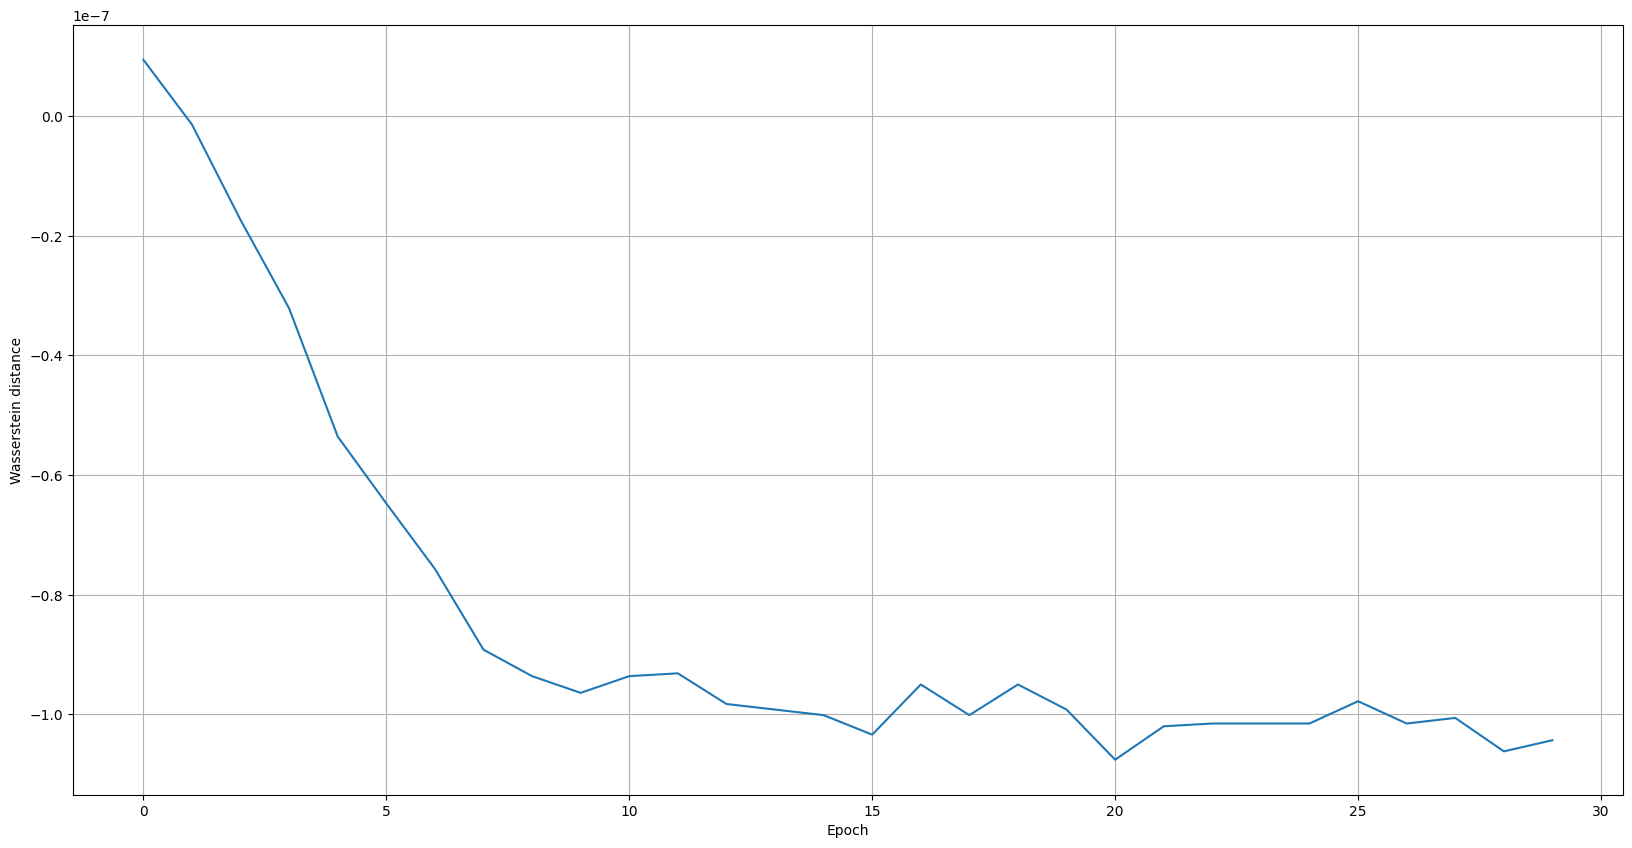

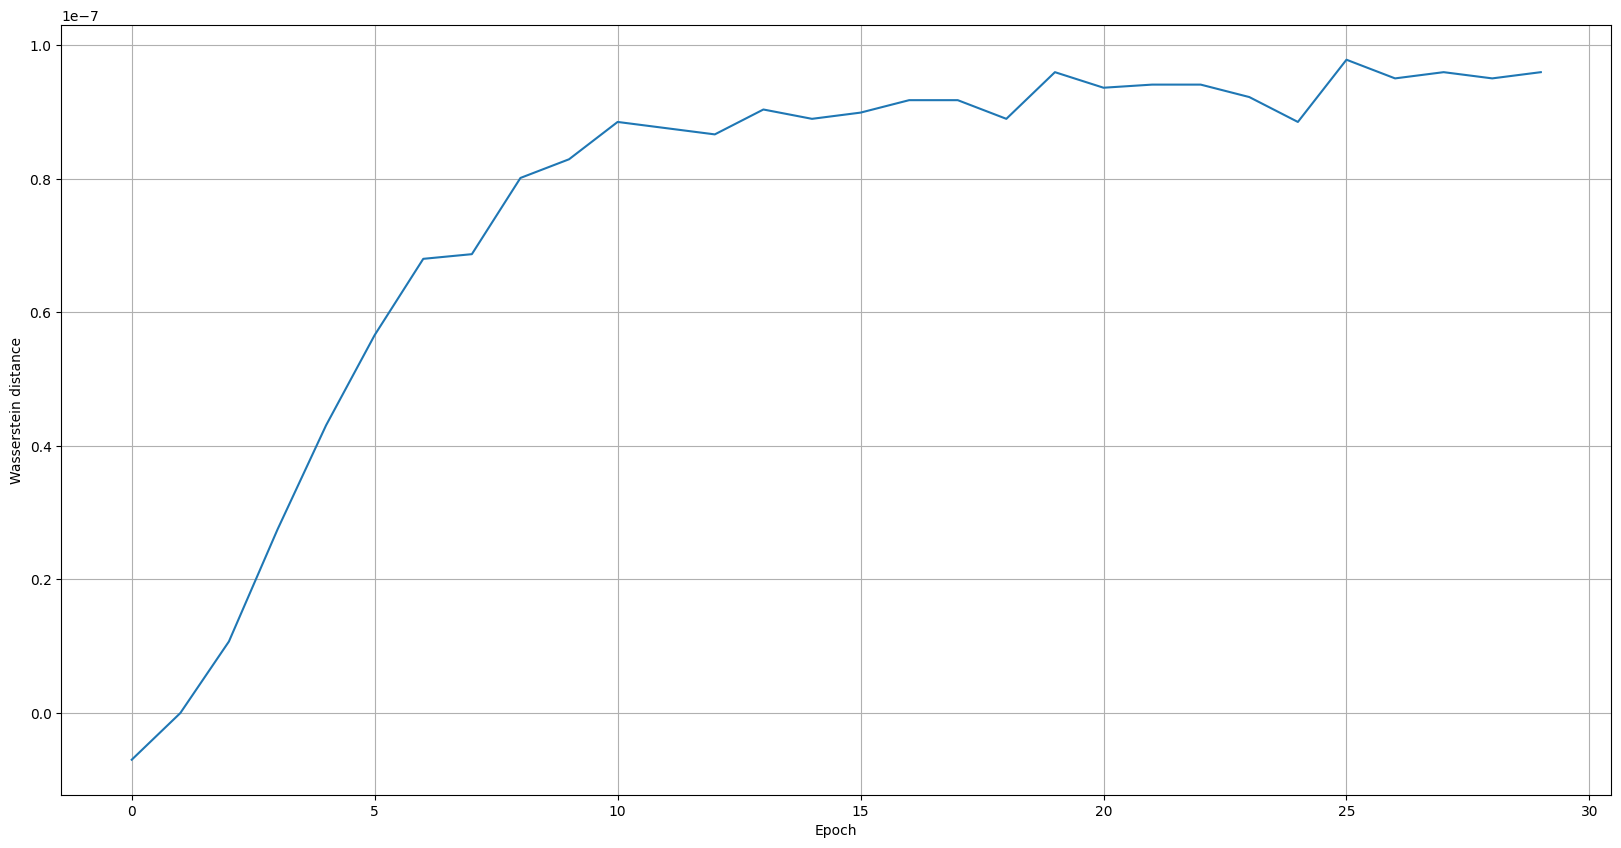

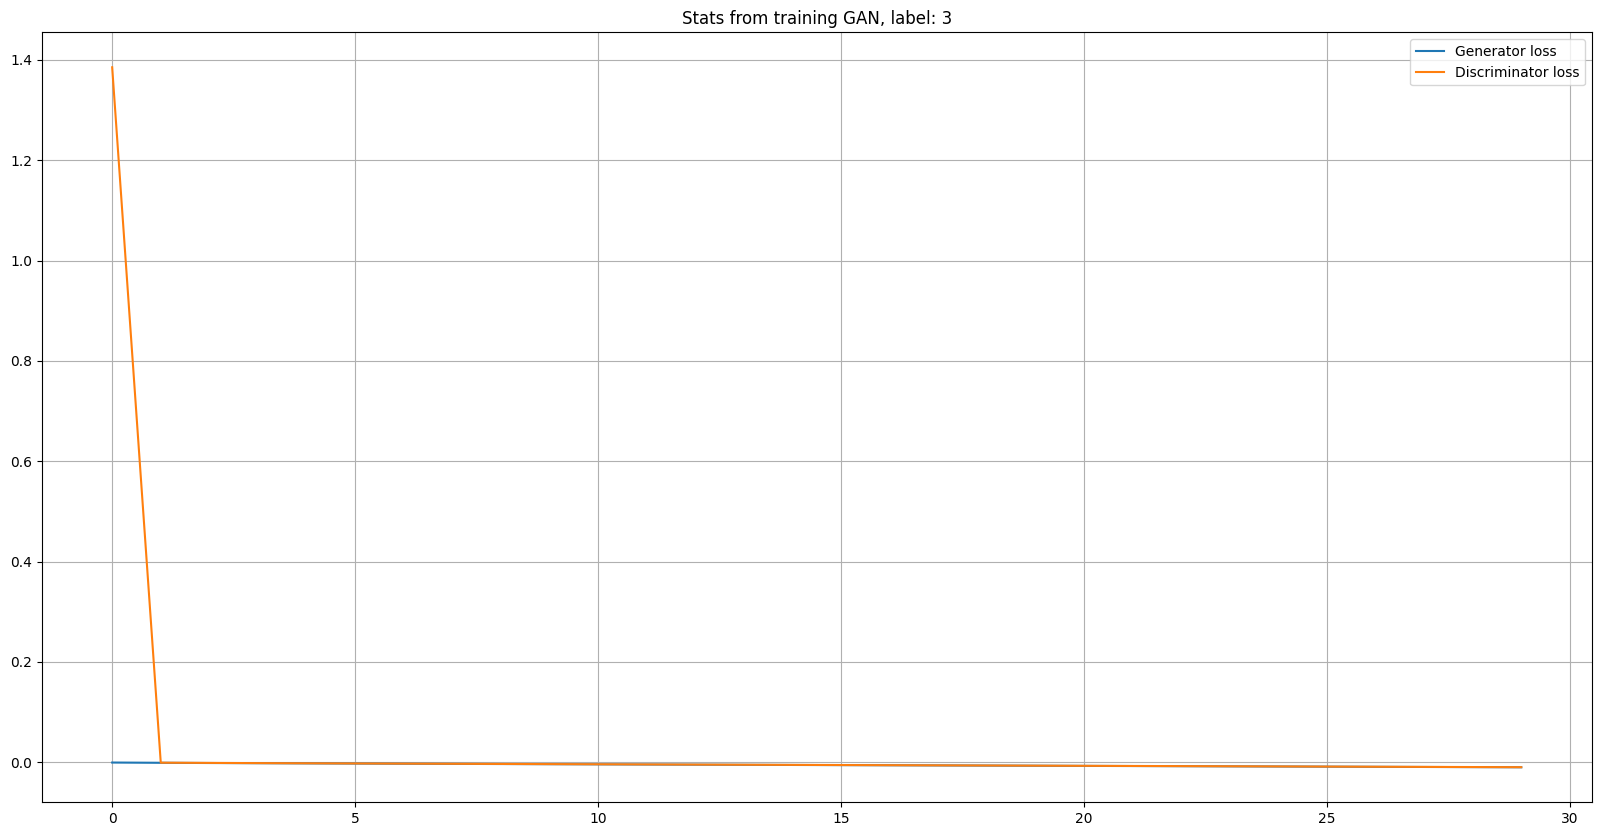

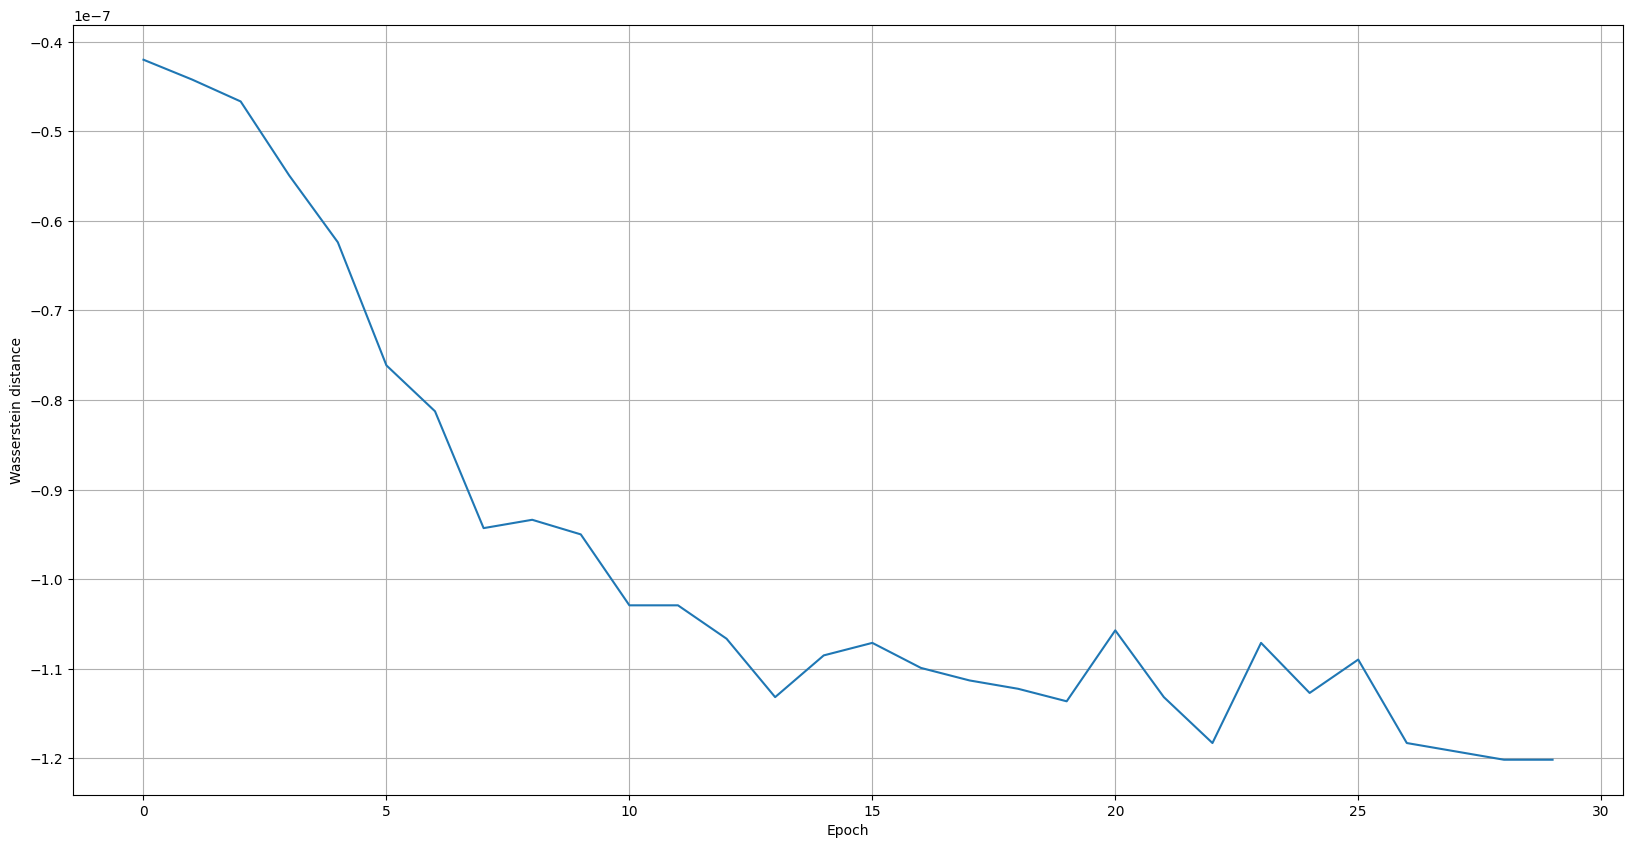

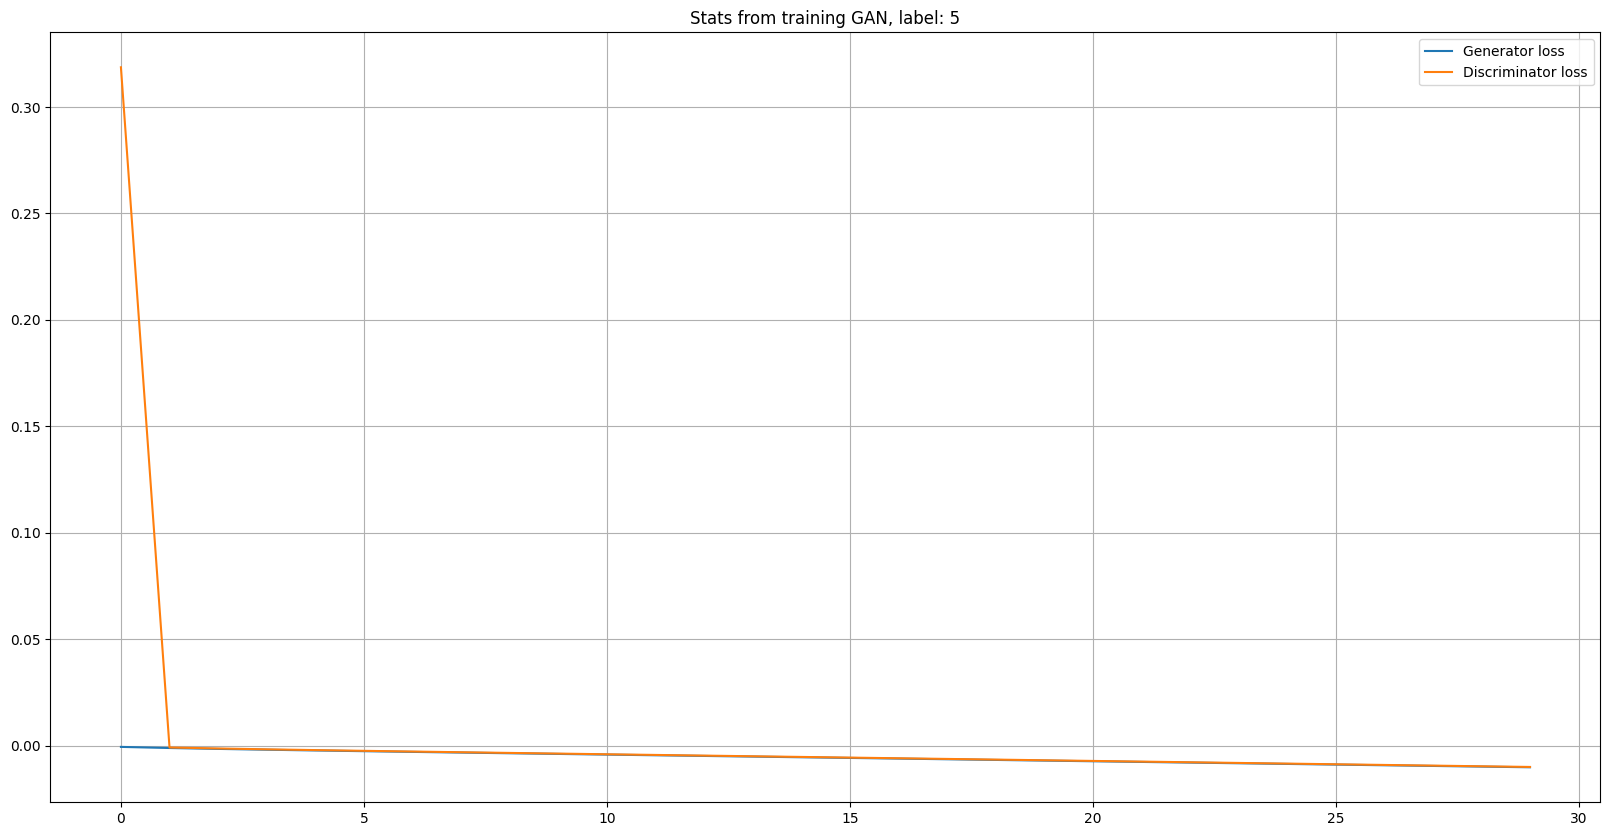

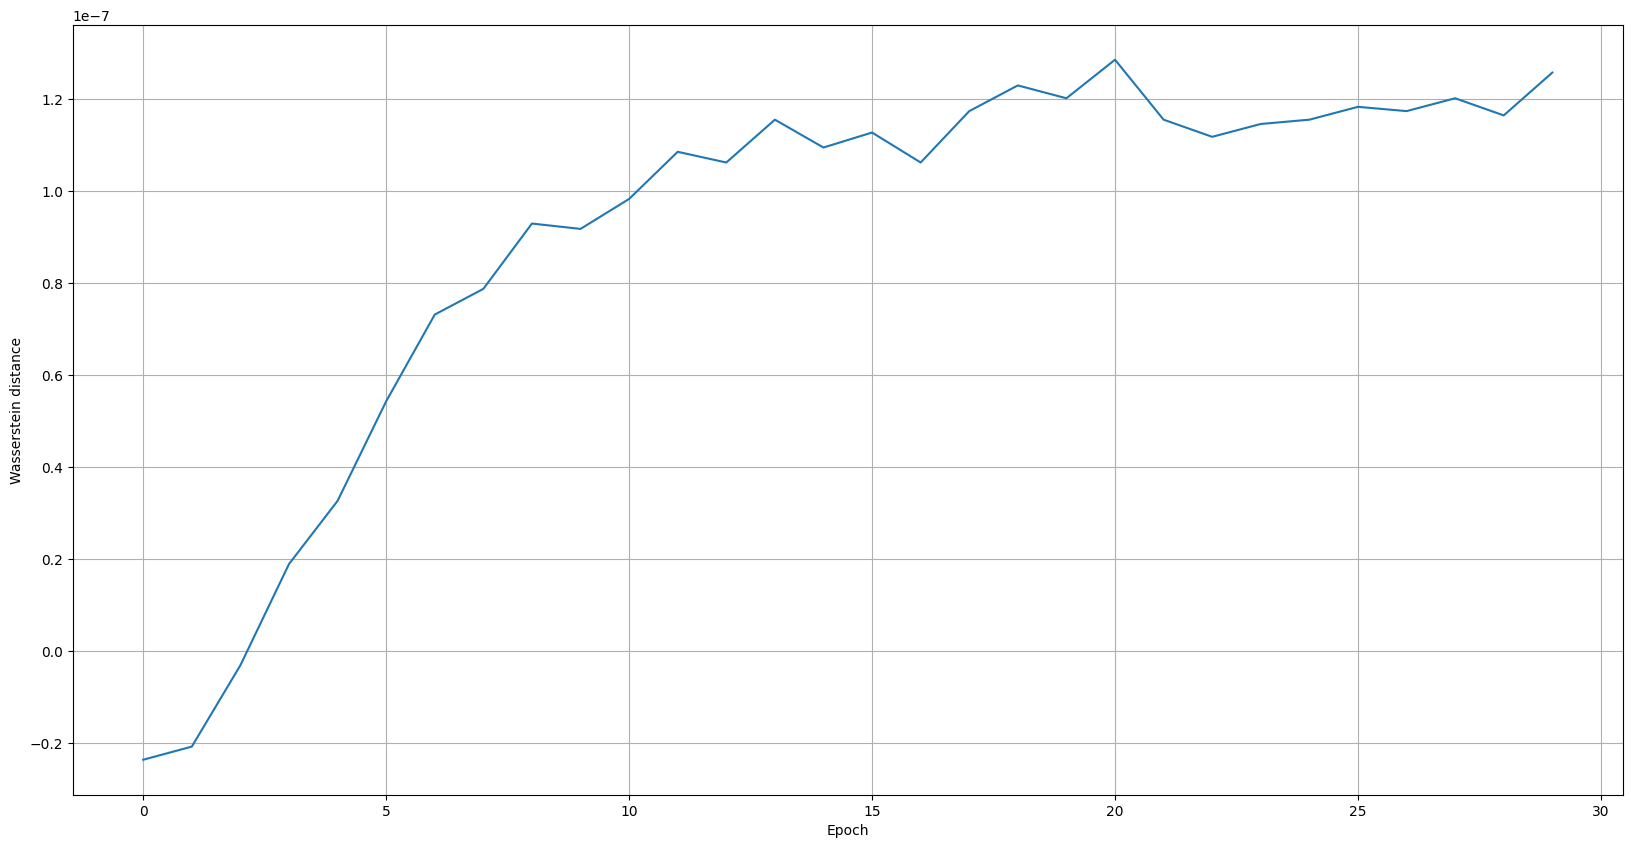

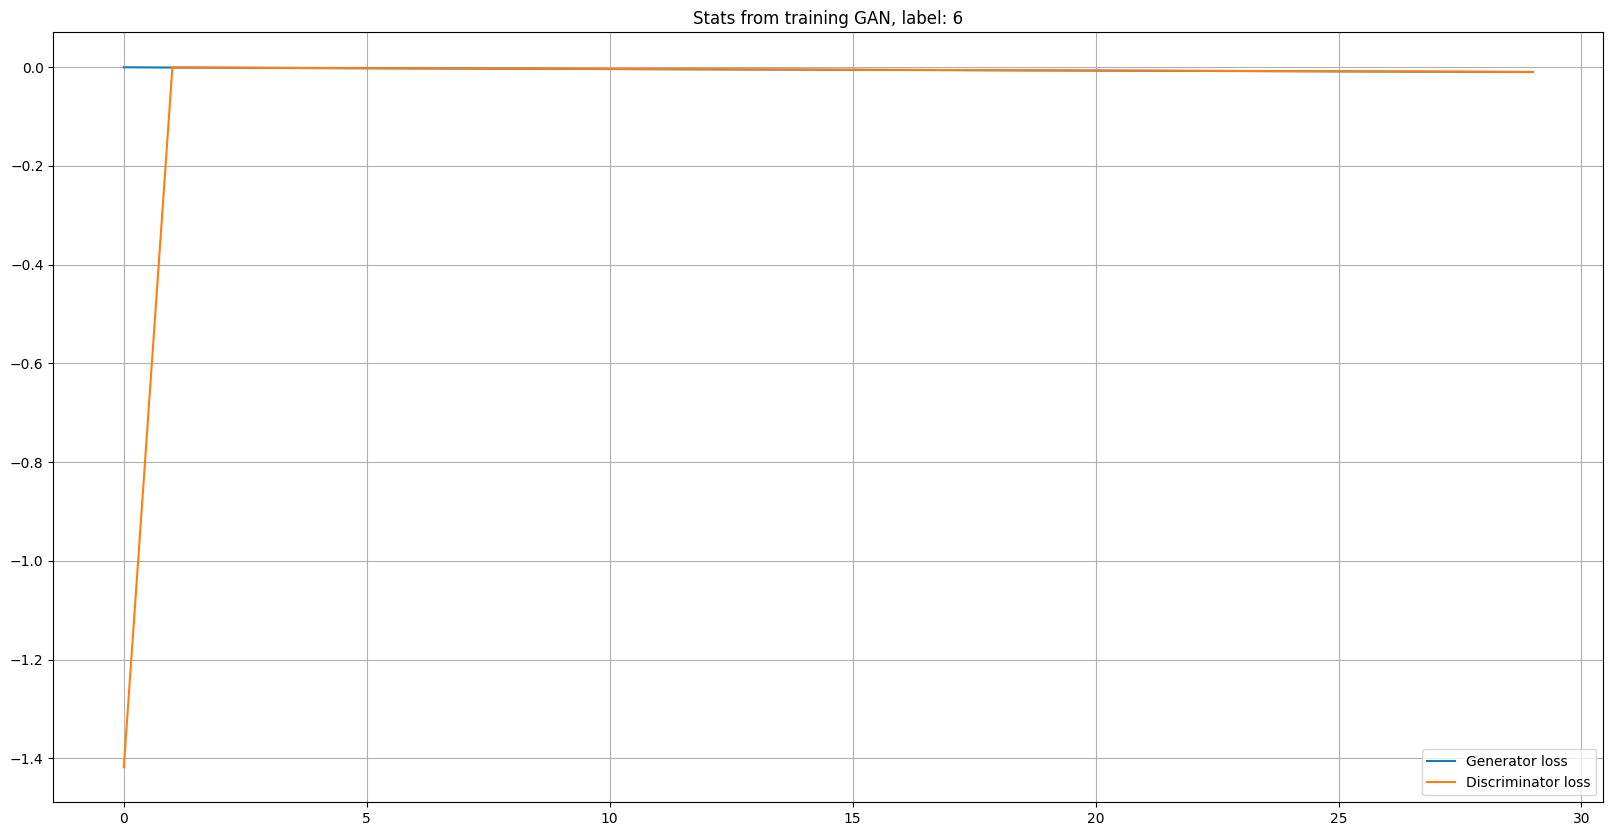

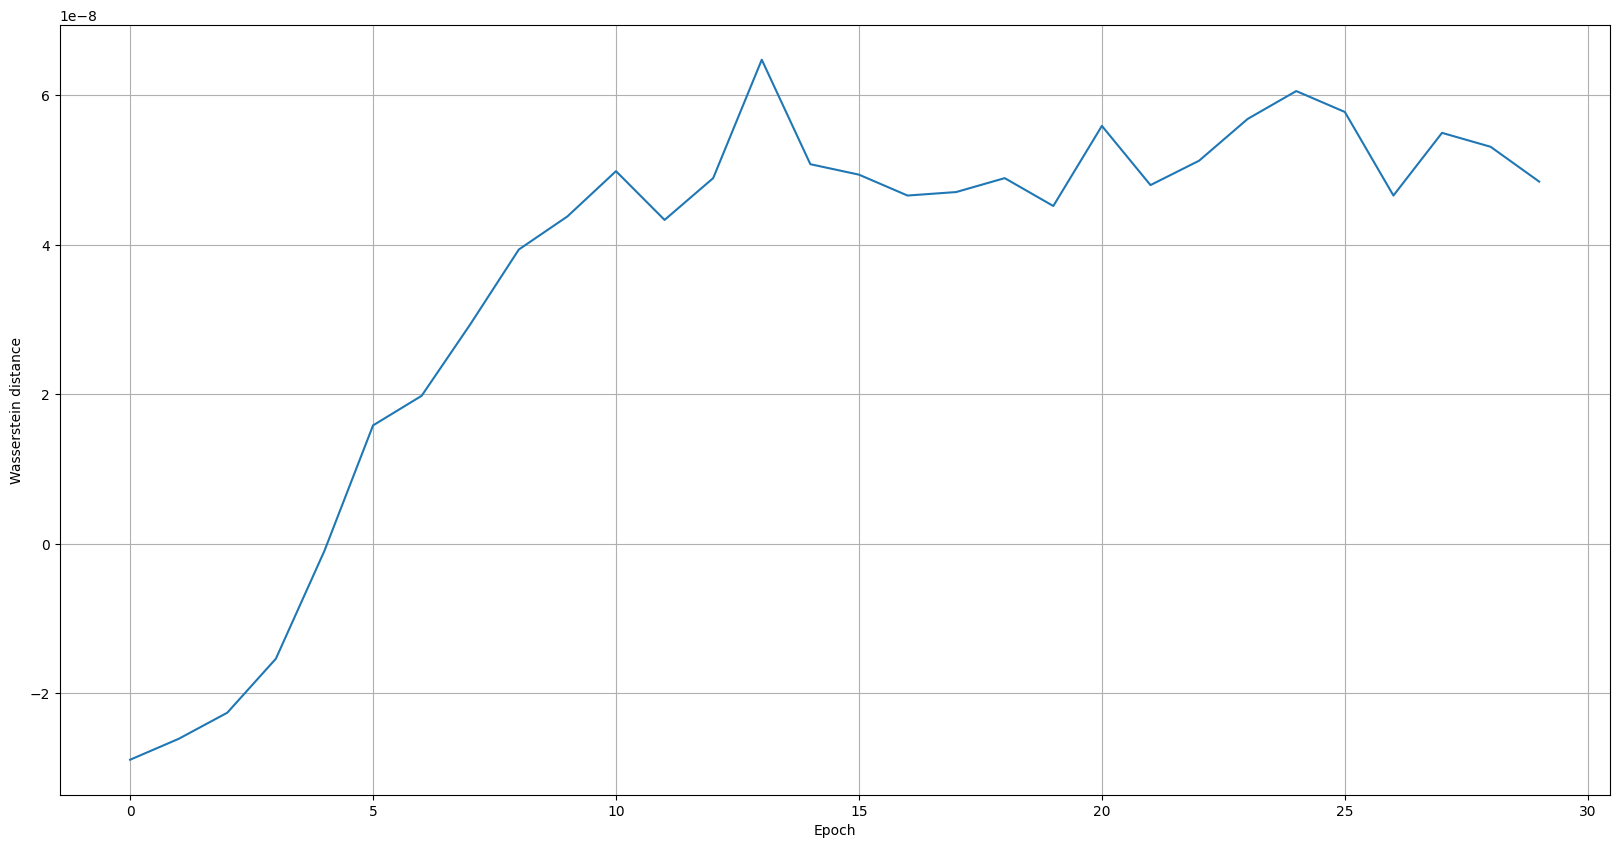

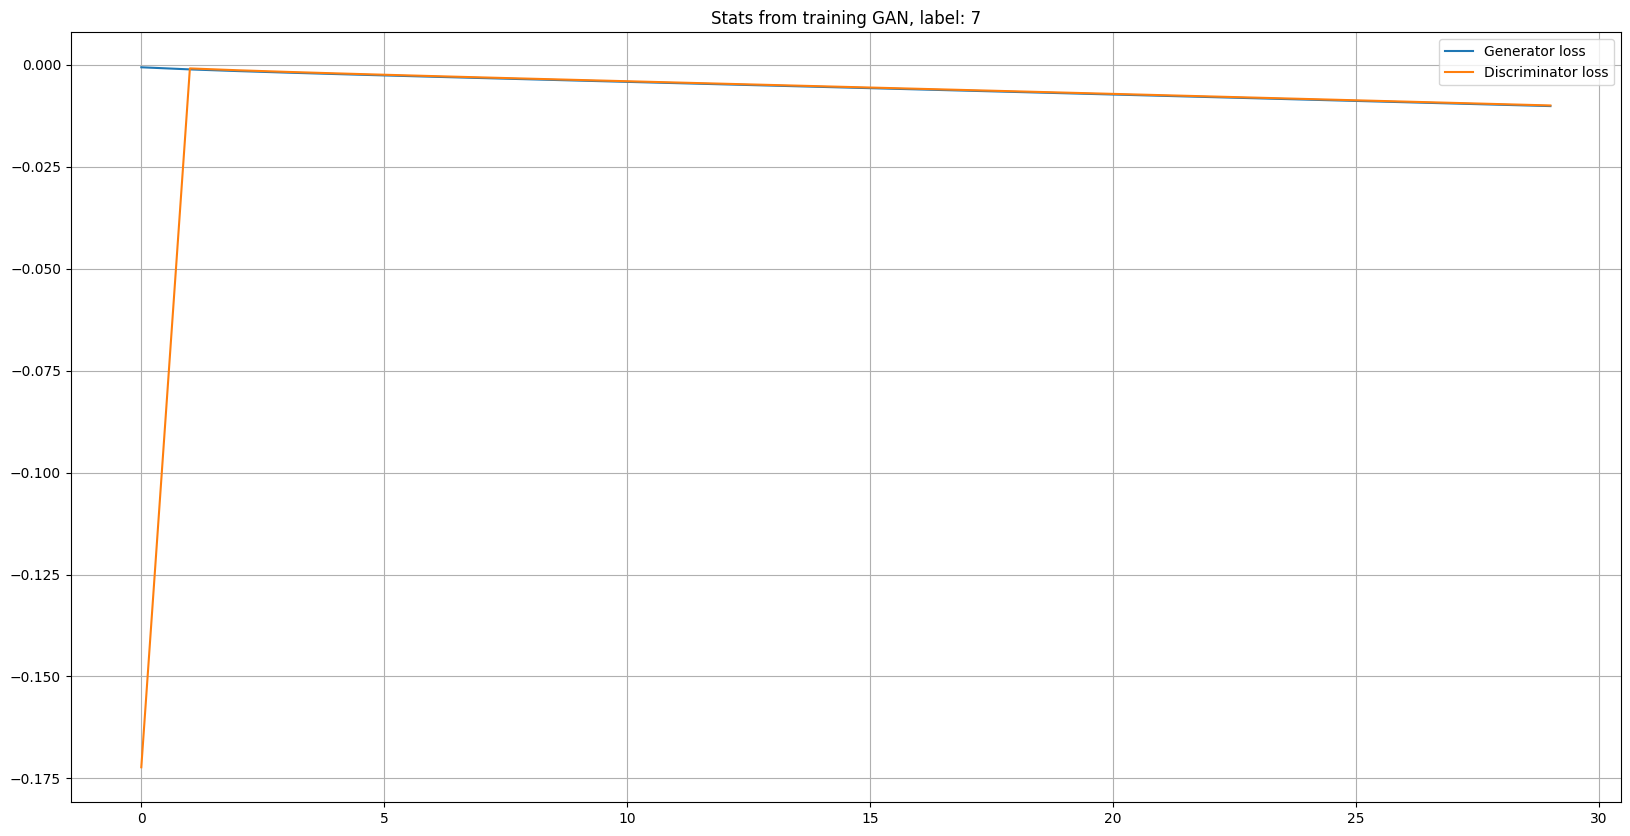

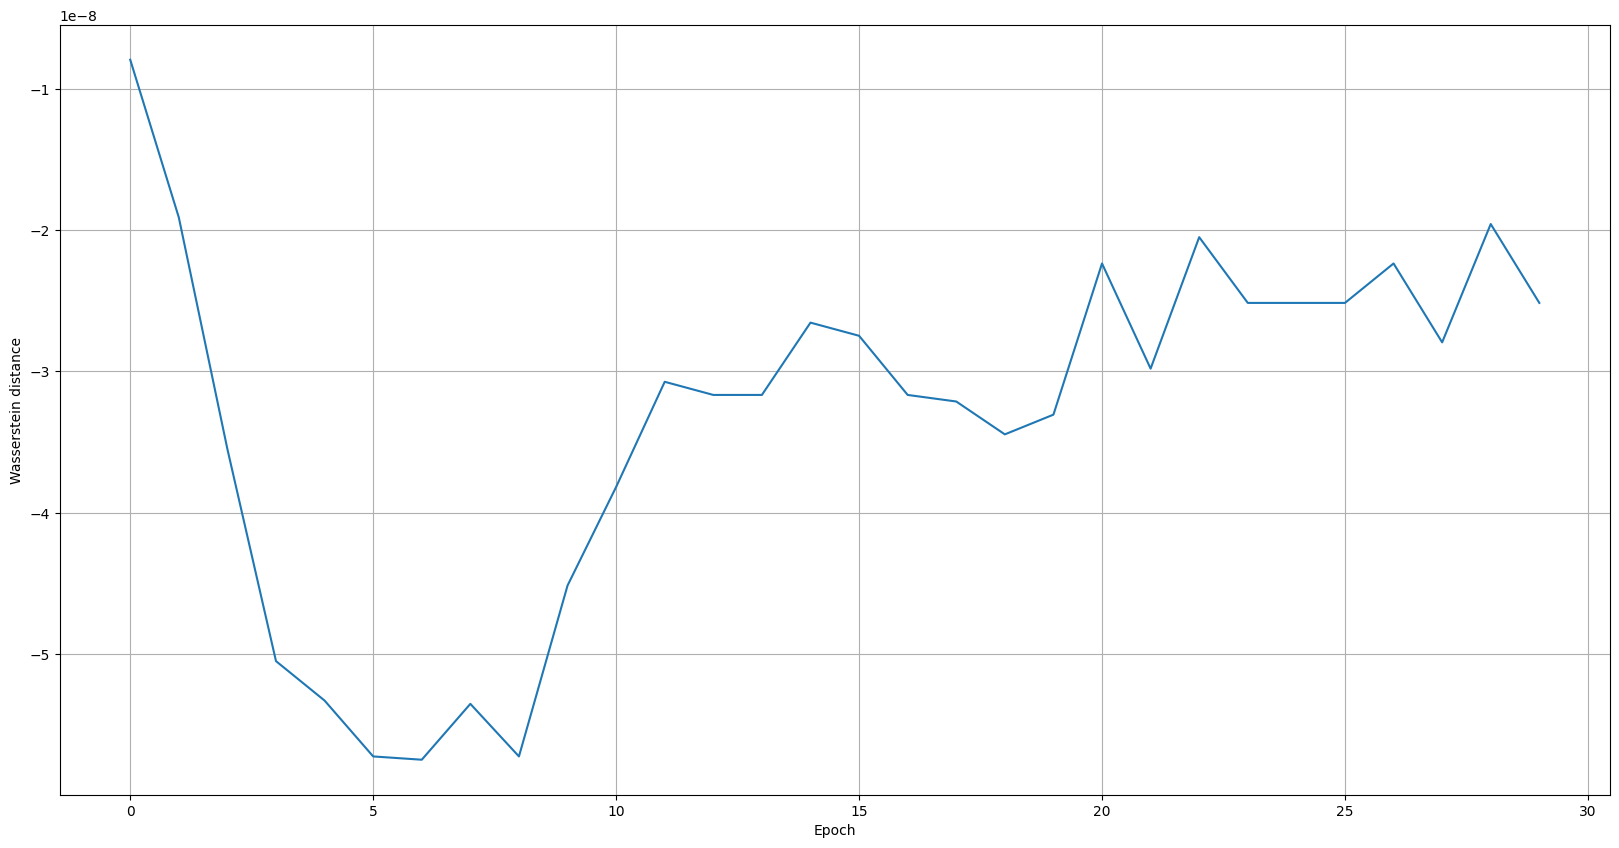

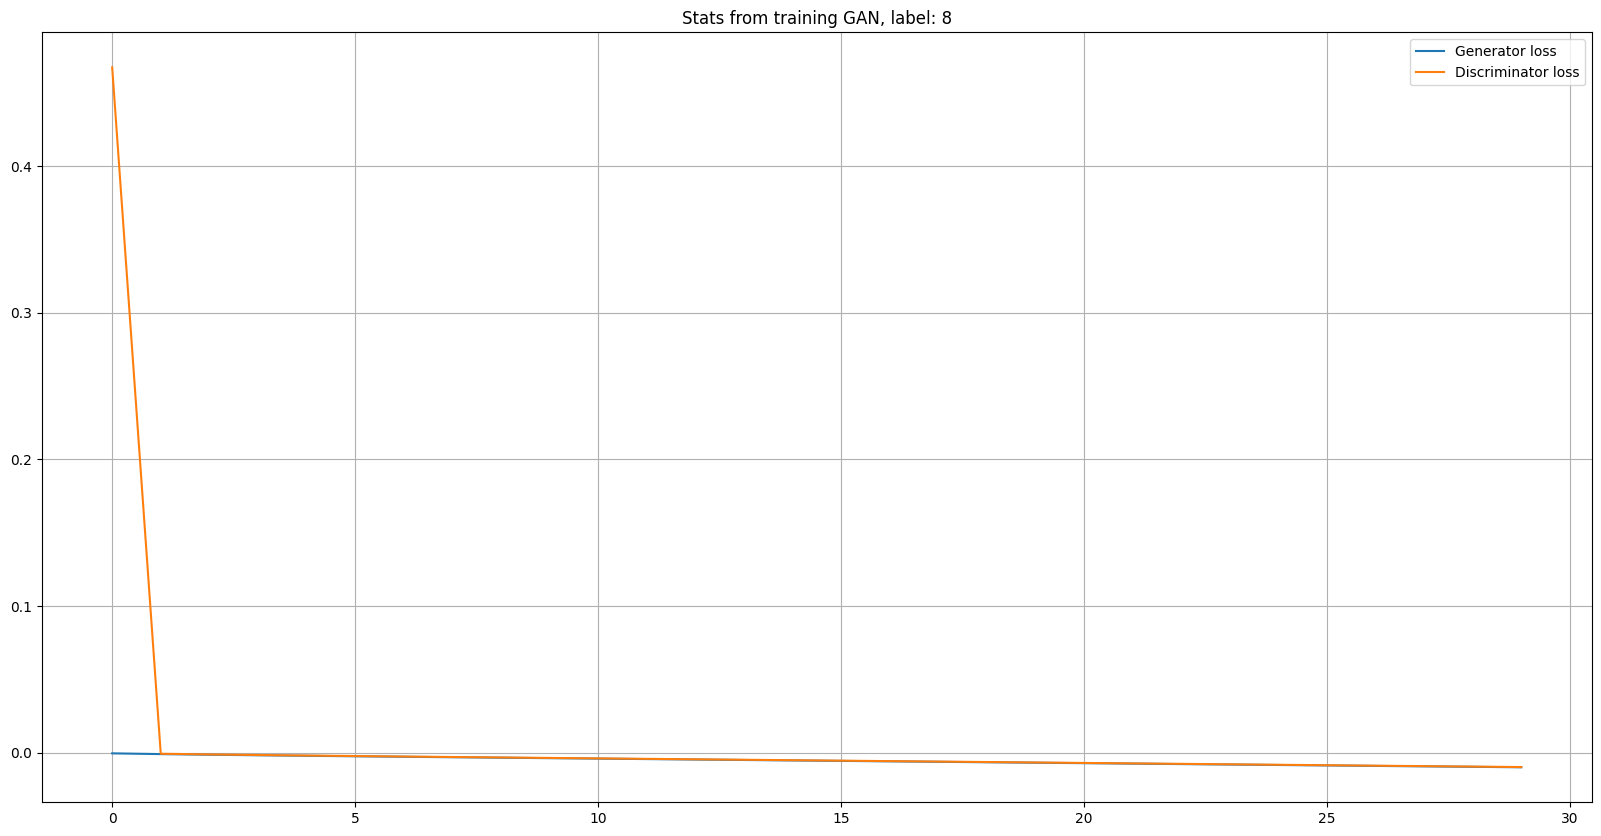

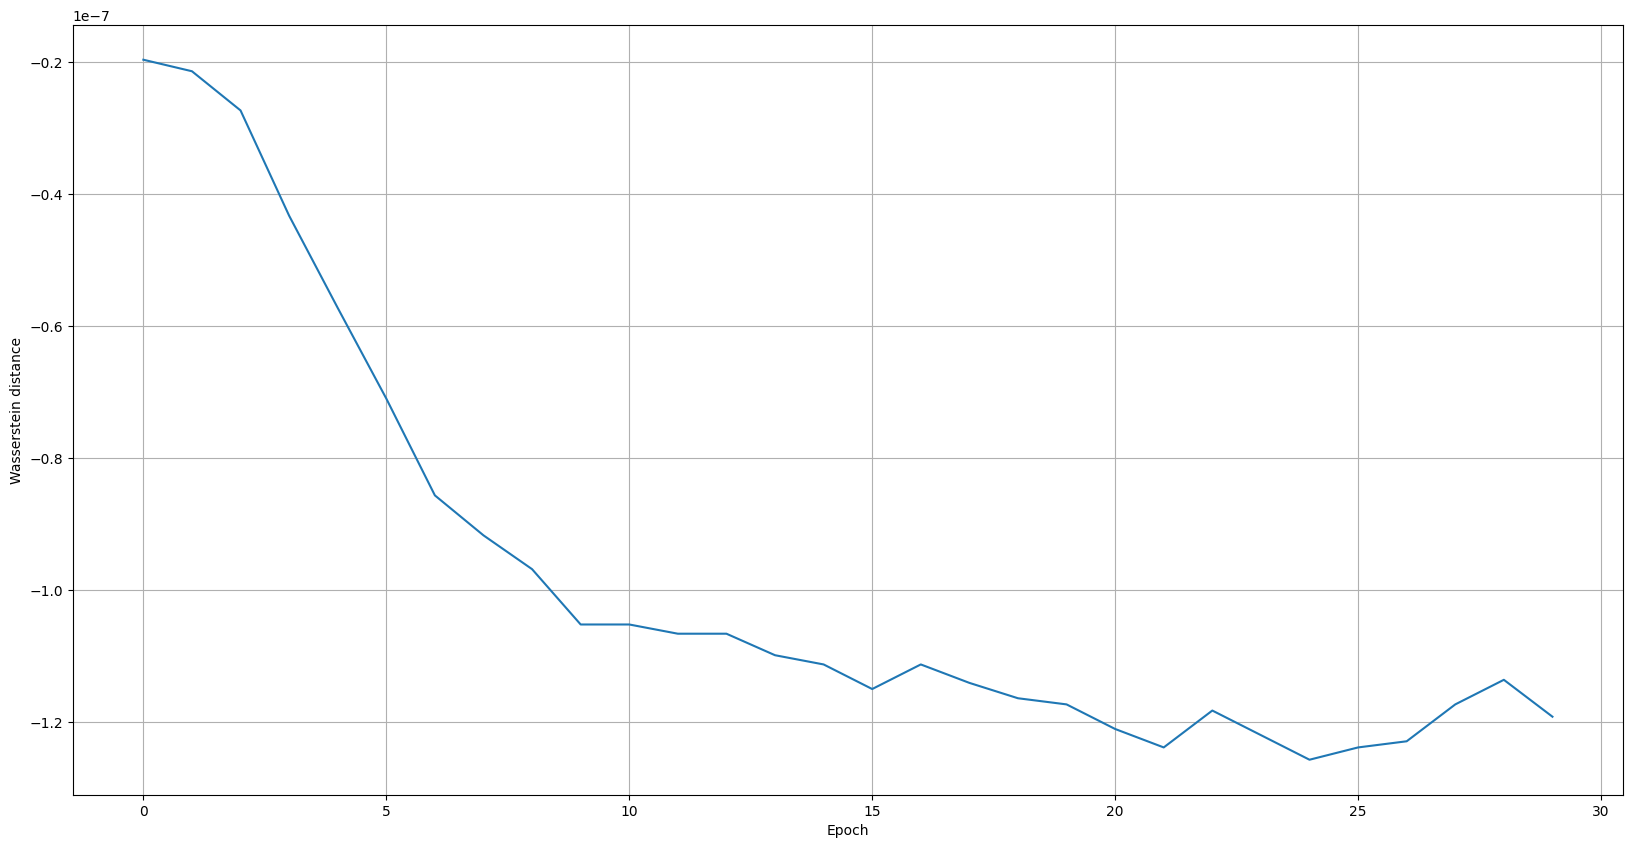

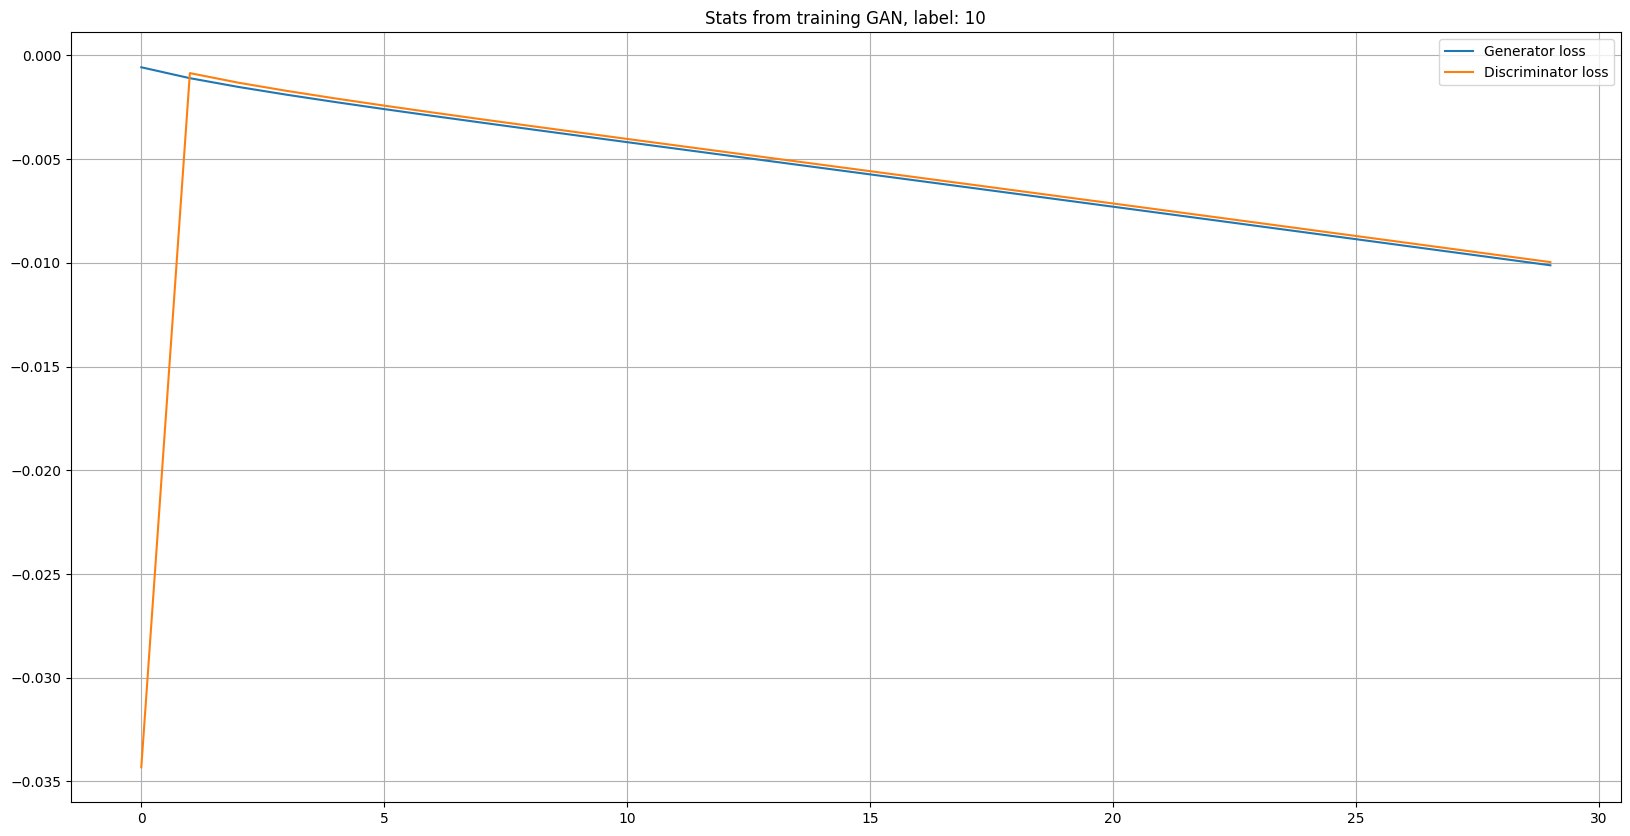

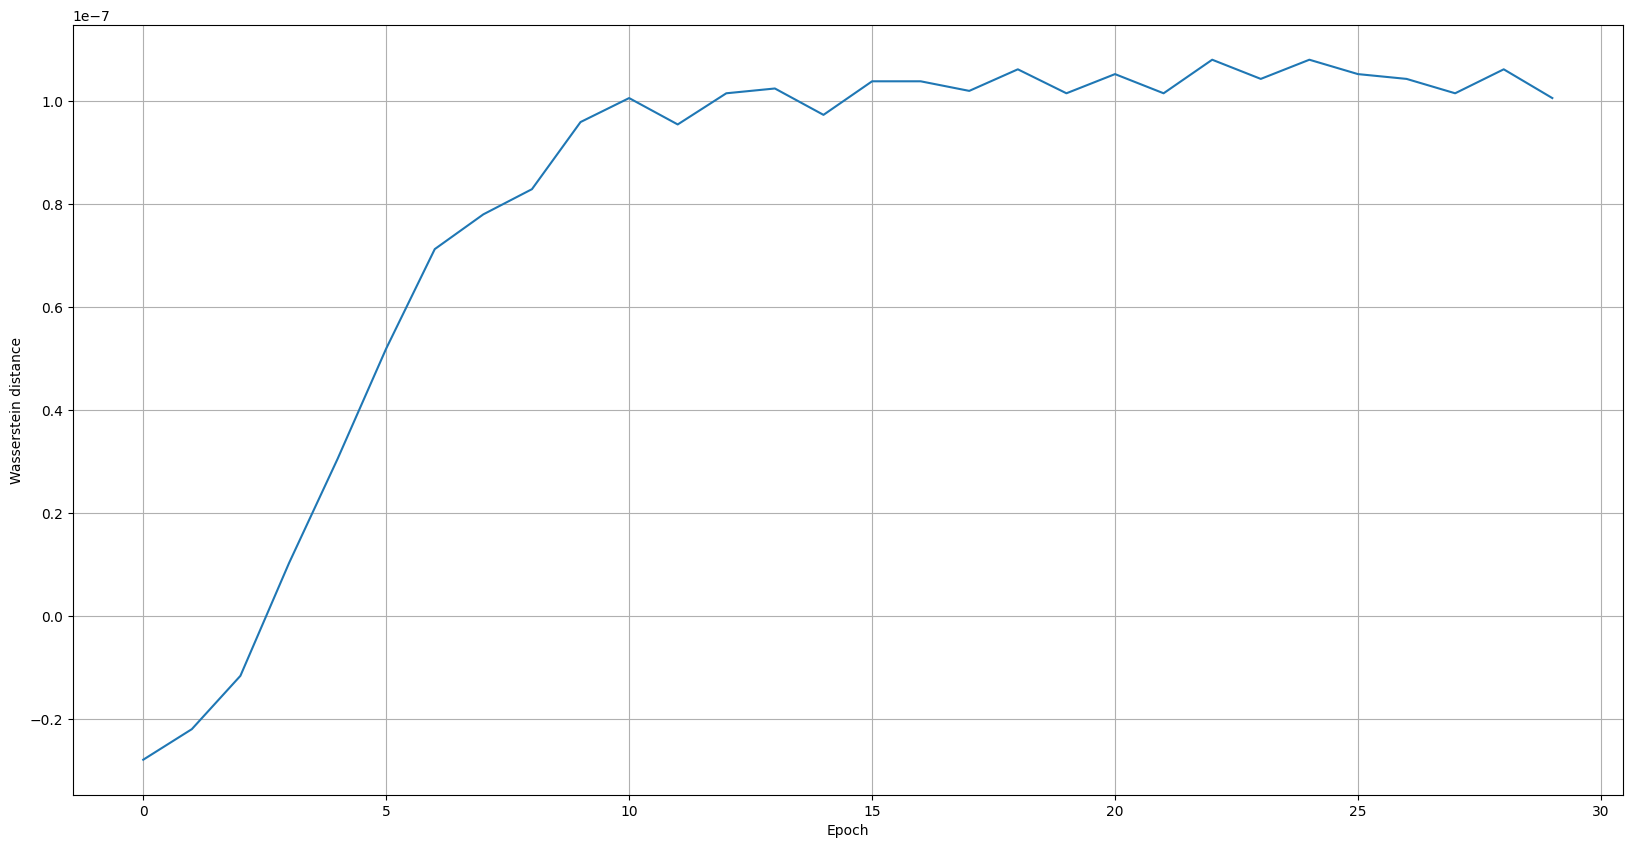

In [79]:
def convert_to_dataframe(arr, c):
    """Convert a numpy array to a pandas dataframe."""
    #print(features.columns)
    return pd.DataFrame(arr, columns=c)

def generate_fake_w_2(real_data, label, num_to_generate, input_dimension, latent_dim, c):
    """Generate synthetic data to balance the specified label."""
#     optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    w_optimizer_2 = RMSprop(learning_rate=0.0001)
    w_generator_2 = build_wgan_generator_2(input_dimension.shape[1], latent_dim)
    w_discriminator_2 = build_wgan_discriminator_2(input_dimension.shape[1], w_optimizer_2)
    wgan_2 = build_wgan_2(w_generator_2, w_discriminator_2, w_optimizer_2)
    train_wgan_x(w_generator_2, w_discriminator_2, wgan_2, real_data, latent_dim, n_epochs=30, n_batch=500, n_eval=250)

    # generate synthetic data to balance the label
    noise = np.random.normal(0, 1, (num_to_generate, latent_dim))
    gen_data = w_generator_2(noise)

    # convert numpy array to dataframe and add label column
    data_generated = convert_to_dataframe(min_max_scaler.inverse_transform(gen_data), c)
    data_generated['label'] = label
    
    return data_generated

input_dimension = fts_test_df.drop(columns=['label'])

# get unique labels and their counts
unique_labels, label_counts = np.unique(fts_train_df['label'], return_counts=True)
target = label_counts.max()
print('Target distribution for test data =', target)

# generate synthetic data for each label with count less than the target count
fake_w_df_2 = pd.DataFrame(columns=list(features.columns) + ['label'])
for label, count in zip(unique_labels, label_counts):
#     if count >= target:
#         continue
#     gen_num = target - count
#     print(f'Generating {gen_num} samples for label {label}')
    gen_num = target - count
    print(f'Generating {gen_num} samples for label {label}')
    if not gen_num:
        continue
    elif gen_num < 0:
        print('ERROR, ERROR: GEN_NUM IS NEGATIVE!')
    else:
        real_data = fts_train_df.loc[fts_train_df['label'] == label]
        fake_data_for_label_w2 = generate_fake_w_2(real_data, label, gen_num, input_dimension, latent_dim=32, c=features.columns)
        print(f'Generated {fake_data_for_label_w2.shape[0]} samples for label {label}')
        fake_w_df_2 = fake_w_df_2.append(fake_data_for_label_w2, ignore_index=True)

In [82]:
# Make sure the column types of generated data is correct
fake_w_df_2 = fake_w_df_2.astype(data.dtypes.to_dict())
fake_w_df_2['label'] = fake_w_df_2['label'].astype('int64')
fake_w_df_2

destination_port  flow_duration  total_fwd_packets  \
0                       0       71083554              52777   
1                       0       94188495              48181   
2                       0       80422190                  1   
3                       0       26833601                  1   
4                       0             -1                  1   
...                   ...            ...                ...   
1223875              3518       56354222              58447   
1223876             39874       44025385              84636   
1223877              8276       77026435              73365   
1223878             49254       50627942             142455   
1223879             20319       43245381             164336   

         total_backward_packets  total_length_of_fwd_packets  \
0                         22795                       138561   
1                             0                       300277   
2                             0                       421882   
3                             0                       753683   
4                          8942                       363653   
...                         ...                          ...   
1223875                       0                            0   
1223876                       0                            0   
1223877                       0                            0   
1223878                       0                            0   
1223879                   29641                            0   

         total_length_of_bwd_packets  fwd_packet_length_max  \
0                          278582265                      0   
1                          622008201                      0   
2                          362510583                      0   
3                          514435891                      0   
4                          736474237                   8786   
...                              ...                    ...   
1223875                    256294081                      0   
1223876                    321838421                      0   
1223877                    358770707                      0   
1223878                    593947176                      0   
1223879                    480209058                      0   

         fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
0                            0                0.000000            2192.936064   
1                            0              266.237854            3482.040741   
2                            0             1109.937505            1557.041347   
3                            0               49.234038            1777.878866   
4                            0             3199.929600            3038.046932   
...                        ...                     ...                    ...   
1223875                   1097                0.000000               0.000000   
1223876                   1201                0.000000               0.000000   
1223877                    891                0.000000               0.000000   
1223878                    196                0.000000               0.000000   
1223879                    288                0.000000               0.000000   

         ...  min_seg_size_forward   active_mean    active_std  active_max  \
0        ...            -536870660  0.000000e+00  3.386391e+06           0   
1        ...            -536870660  0.000000e+00  8.569737e+06           0   
2        ...            -536870660  0.000000e+00  0.000000e+00           0   
3        ...            -536870660  0.000000e+00  2.625595e+07    52432474   
4        ...            -536870660  0.000000e+00  0.000000e+00    10318352   
...      ...                   ...           ...           ...         ...   
1223875  ...            -208247049  0.000000e+00  1.114120e+07    13285587   
1223876  ...            -181787663  4.164983e+06  0.000000e+00           0   
1223877  ...            -181368655  0.000000e+00  0

In [83]:
# SAVE fake_data_df
output_path = 'aug_data_w2.csv'
# fake_data_df.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
fake_w_df_2.to_csv(output_path)

Target distribution for test data = 161087
Generating 2095 samples for label 0
GAN training of label: 0, samples = 158992
16/16 [==============================] - 0s 4ms/step
Epoch 0: Generator loss=-0.0018835527589544654, Discriminator loss=-0.9205234944820404, Wasserstein distance=3.2153911888599396e-07
16/16 [==============================] - 0s 3ms/step
Epoch 1: Generator loss=-0.0032093466725200415, Discriminator loss=-0.0020583680598065257, Wasserstein distance=1.2782402336597443e-07
16/16 [==============================] - 0s 3ms/step
Epoch 2: Generator loss=-0.004451481159776449, Discriminator loss=-0.0033649648539721966, Wasserstein distance=-2.630986273288727e-07
16/16 [==============================] - 0s 3ms/step
Epoch 3: Generator loss=-0.005680158734321594, Discriminator loss=-0.004603483946993947, Wasserstein distance=-6.449408829212189e-07
16/16 [==============================] - 0s 3ms/step
Epoch 4: Generator loss=-0.006913166027516127, Discriminator loss=-0.0058321431

16/16 [==============================] - 0s 2ms/step
Epoch 23: Generator loss=-0.011783964931964874, Discriminator loss=-0.012076303828507662, Wasserstein distance=-0.000833950936794281
16/16 [==============================] - 0s 3ms/step
Epoch 24: Generator loss=-0.011849049478769302, Discriminator loss=-0.012211741413921118, Wasserstein distance=-0.001149970106780529
16/16 [==============================] - 0s 3ms/step
Epoch 25: Generator loss=-0.01193808950483799, Discriminator loss=-0.012394306249916553, Wasserstein distance=-0.0015601273626089096
16/16 [==============================] - 0s 3ms/step
Epoch 26: Generator loss=-0.012069704942405224, Discriminator loss=-0.012616812251508236, Wasserstein distance=-0.0020529069006443024
16/16 [==============================] - 0s 3ms/step
Epoch 27: Generator loss=-0.012247531674802303, Discriminator loss=-0.012887342367321253, Wasserstein distance=-0.0026281438767910004
16/16 [==============================] - 0s 3ms/step
Epoch 28: Gener

16/16 [==============================] - 0s 3ms/step
Epoch 47: Generator loss=-0.017824891954660416, Discriminator loss=-0.016852895263582468, Wasserstein distance=-0.010324979200959206
16/16 [==============================] - 0s 3ms/step
Epoch 48: Generator loss=-0.017971275374293327, Discriminator loss=-0.016852708533406258, Wasserstein distance=-0.010479380376636982
16/16 [==============================] - 0s 4ms/step
Epoch 49: Generator loss=-0.018243959173560143, Discriminator loss=-0.016992458142340183, Wasserstein distance=-0.01035291701555252
16/16 [==============================] - 0s 4ms/step
Epoch 50: Generator loss=-0.01794997975230217, Discriminator loss=-0.01684485375881195, Wasserstein distance=-0.010449300520122051
16/16 [==============================] - 0s 3ms/step
Epoch 51: Generator loss=-0.018344707787036896, Discriminator loss=-0.0169879705645144, Wasserstein distance=-0.01045235712081194
16/16 [==============================] - 0s 3ms/step
Epoch 52: Generator los

16/16 [==============================] - 0s 2ms/step
Epoch 11: Generator loss=-0.011378818191587925, Discriminator loss=-0.011497899424284697, Wasserstein distance=-1.3418495655059814e-05
16/16 [==============================] - 0s 3ms/step
Epoch 12: Generator loss=-0.011417372152209282, Discriminator loss=-0.011543754488229752, Wasserstein distance=-1.9315630197525024e-05
16/16 [==============================] - 0s 3ms/step
Epoch 13: Generator loss=-0.011447735130786896, Discriminator loss=-0.011583477258682251, Wasserstein distance=-2.703443169593811e-05
16/16 [==============================] - 0s 3ms/step
Epoch 14: Generator loss=-0.01147584617137909, Discriminator loss=-0.011613948736339808, Wasserstein distance=-3.9254315197467804e-05
16/16 [==============================] - 0s 2ms/step
Epoch 15: Generator loss=-0.011505510658025742, Discriminator loss=-0.011644103564321995, Wasserstein distance=-5.759391933679581e-05
16/16 [==============================] - 0s 3ms/step
Epoch 16: 

16/16 [==============================] - 0s 3ms/step
Epoch 35: Generator loss=-0.015294460579752922, Discriminator loss=-0.016074329148977995, Wasserstein distance=-0.007825326174497604
16/16 [==============================] - 0s 3ms/step
Epoch 36: Generator loss=-0.01572251133620739, Discriminator loss=-0.016388872638344765, Wasserstein distance=-0.008395623415708542
16/16 [==============================] - 0s 3ms/step
Epoch 37: Generator loss=-0.01599702052772045, Discriminator loss=-0.016627341508865356, Wasserstein distance=-0.008786370046436787
16/16 [==============================] - 0s 2ms/step
Epoch 38: Generator loss=-0.01655634492635727, Discriminator loss=-0.016929418314248323, Wasserstein distance=-0.009219813160598278
16/16 [==============================] - 0s 3ms/step
Epoch 39: Generator loss=-0.016949649900197983, Discriminator loss=-0.017178171779960394, Wasserstein distance=-0.009596041403710842
16/16 [==============================] - 0s 4ms/step
Epoch 40: Generator 

16/16 [==============================] - 0s 3ms/step
Epoch 59: Generator loss=-0.019328845664858818, Discriminator loss=-0.01810407917946577, Wasserstein distance=-0.010860416106879711
Generated 159718 samples for label 1
Generating 71470 samples for label 2
GAN training of label: 2, samples = 89617
16/16 [==============================] - 0s 3ms/step
Epoch 0: Generator loss=-0.0018817402888089418, Discriminator loss=0.09838957712054253, Wasserstein distance=3.541354089975357e-07
16/16 [==============================] - 0s 3ms/step
Epoch 1: Generator loss=-0.0032129387836903334, Discriminator loss=-0.002058949787169695, Wasserstein distance=2.0908191800117493e-07
16/16 [==============================] - 0s 3ms/step
Epoch 2: Generator loss=-0.004460486583411694, Discriminator loss=-0.003370955935679376, Wasserstein distance=-9.778887033462524e-09
16/16 [==============================] - 0s 3ms/step
Epoch 3: Generator loss=-0.005692902486771345, Discriminator loss=-0.0046148174442350864,

16/16 [==============================] - 0s 2ms/step
Epoch 22: Generator loss=-0.011713260784745216, Discriminator loss=-0.011941200587898493, Wasserstein distance=-0.0004397546872496605
16/16 [==============================] - 0s 3ms/step
Epoch 23: Generator loss=-0.011760296300053596, Discriminator loss=-0.012047940865159035, Wasserstein distance=-0.0006088931113481522
16/16 [==============================] - 0s 3ms/step
Epoch 24: Generator loss=-0.011813833378255367, Discriminator loss=-0.012171397916972637, Wasserstein distance=-0.0008300608024001122
16/16 [==============================] - 0s 3ms/step
Epoch 25: Generator loss=-0.011884727515280247, Discriminator loss=-0.012321374844759703, Wasserstein distance=-0.0011120792478322983
16/16 [==============================] - 0s 3ms/step
Epoch 26: Generator loss=-0.01199365220963955, Discriminator loss=-0.012512564193457365, Wasserstein distance=-0.0014788461849093437
16/16 [==============================] - 0s 2ms/step
Epoch 27: Gen

16/16 [==============================] - 0s 3ms/step
Epoch 46: Generator loss=-0.017161281779408455, Discriminator loss=-0.017222088761627674, Wasserstein distance=-0.00906627532094717
16/16 [==============================] - 0s 3ms/step
Epoch 47: Generator loss=-0.017543479800224304, Discriminator loss=-0.017322804778814316, Wasserstein distance=-0.008833433501422405
16/16 [==============================] - 0s 2ms/step
Epoch 48: Generator loss=-0.01750439591705799, Discriminator loss=-0.0172852729447186, Wasserstein distance=-0.009182771667838097
16/16 [==============================] - 0s 3ms/step
Epoch 49: Generator loss=-0.01770748570561409, Discriminator loss=-0.0173697080463171, Wasserstein distance=-0.009170765988528728
16/16 [==============================] - 0s 4ms/step
Epoch 50: Generator loss=-0.01784195750951767, Discriminator loss=-0.01733534876257181, Wasserstein distance=-0.009190098382532597
16/16 [==============================] - 0s 2ms/step
Epoch 51: Generator loss=-

16/16 [==============================] - 0s 3ms/step
Epoch 10: Generator loss=-0.011309494264423847, Discriminator loss=-0.011413472704589367, Wasserstein distance=-1.0943971574306488e-05
16/16 [==============================] - 0s 3ms/step
Epoch 11: Generator loss=-0.011370244435966015, Discriminator loss=-0.011472600512206554, Wasserstein distance=-1.4751218259334564e-05
16/16 [==============================] - 0s 3ms/step
Epoch 12: Generator loss=-0.011406014673411846, Discriminator loss=-0.011533800978213549, Wasserstein distance=-2.014078199863434e-05
16/16 [==============================] - 0s 3ms/step
Epoch 13: Generator loss=-0.011432328261435032, Discriminator loss=-0.011569380294531584, Wasserstein distance=-2.7808360755443573e-05
16/16 [==============================] - 0s 3ms/step
Epoch 14: Generator loss=-0.01146081555634737, Discriminator loss=-0.011595765128731728, Wasserstein distance=-3.884918987751007e-05
16/16 [==============================] - 0s 2ms/step
Epoch 15: 

16/16 [==============================] - 0s 3ms/step
Epoch 34: Generator loss=-0.014561000280082226, Discriminator loss=-0.01502227084711194, Wasserstein distance=-0.006528889760375023
16/16 [==============================] - 0s 3ms/step
Epoch 35: Generator loss=-0.01488439366221428, Discriminator loss=-0.015255920588970184, Wasserstein distance=-0.007075818255543709
16/16 [==============================] - 0s 3ms/step
Epoch 36: Generator loss=-0.015286952257156372, Discriminator loss=-0.015557147096842527, Wasserstein distance=-0.007467810995876789
16/16 [==============================] - 0s 3ms/step
Epoch 37: Generator loss=-0.015661850571632385, Discriminator loss=-0.015718290116637945, Wasserstein distance=-0.008166526444256306
16/16 [==============================] - 0s 3ms/step
Epoch 38: Generator loss=-0.01592068560421467, Discriminator loss=-0.016021043993532658, Wasserstein distance=-0.00824173353612423
16/16 [==============================] - 0s 3ms/step
Epoch 39: Generator l

Epoch 57: Generator loss=-0.01865832507610321, Discriminator loss=-0.017044886015355587, Wasserstein distance=-0.010300899855792522
16/16 [==============================] - 0s 3ms/step
Epoch 58: Generator loss=-0.018619971349835396, Discriminator loss=-0.016814532224088907, Wasserstein distance=-0.01038398128002882
16/16 [==============================] - 0s 3ms/step
Epoch 59: Generator loss=-0.018766975030303, Discriminator loss=-0.01705481531098485, Wasserstein distance=-0.010355847887694836
Generated 153882 samples for label 3
Generating 0 samples for label 4
Generating 157238 samples for label 5
GAN training of label: 5, samples = 3849
16/16 [==============================] - 0s 3ms/step
Epoch 0: Generator loss=-0.0018790680915117264, Discriminator loss=0.5809786319732666, Wasserstein distance=-3.878958523273468e-07
16/16 [==============================] - 0s 3ms/step
Epoch 1: Generator loss=-0.0032138628885149956, Discriminator loss=-0.002059808815829456, Wasserstein distance=-7.3

16/16 [==============================] - 0s 3ms/step
Epoch 21: Generator loss=-0.011623229831457138, Discriminator loss=-0.011825517285615206, Wasserstein distance=-0.00028238072991371155
16/16 [==============================] - 0s 3ms/step
Epoch 22: Generator loss=-0.011656965129077435, Discriminator loss=-0.011900338344275951, Wasserstein distance=-0.00040148478001356125
16/16 [==============================] - 0s 3ms/step
Epoch 23: Generator loss=-0.011697771027684212, Discriminator loss=-0.011988210957497358, Wasserstein distance=-0.0005568871274590492
16/16 [==============================] - 0s 3ms/step
Epoch 24: Generator loss=-0.01174598466604948, Discriminator loss=-0.012099732644855976, Wasserstein distance=-0.0007636211812496185
16/16 [==============================] - 0s 3ms/step
Epoch 25: Generator loss=-0.011814665049314499, Discriminator loss=-0.01222900627180934, Wasserstein distance=-0.0010381676256656647
16/16 [==============================] - 0s 3ms/step
Epoch 26: Ge

16/16 [==============================] - 0s 3ms/step
Epoch 45: Generator loss=-0.01623769849538803, Discriminator loss=-0.016061640810221434, Wasserstein distance=-0.007573787122964859
16/16 [==============================] - 0s 3ms/step
Epoch 46: Generator loss=-0.01626206934452057, Discriminator loss=-0.01611717464402318, Wasserstein distance=-0.007921438664197922
16/16 [==============================] - 0s 3ms/step
Epoch 47: Generator loss=-0.016475342214107513, Discriminator loss=-0.016109430231153965, Wasserstein distance=-0.007875633426010609
16/16 [==============================] - 0s 3ms/step
Epoch 48: Generator loss=-0.016246048733592033, Discriminator loss=-0.016203757841140032, Wasserstein distance=-0.007807360030710697
16/16 [==============================] - 0s 3ms/step
Epoch 49: Generator loss=-0.01632530800998211, Discriminator loss=-0.016136239748448133, Wasserstein distance=-0.0077828532084822655
16/16 [==============================] - 0s 3ms/step
Epoch 50: Generator 

16/16 [==============================] - 0s 3ms/step
Epoch 8: Generator loss=-0.011342066340148449, Discriminator loss=-0.010953352320939302, Wasserstein distance=-3.923662006855011e-06
16/16 [==============================] - 0s 3ms/step
Epoch 9: Generator loss=-0.011404230259358883, Discriminator loss=-0.011508161202073097, Wasserstein distance=-5.2014365792274475e-06
16/16 [==============================] - 0s 3ms/step
Epoch 10: Generator loss=-0.011459916830062866, Discriminator loss=-0.01157113490626216, Wasserstein distance=-6.732530891895294e-06
16/16 [==============================] - 0s 3ms/step
Epoch 11: Generator loss=-0.011498767882585526, Discriminator loss=-0.011626839637756348, Wasserstein distance=-9.321607649326324e-06
16/16 [==============================] - 0s 3ms/step
Epoch 12: Generator loss=-0.011519954539835453, Discriminator loss=-0.011665320955216885, Wasserstein distance=-1.255236566066742e-05
16/16 [==============================] - 0s 3ms/step
Epoch 13: Gene

16/16 [==============================] - 0s 2ms/step
Epoch 32: Generator loss=-0.013380981050431728, Discriminator loss=-0.014389468356966972, Wasserstein distance=-0.004336711019277573
16/16 [==============================] - 0s 3ms/step
Epoch 33: Generator loss=-0.013613646849989891, Discriminator loss=-0.014655228704214096, Wasserstein distance=-0.004841549322009087
16/16 [==============================] - 0s 3ms/step
Epoch 34: Generator loss=-0.01388308871537447, Discriminator loss=-0.014939382206648588, Wasserstein distance=-0.005357715301215649
16/16 [==============================] - 0s 3ms/step
Epoch 35: Generator loss=-0.014381540939211845, Discriminator loss=-0.015230379533022642, Wasserstein distance=-0.005867010913789272
16/16 [==============================] - 0s 4ms/step
Epoch 36: Generator loss=-0.014567703939974308, Discriminator loss=-0.015496325213462114, Wasserstein distance=-0.006145842373371124
16/16 [==============================] - 0s 4ms/step
Epoch 37: Generato

16/16 [==============================] - 0s 3ms/step
Epoch 56: Generator loss=-0.01848878152668476, Discriminator loss=-0.017430935986340046, Wasserstein distance=-0.009472876787185669
16/16 [==============================] - 0s 3ms/step
Epoch 57: Generator loss=-0.01843949593603611, Discriminator loss=-0.017349126283079386, Wasserstein distance=-0.009253640659153461
16/16 [==============================] - 0s 3ms/step
Epoch 58: Generator loss=-0.01851525530219078, Discriminator loss=-0.017272749915719032, Wasserstein distance=-0.009486640803515911
16/16 [==============================] - 0s 3ms/step
Epoch 59: Generator loss=-0.01874208077788353, Discriminator loss=-0.017300597857683897, Wasserstein distance=-0.009338798932731152
Generated 157030 samples for label 6
Generating 155532 samples for label 7
GAN training of label: 7, samples = 5555
16/16 [==============================] - 0s 3ms/step
Epoch 0: Generator loss=-0.0018959067529067397, Discriminator loss=0.5397008247673512, Wass

16/16 [==============================] - 0s 4ms/step
Epoch 20: Generator loss=-0.011917940340936184, Discriminator loss=-0.012134308461099863, Wasserstein distance=-0.0003266269341111183
16/16 [==============================] - 0s 3ms/step
Epoch 21: Generator loss=-0.011959007009863853, Discriminator loss=-0.012210625223815441, Wasserstein distance=-0.0004765121266245842
16/16 [==============================] - 0s 3ms/step
Epoch 22: Generator loss=-0.012015056796371937, Discriminator loss=-0.012315371073782444, Wasserstein distance=-0.000675802119076252
16/16 [==============================] - 0s 3ms/step
Epoch 23: Generator loss=-0.012080938555300236, Discriminator loss=-0.012461046688258648, Wasserstein distance=-0.0009458046406507492
16/16 [==============================] - 0s 3ms/step
Epoch 24: Generator loss=-0.012157883495092392, Discriminator loss=-0.012628659140318632, Wasserstein distance=-0.0012710792943835258
16/16 [==============================] - 0s 3ms/step
Epoch 25: Gen

16/16 [==============================] - 0s 3ms/step
Epoch 44: Generator loss=-0.016816383227705956, Discriminator loss=-0.016924659721553326, Wasserstein distance=-0.00878737960010767
16/16 [==============================] - 0s 3ms/step
Epoch 45: Generator loss=-0.017063703387975693, Discriminator loss=-0.016992139630019665, Wasserstein distance=-0.00886251125484705
16/16 [==============================] - 0s 3ms/step
Epoch 46: Generator loss=-0.017500555142760277, Discriminator loss=-0.01703066797927022, Wasserstein distance=-0.008949159644544125
16/16 [==============================] - 0s 3ms/step
Epoch 47: Generator loss=-0.01719769462943077, Discriminator loss=-0.016972113400697708, Wasserstein distance=-0.009065340273082256
16/16 [==============================] - 0s 3ms/step
Epoch 48: Generator loss=-0.017242569476366043, Discriminator loss=-0.017003510147333145, Wasserstein distance=-0.008778493851423264
16/16 [==============================] - 0s 3ms/step
Epoch 49: Generator l

16/16 [==============================] - 0s 3ms/step
Epoch 7: Generator loss=-0.010938160121440887, Discriminator loss=-0.009814105462282896, Wasserstein distance=-5.7211145758628845e-06
16/16 [==============================] - 0s 3ms/step
Epoch 8: Generator loss=-0.011515752412378788, Discriminator loss=-0.011107790749520063, Wasserstein distance=-8.764676749706268e-06
16/16 [==============================] - 0s 3ms/step
Epoch 9: Generator loss=-0.011606153100728989, Discriminator loss=-0.011687340680509806, Wasserstein distance=-1.290440559387207e-05
16/16 [==============================] - 0s 3ms/step
Epoch 10: Generator loss=-0.011661756783723831, Discriminator loss=-0.011779837775975466, Wasserstein distance=-1.9354745745658875e-05
16/16 [==============================] - 0s 3ms/step
Epoch 11: Generator loss=-0.01171092689037323, Discriminator loss=-0.011835803277790546, Wasserstein distance=-2.920161932706833e-05
16/16 [==============================] - 0s 3ms/step
Epoch 12: Gene

16/16 [==============================] - 0s 3ms/step
Epoch 31: Generator loss=-0.015480182133615017, Discriminator loss=-0.016368319746106863, Wasserstein distance=-0.00825751107186079
16/16 [==============================] - 0s 3ms/step
Epoch 32: Generator loss=-0.01589282415807247, Discriminator loss=-0.01680542342364788, Wasserstein distance=-0.009091987274587154
16/16 [==============================] - 0s 4ms/step
Epoch 33: Generator loss=-0.01649628020823002, Discriminator loss=-0.01720129419118166, Wasserstein distance=-0.009839138947427273
16/16 [==============================] - 0s 3ms/step
Epoch 34: Generator loss=-0.016855288296937943, Discriminator loss=-0.017605043947696686, Wasserstein distance=-0.010375099256634712
16/16 [==============================] - 0s 3ms/step
Epoch 35: Generator loss=-0.017589427530765533, Discriminator loss=-0.01784575078636408, Wasserstein distance=-0.011059875600039959
16/16 [==============================] - 0s 3ms/step
Epoch 36: Generator los

16/16 [==============================] - 0s 4ms/step
Epoch 55: Generator loss=-0.021797195076942444, Discriminator loss=-0.01998843578621745, Wasserstein distance=-0.01471282821148634
16/16 [==============================] - 0s 2ms/step
Epoch 56: Generator loss=-0.02198154479265213, Discriminator loss=-0.019847060553729534, Wasserstein distance=-0.014688292518258095
16/16 [==============================] - 0s 4ms/step
Epoch 57: Generator loss=-0.021698597818613052, Discriminator loss=-0.019868072122335434, Wasserstein distance=-0.014420146122574806
16/16 [==============================] - 0s 3ms/step
Epoch 58: Generator loss=-0.0220998153090477, Discriminator loss=-0.01978134037926793, Wasserstein distance=-0.014199295081198215
16/16 [==============================] - 0s 3ms/step
Epoch 59: Generator loss=-0.022240405902266502, Discriminator loss=-0.019748101942241192, Wasserstein distance=-0.014429817907512188
Generated 49924 samples for label 8
Generating 156959 samples for label 9
GA

Epoch 18: Generator loss=-0.01168066170066595, Discriminator loss=-0.01182088116183877, Wasserstein distance=-0.00011040549725294113
16/16 [==============================] - 0s 3ms/step
Epoch 19: Generator loss=-0.011719772592186928, Discriminator loss=-0.011865037959069014, Wasserstein distance=-0.00016720406711101532
16/16 [==============================] - 0s 3ms/step
Epoch 20: Generator loss=-0.011760902591049671, Discriminator loss=-0.011925296857953072, Wasserstein distance=-0.0002547558397054672
16/16 [==============================] - 0s 3ms/step
Epoch 21: Generator loss=-0.011803493835031986, Discriminator loss=-0.011999296490103006, Wasserstein distance=-0.0003739604726433754
16/16 [==============================] - 0s 3ms/step
Epoch 22: Generator loss=-0.011854290030896664, Discriminator loss=-0.012093895114958286, Wasserstein distance=-0.0005429713055491447
16/16 [==============================] - 0s 4ms/step
Epoch 23: Generator loss=-0.011914619244635105, Discriminator los

16/16 [==============================] - 0s 3ms/step
Epoch 42: Generator loss=-0.01785752922296524, Discriminator loss=-0.01788488496094942, Wasserstein distance=-0.010590851306915283
16/16 [==============================] - 0s 3ms/step
Epoch 43: Generator loss=-0.018210284411907196, Discriminator loss=-0.01811357866972685, Wasserstein distance=-0.01081316452473402
16/16 [==============================] - 0s 3ms/step
Epoch 44: Generator loss=-0.018694007769227028, Discriminator loss=-0.01842904230579734, Wasserstein distance=-0.011102409102022648
16/16 [==============================] - 0s 3ms/step
Epoch 45: Generator loss=-0.01894531585276127, Discriminator loss=-0.018272086512297392, Wasserstein distance=-0.01112366933375597
16/16 [==============================] - 0s 3ms/step
Epoch 46: Generator loss=-0.01874811202287674, Discriminator loss=-0.018465543631464243, Wasserstein distance=-0.01149514690041542
16/16 [==============================] - 0s 4ms/step
Epoch 47: Generator loss=-

16/16 [==============================] - 0s 3ms/step
Epoch 6: Generator loss=-0.009497362188994884, Discriminator loss=-0.008393015712499619, Wasserstein distance=-1.6773119568824768e-06
16/16 [==============================] - 0s 3ms/step
Epoch 7: Generator loss=-0.010765847750008106, Discriminator loss=-0.009657356888055801, Wasserstein distance=-2.7781352400779724e-06
16/16 [==============================] - 0s 3ms/step
Epoch 8: Generator loss=-0.011323319748044014, Discriminator loss=-0.010927855968475342, Wasserstein distance=-4.230998456478119e-06
16/16 [==============================] - 0s 3ms/step
Epoch 9: Generator loss=-0.011395878158509731, Discriminator loss=-0.011487009935081005, Wasserstein distance=-6.496906280517578e-06
16/16 [==============================] - 0s 3ms/step
Epoch 10: Generator loss=-0.01145363412797451, Discriminator loss=-0.011560915503650904, Wasserstein distance=-1.0310672223567963e-05
16/16 [==============================] - 0s 3ms/step
Epoch 11: Gene

Epoch 29: Generator loss=-0.013924865983426571, Discriminator loss=-0.014747284818440676, Wasserstein distance=-0.0060000354424119
16/16 [==============================] - 0s 3ms/step
Epoch 30: Generator loss=-0.014253685250878334, Discriminator loss=-0.01522846007719636, Wasserstein distance=-0.006789788603782654
16/16 [==============================] - 0s 3ms/step
Epoch 31: Generator loss=-0.014946265146136284, Discriminator loss=-0.015649370849132538, Wasserstein distance=-0.007598952390253544
16/16 [==============================] - 0s 3ms/step
Epoch 32: Generator loss=-0.015260103158652782, Discriminator loss=-0.016061661299318075, Wasserstein distance=-0.008273352868855
16/16 [==============================] - 0s 3ms/step
Epoch 33: Generator loss=-0.01587318256497383, Discriminator loss=-0.01637937407940626, Wasserstein distance=-0.009003876708447933
16/16 [==============================] - 0s 3ms/step
Epoch 34: Generator loss=-0.01644410379230976, Discriminator loss=-0.016752885

16/16 [==============================] - 0s 3ms/step
Epoch 53: Generator loss=-0.021513519808650017, Discriminator loss=-0.01940524624660611, Wasserstein distance=-0.014436472207307816
16/16 [==============================] - 0s 3ms/step
Epoch 54: Generator loss=-0.021111907437443733, Discriminator loss=-0.01951652066782117, Wasserstein distance=-0.014089904725551605
16/16 [==============================] - 0s 3ms/step
Epoch 55: Generator loss=-0.021652400493621826, Discriminator loss=-0.019470329862087965, Wasserstein distance=-0.014380152337253094
16/16 [==============================] - 0s 3ms/step
Epoch 56: Generator loss=-0.021877843886613846, Discriminator loss=-0.019331093411892653, Wasserstein distance=-0.014263764955103397
16/16 [==============================] - 0s 3ms/step
Epoch 57: Generator loss=-0.02173314243555069, Discriminator loss=-0.01940062176436186, Wasserstein distance=-0.014175943098962307
16/16 [==============================] - 0s 3ms/step
Epoch 58: Generator l

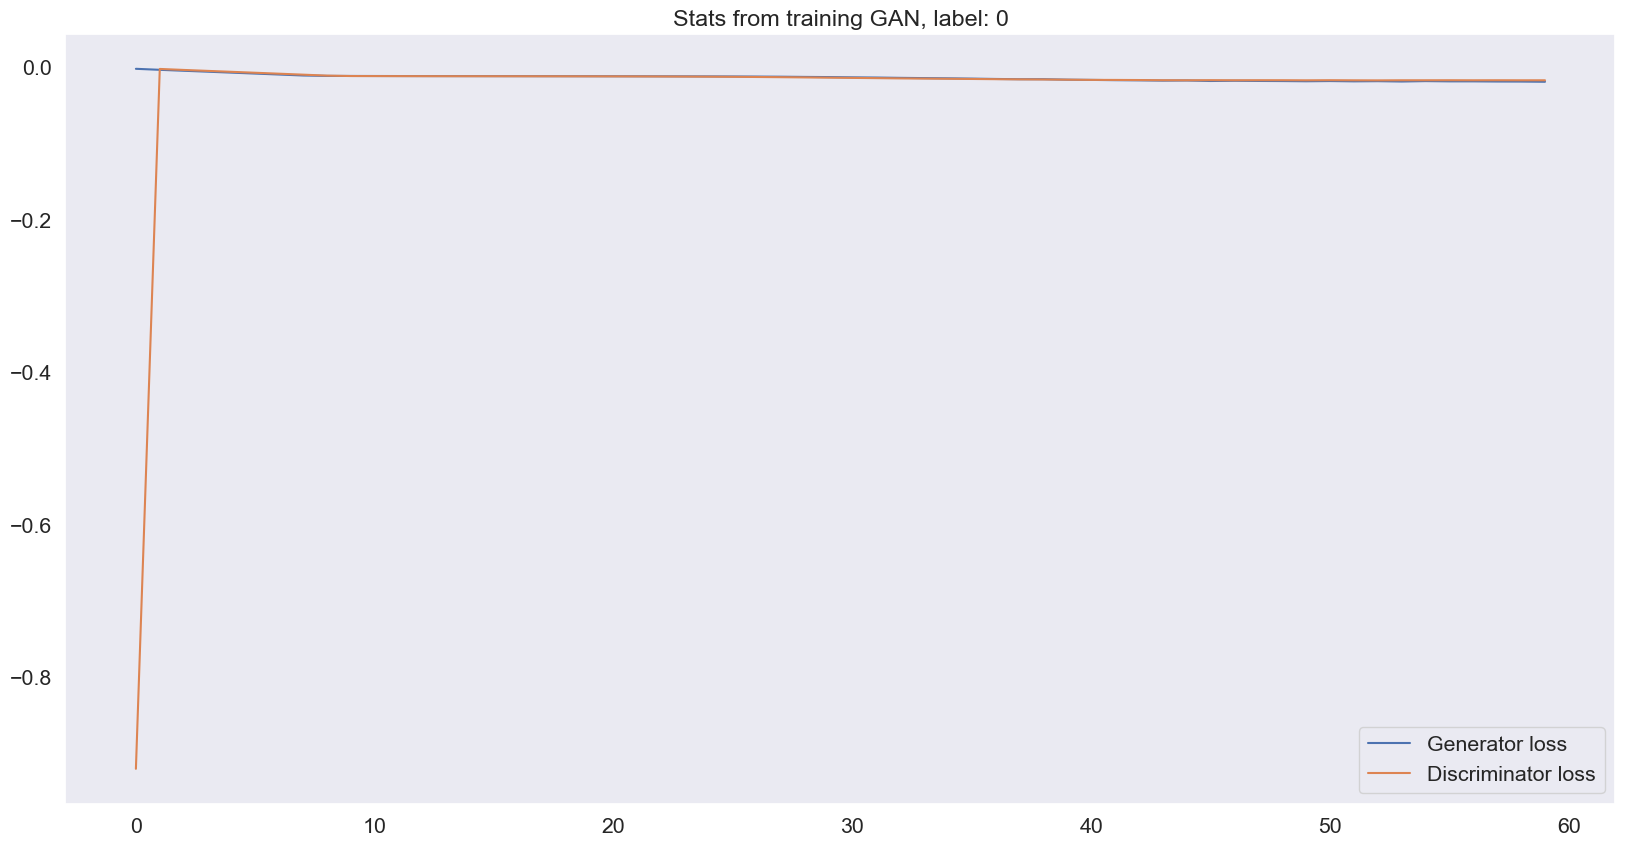

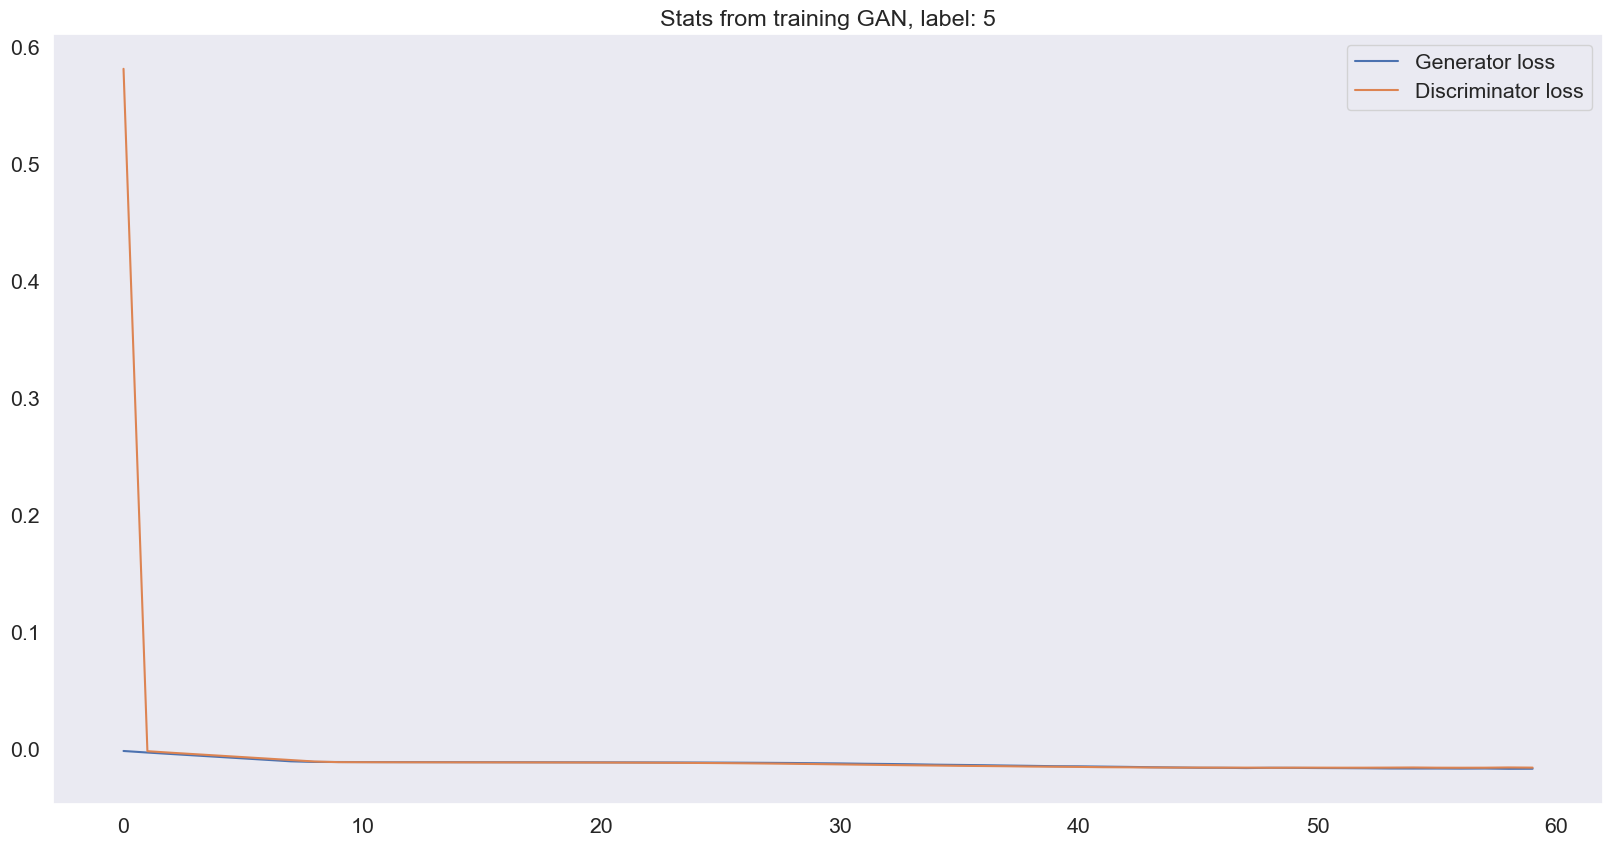

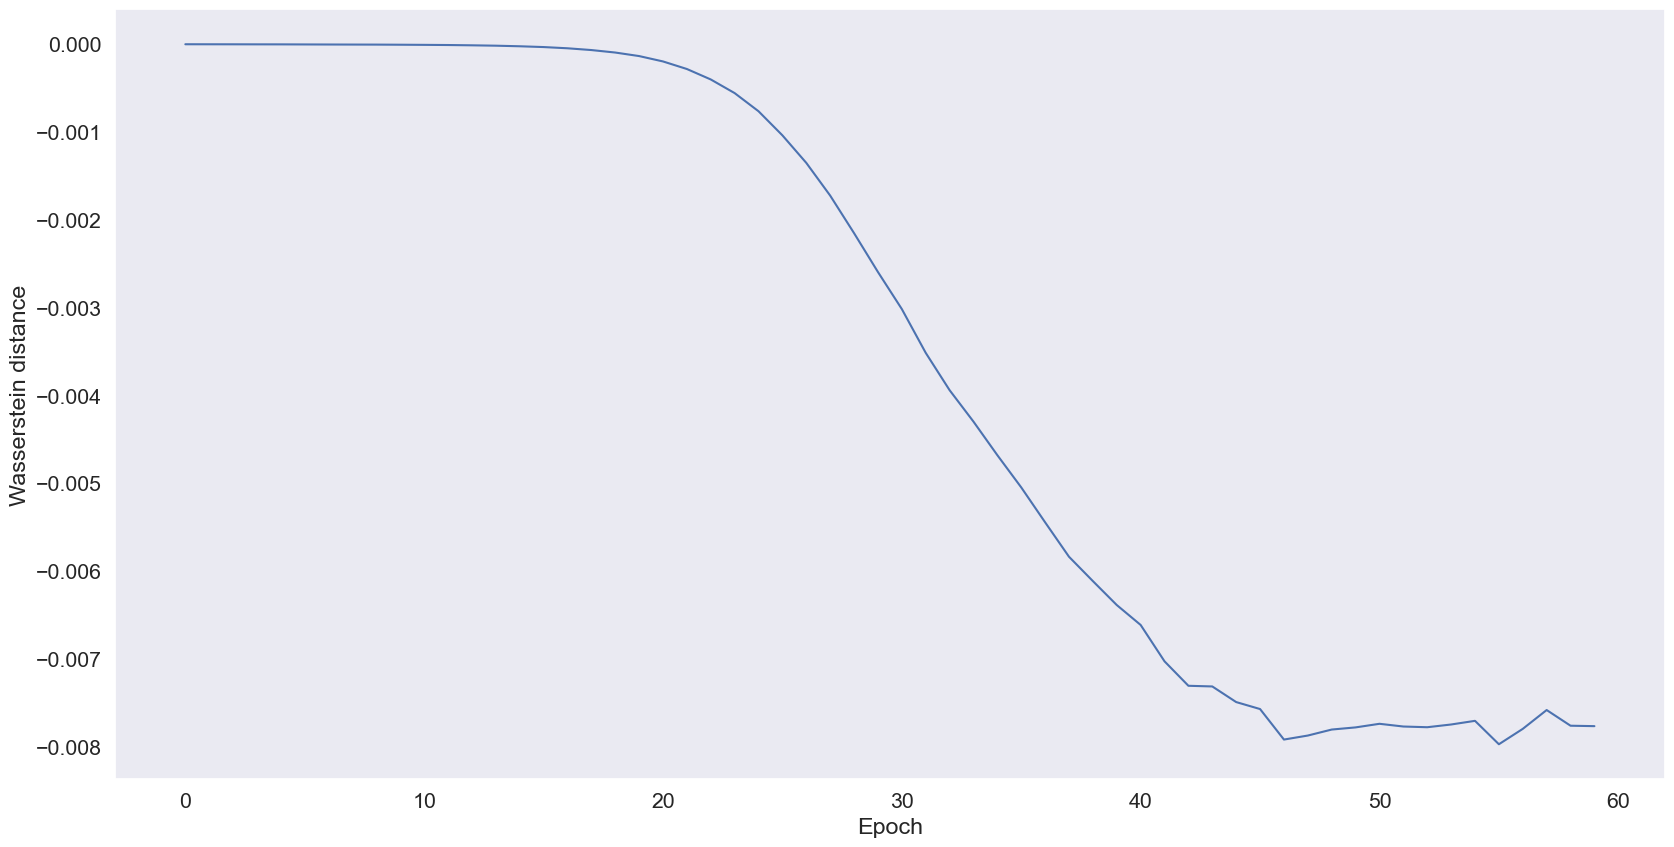

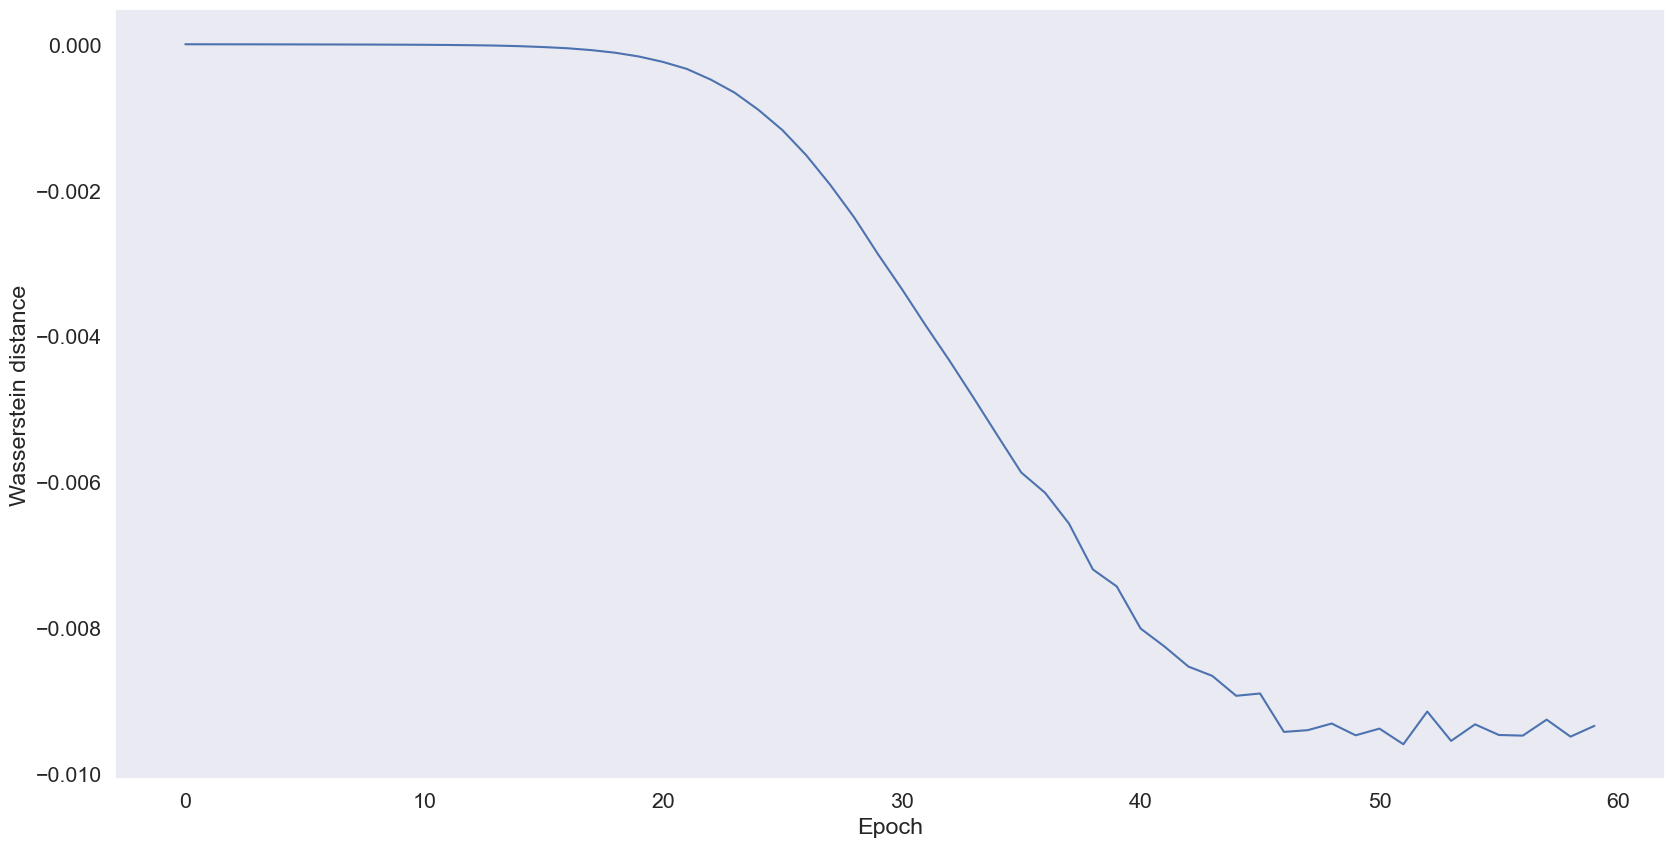

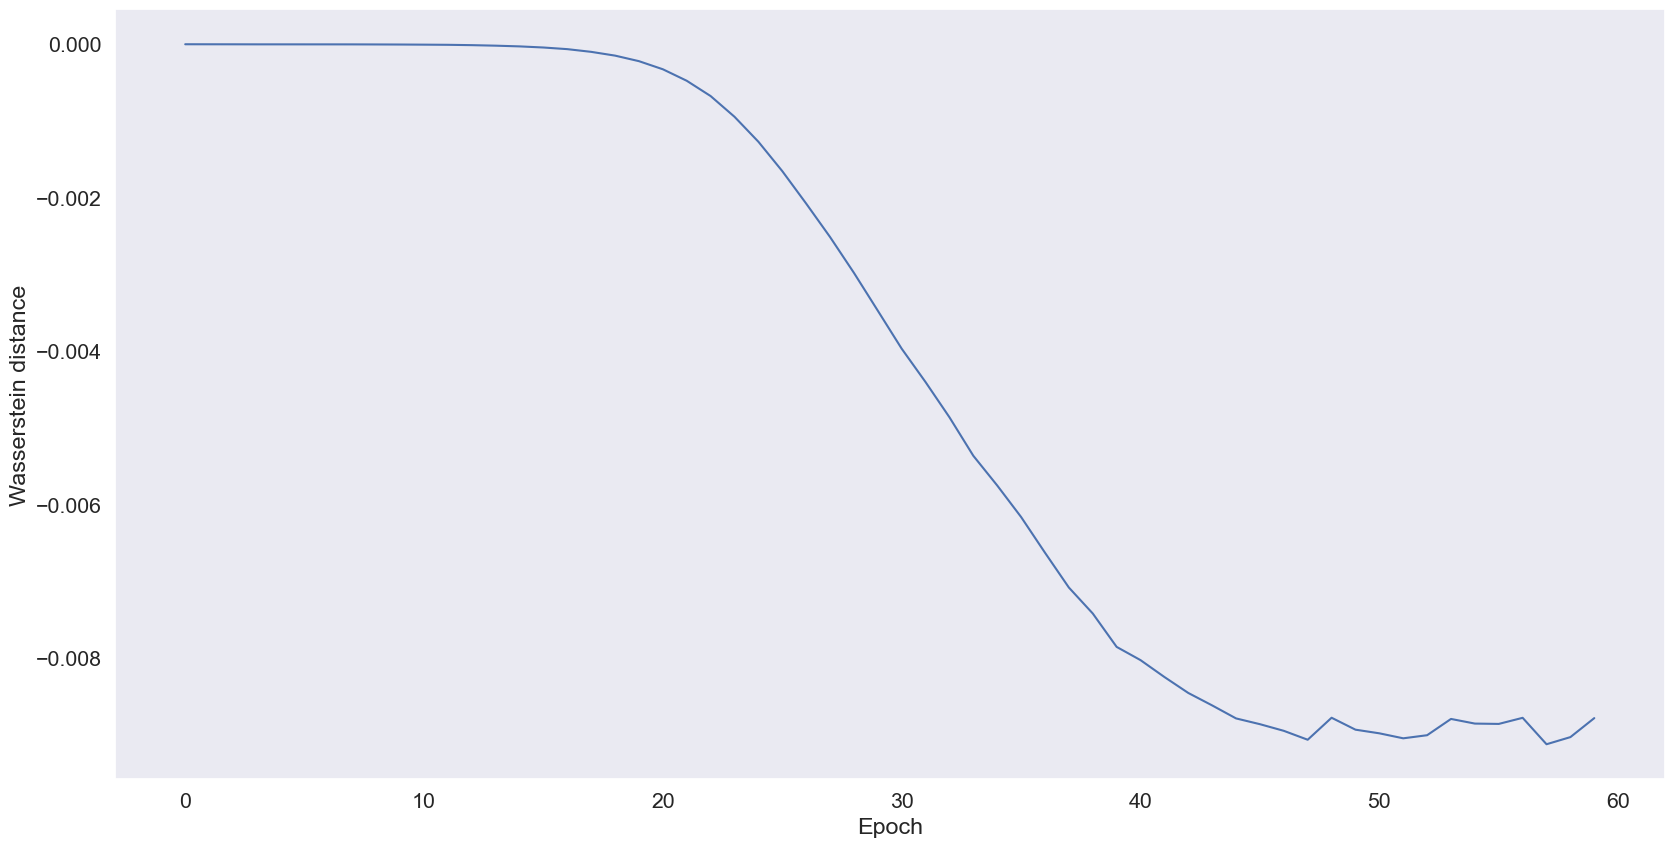

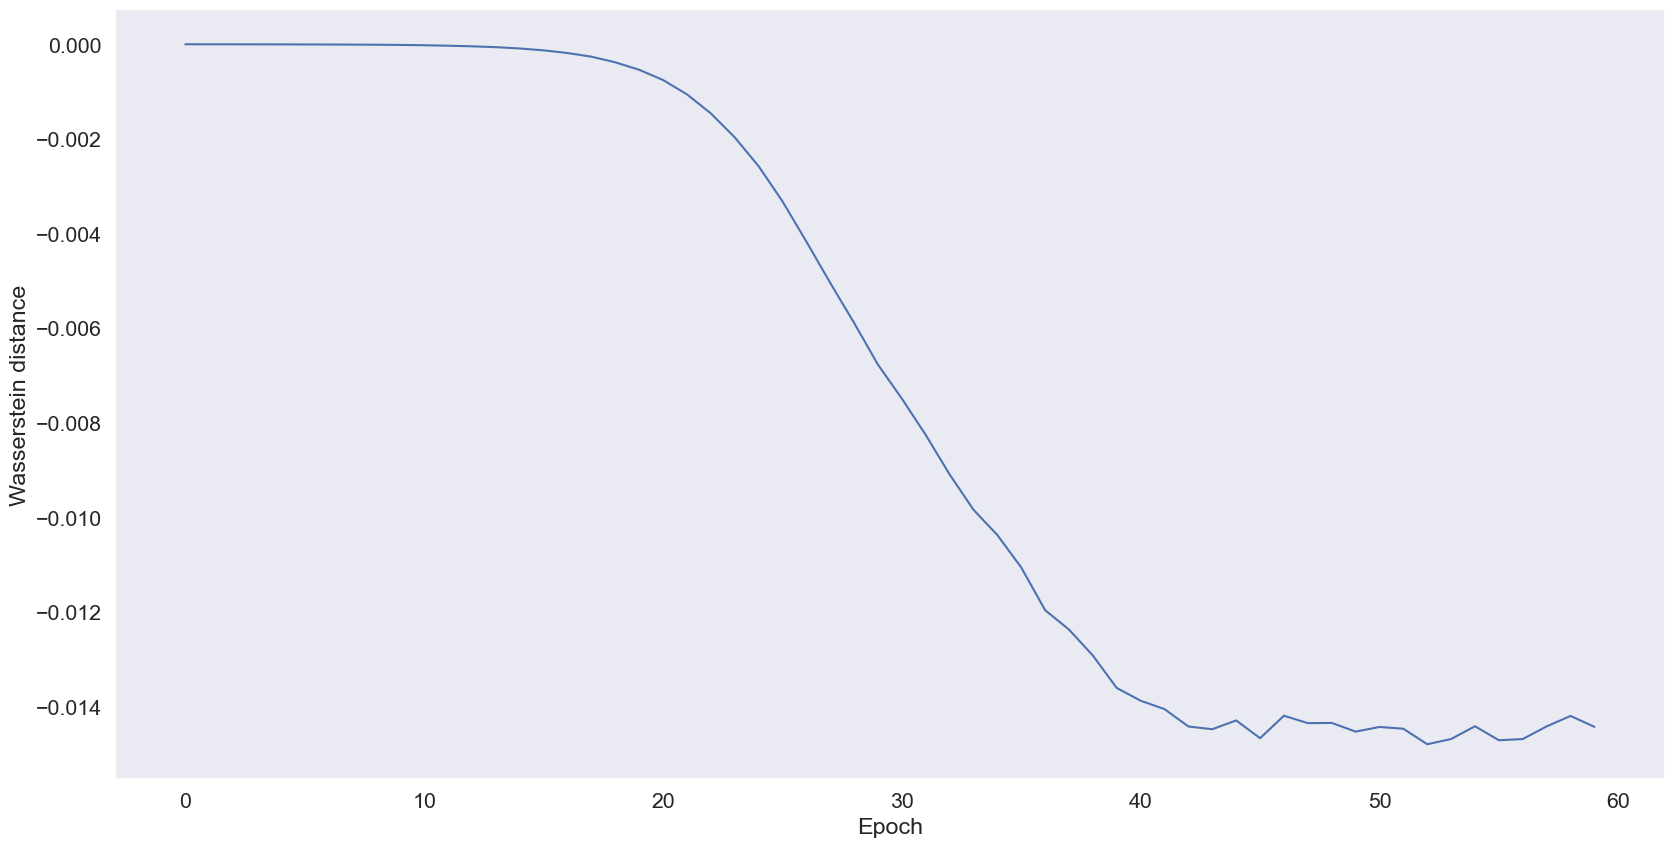

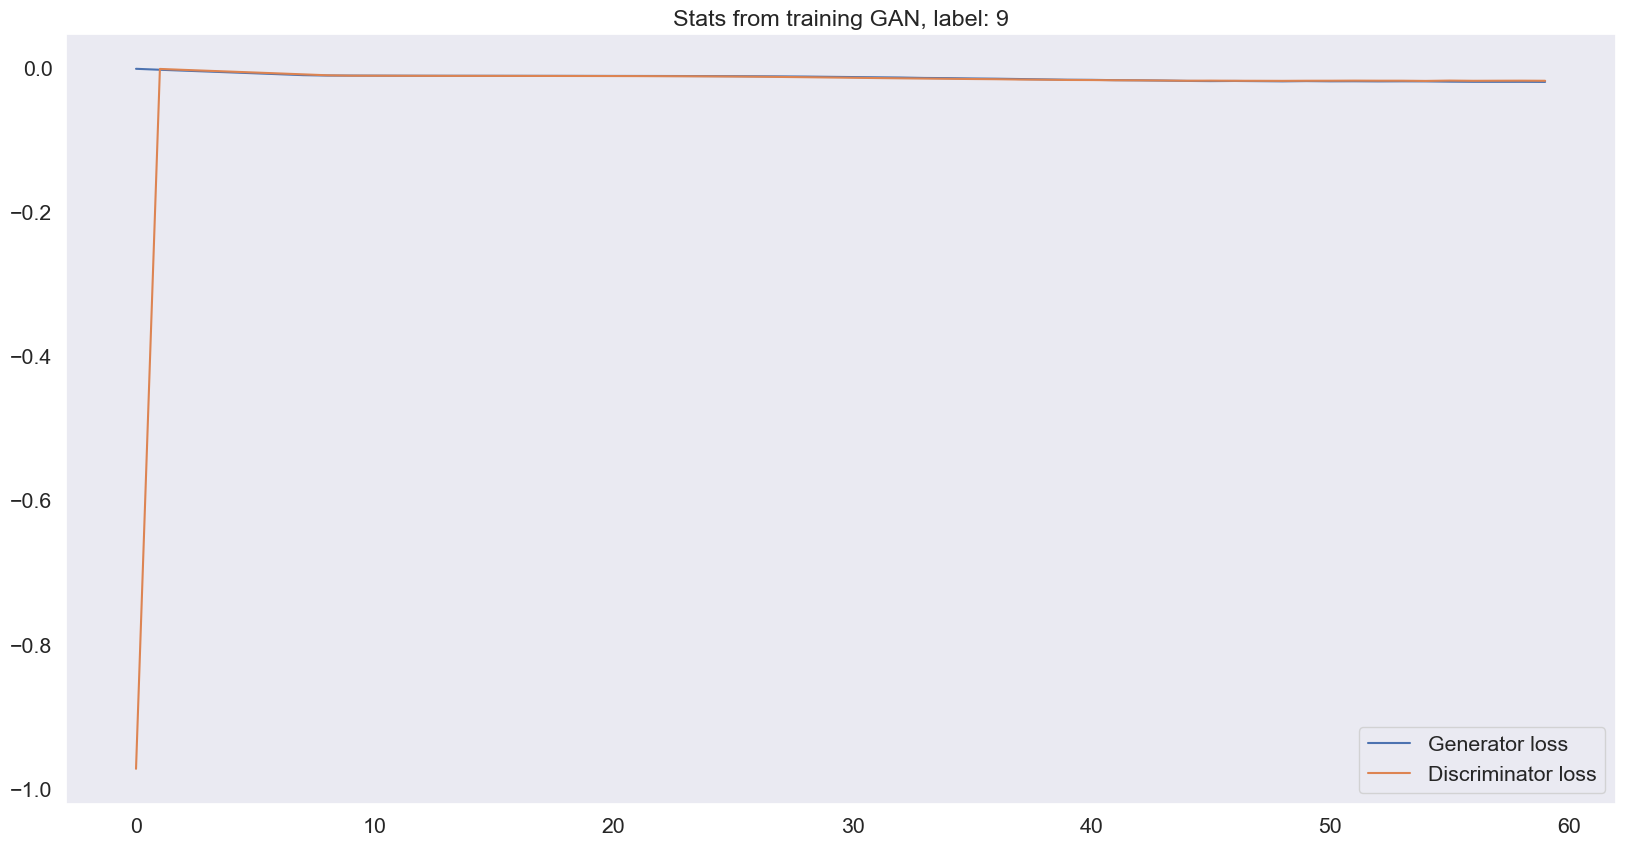

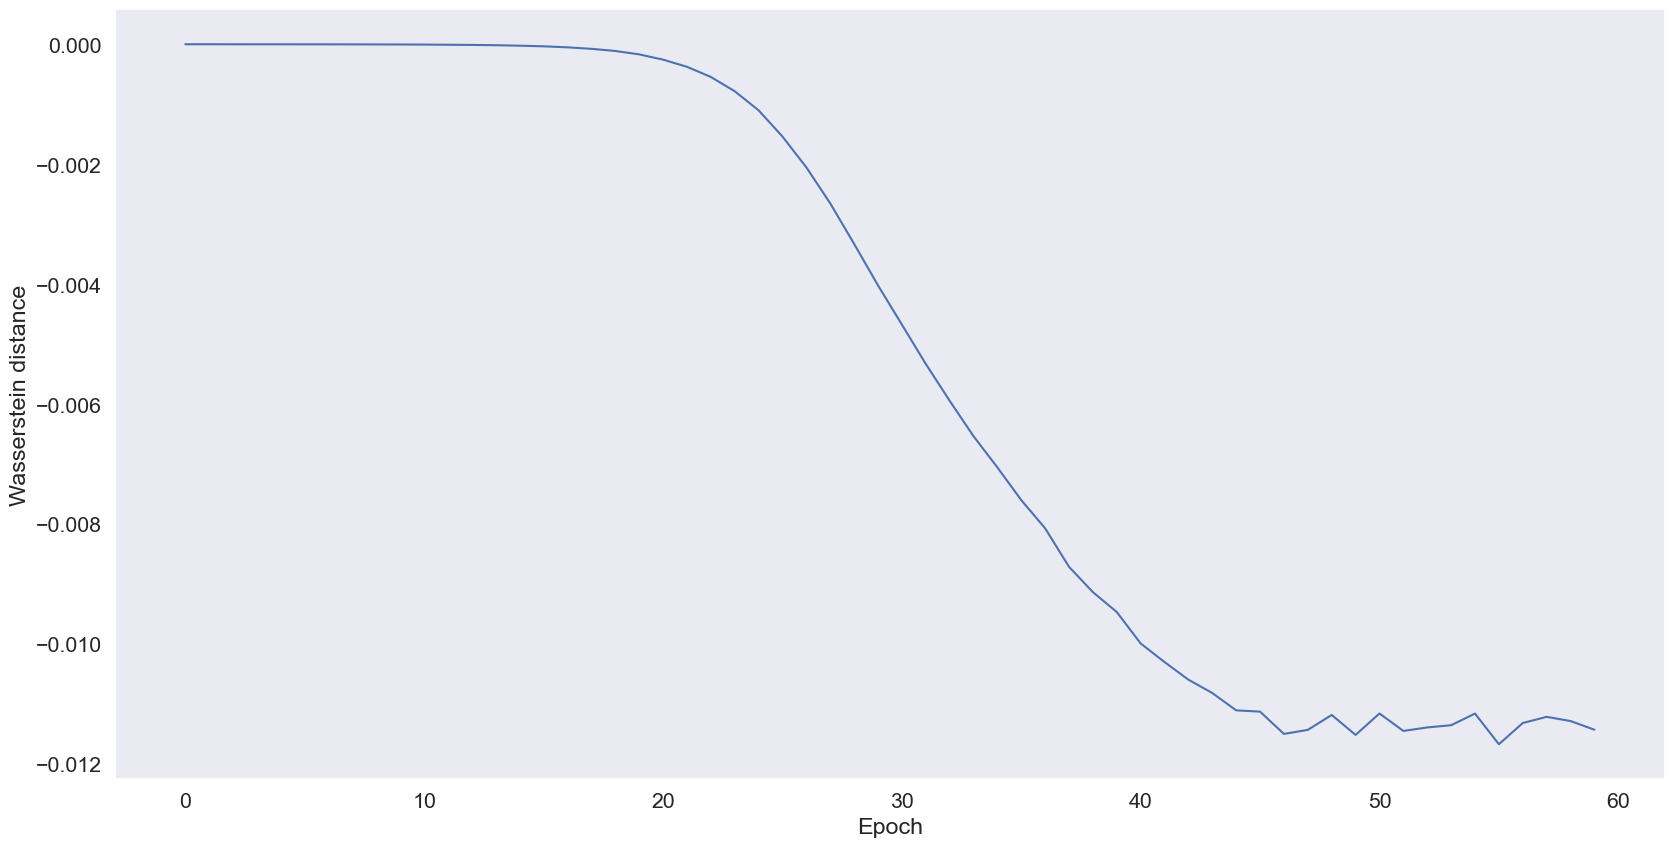

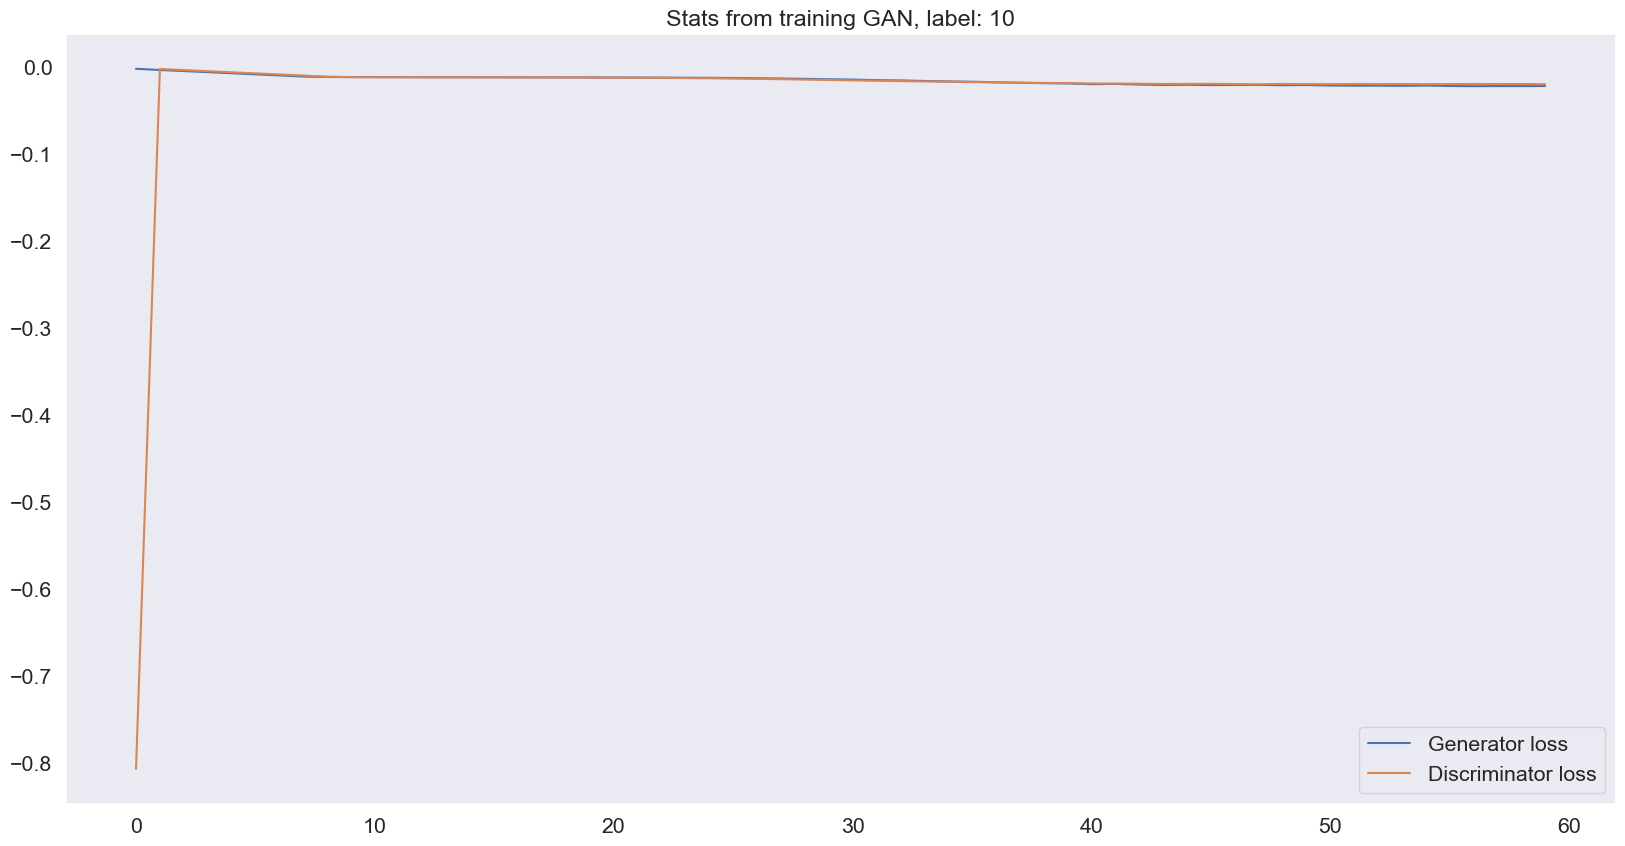

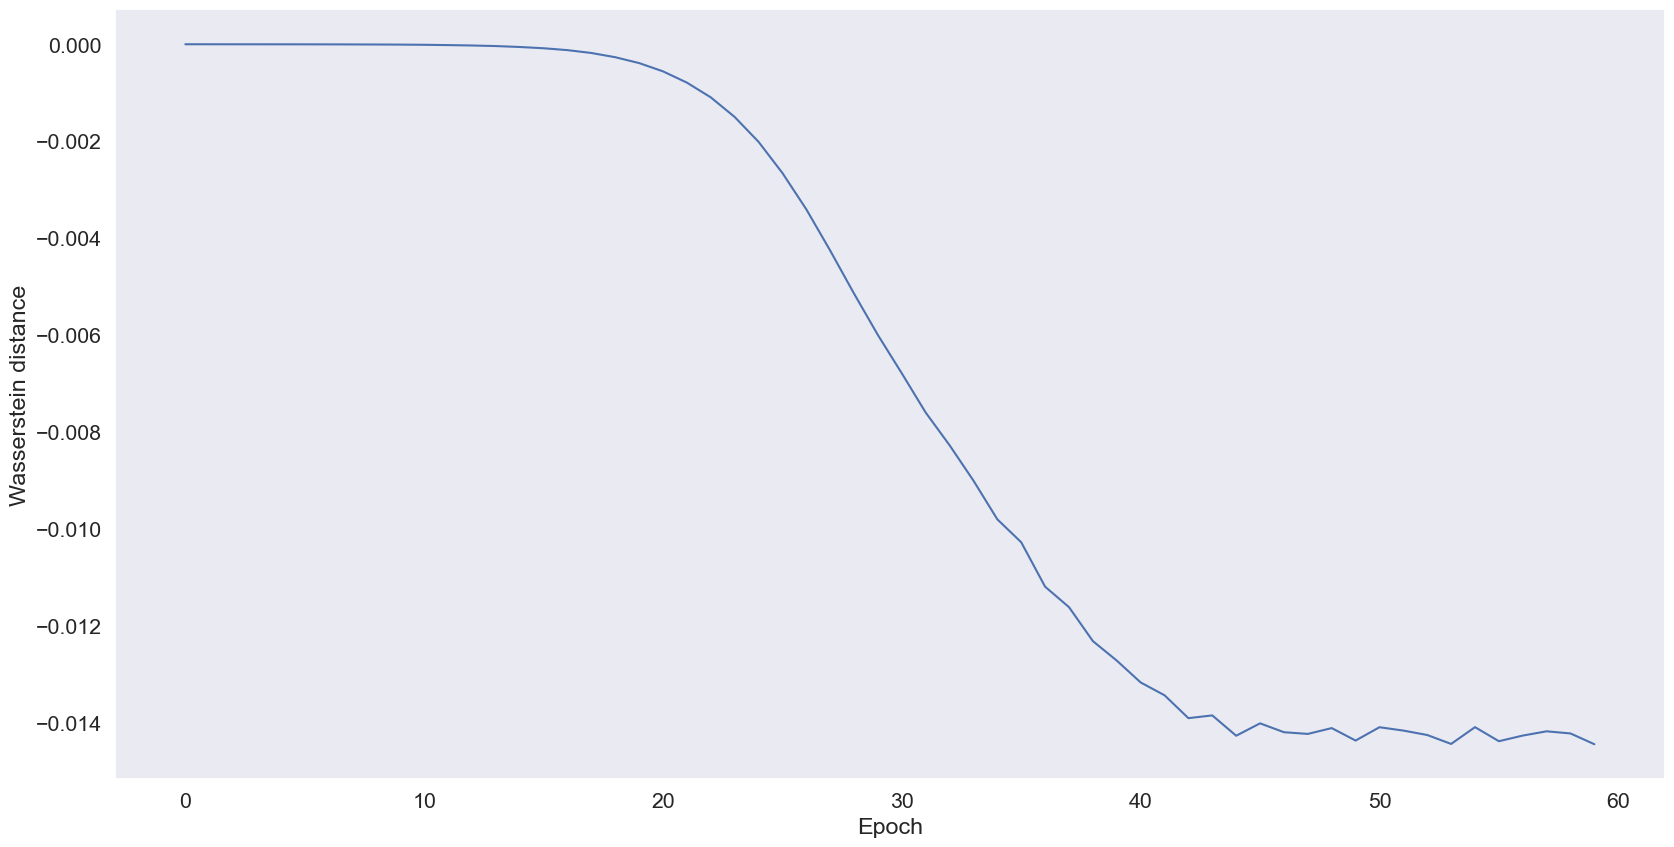

In [107]:
def convert_to_dataframe(arr, c):
    """Convert a numpy array to a pandas dataframe."""
    #print(features.columns)
    return pd.DataFrame(arr, columns=c)

def generate_fake_w_3(real_data, label, num_to_generate, input_dimension, latent_dim, c):
    """Generate synthetic data to balance the specified label."""
#     optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    w_optimizer_3 = RMSprop(learning_rate=0.0001) # 0.00005
    w_generator_3 = build_wgan_generator(input_dimension.shape[1], latent_dim)
    w_discriminator_3 = build_wgan_discriminator(input_dimension.shape[1], w_optimizer_3)
    wgan_3 = build_wgan(w_generator_3, w_discriminator_3, w_optimizer_3)
    train_wgan_2(w_generator_3, w_discriminator_3, wgan_3, real_data, latent_dim, n_epochs=60, n_batch=500, n_eval=250)

    # generate synthetic data to balance the label
    noise = np.random.normal(0, 1, (num_to_generate, latent_dim))
    gen_data = w_generator_3(noise)

    # convert numpy array to dataframe and add label column
    data_generated = convert_to_dataframe(min_max_scaler.inverse_transform(gen_data), c)
    data_generated['label'] = label
    
    return data_generated

input_dimension = fts_test_df.drop(columns=['label'])

# get unique labels and their counts
unique_labels, label_counts = np.unique(fts_train_df['label'], return_counts=True)
target = label_counts.max()
print('Target distribution for test data =', target)

# generate synthetic data for each label with count less than the target count
fake_w_df_3 = pd.DataFrame(columns=list(features.columns) + ['label'])
for label, count in zip(unique_labels, label_counts):
#     if count >= target:
#         continue
#     gen_num = target - count
#     print(f'Generating {gen_num} samples for label {label}')
    gen_num = target - count
    print(f'Generating {gen_num} samples for label {label}')
    if not gen_num:
        continue
    elif gen_num < 0:
        print('ERROR, ERROR: GEN_NUM IS NEGATIVE!')
    else:
        real_data = fts_train_df.loc[fts_train_df['label'] == label]
        fake_data_for_label_w3 = generate_fake_w_3(real_data, label, gen_num, input_dimension, latent_dim=42, c=features.columns)
        print(f'Generated {fake_data_for_label_w3.shape[0]} samples for label {label}')
        fake_w_df_3 = fake_w_df_3.append(fake_data_for_label_w3, ignore_index=True)

In [100]:
# Make sure the column types of generated data is correct
fake_w_df_3 = fake_w_df_3.astype(data.dtypes.to_dict())
fake_w_df_3['label'] = fake_w_df_3['label'].astype('int64')
fake_w_df_3

destination_port  flow_duration  total_fwd_packets  \
0                   11815             -1             139482   
1                       0             -1              86443   
2                    2251         969016             168380   
3                   16021             -1             202619   
4                       0             -1             213326   
...                   ...            ...                ...   
1223875             21892             -1              89927   
1223876             43376             -1             122630   
1223877             28422             -1                  1   
1223878                 0             -1               2638   
1223879             34552             -1              54445   

         total_backward_packets  total_length_of_fwd_packets  \
0                         57112                            0   
1                        162987                            0   
2                             0                            0   
3                         59748                        42816   
4                         88308                            0   
...                         ...                          ...   
1223875                    4065                            0   
1223876                   78088                            0   
1223877                  107826                            0   
1223878                   19315                            0   
1223879                    8029                            0   

         total_length_of_bwd_packets  fwd_packet_length_max  \
0                                  0                      0   
1                                  0                      0   
2                                  0                      0   
3                                  0                      0   
4                                  0                      0   
...                              ...                    ...   
1223875                            0                      0   
1223876                            0                      0   
1223877                    140691961                   1696   
1223878                            0                      0   
1223879                     84378571                      0   

         fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
0                            0             3949.479280               0.000000   
1                          593              364.388831            2087.921883   
2                            0              274.797888               0.000000   
3                          544             1679.715629               0.000000   
4                            0             1318.100838               0.000000   
...                        ...                     ...                    ...   
1223875                      0             1183.445238             506.527366   
1223876                      0              748.097062               0.000000   
1223877                      0             2743.521345               0.000000   
1223878                      0              162.938312               0.000000   
1223879                      0              601.712077               0.000000   

         ...  min_seg_size_forward   active_mean    active_std  active_max  \
0        ...            -536870660  0.000000e+00  0.000000e+00           0   
1        ...            -254563519  0.000000e+00  0.000000e+00           0   
2        ...            -465474003  2.155643e+07  6.959914e+05           0   
3        ...            -433642529  7.146908e+06  7.195759e+06           0   
4        ...            -408196079  1.746503e+07  0.000000e+00           0   
...      ...                   ...           ...           ...         ...   
1223875  ...            -536870660  0.000000e+00  3.051788e+07           0   
1223876  ...            -536870660  0.000000e+00  0.000000e+00     4438406   
1223877  ...            -536870660  0.000000e+00  0

In [81]:
# SAVE fake_data_df
output_path = 'aug_data_w3.csv'
# fake_data_df.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
fake_w_df_3.to_csv(output_path)

IDS Performance on Imbalanced Dataset

In [9]:
data = pd.read_csv('undersampled_data.csv', index_col=0)

In [5]:
fts_train_df = pd.read_csv('fts_train_df.csv', index_col=0)
fts_test_df = pd.read_csv('fts_test_df.csv', index_col=0)

In [6]:
# load the saved label encoder object from a file
with open('label_encoder.pkl', 'rb') as f:
    LE = pickle.load(f)

In [7]:
fts_train_norm = fts_train_df.drop(columns=['label'])
fts_test_norm = fts_test_df.drop(columns=['label'])

# normalize feature data
min_max_scaler = MinMaxScaler().fit(fts_train_norm)
fts_train_norm = min_max_scaler.transform(fts_train_norm)
fts_test_norm = min_max_scaler.transform(fts_test_norm)

lbl_train_df = fts_train_df['label']
lbl_test_df = fts_test_df['label']

In [8]:
lbl_train_arr = lbl_train_df.values
lbl_train_arr = np.array(lbl_train_arr).ravel()
lbl_test_arr = lbl_test_df.values
lbl_test_arr = np.array(lbl_test_arr).ravel()

#split label and feature data 
labels = data[['label']]
labels = np.array(labels).ravel() # ensure it's a 1D array of shape (n_samples, )

features = data.drop(columns=['label'])

#encode labels to numbers
labels = LE.transform(labels)
d = LE.inverse_transform(labels)
d = pd.Series(d)
#print(d.unique())

l_names = data['label'].unique()
#print(l_names)

['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'PortScan' 'SSH-Patator'
 'Web Attack Brute Force']
Epoch 1/10
1097/1097 [==============================] - 41s 36ms/step - loss: 0.5248 - accuracy: 0.8503
Epoch 2/10
1097/1097 [==============================] - 40s 36ms/step - loss: 0.2127 - accuracy: 0.9380
Epoch 3/10
1097/1097 [==============================] - 39s 36ms/step - loss: 0.1593 - accuracy: 0.9522
Epoch 4/10
1097/1097 [==============================] - 37s 34ms/step - loss: 0.1311 - accuracy: 0.9575
Epoch 5/10
1097/1097 [==============================] - 34s 31ms/step - loss: 0.1133 - accuracy: 0.9632
Epoch 6/10
1097/1097 [==============================] - 24s 22ms/step - loss: 0.1013 - accuracy: 0.9670
Epoch 7/10
1097/1097 [==============================] - 39s 35ms/step - loss: 0.0927 - accuracy: 0.9697
Epoch 8/10
1097/1097 [==============================] - 38s 34ms/step - loss: 0.0860 - accuracy: 0.9728
Epoch 9/10
1097/

c:\users\mores\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\mores\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<module 'matplotlib.pyplot' from 'c:\\users\\mores\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>
                        precision    recall  f1-score   support

                BENIGN       0.97      0.95      0.96     68140
                   Bot       0.91      0.63      0.74       587
                  DDoS       1.00      0.99      0.99     38408
         DoS GoldenEye       0.99      0.96      0.97      3088
              DoS Hulk       0.98      1.00      0.99     69037
      DoS Slowhttptest       0.96      0.97      0.97      1650
         DoS slowloris       0.96      0.83      0.89      1739
           FTP-Patator       0.90      1.00      0.94      2380
              PortScan       0.98      1.00      0.99     47641
           SSH-Patator       0.97      0.52      0.68      1769
Web Attack Brute Force       0.57      0.80      0.66       452

              accuracy                           0.98    234891
             macro avg    

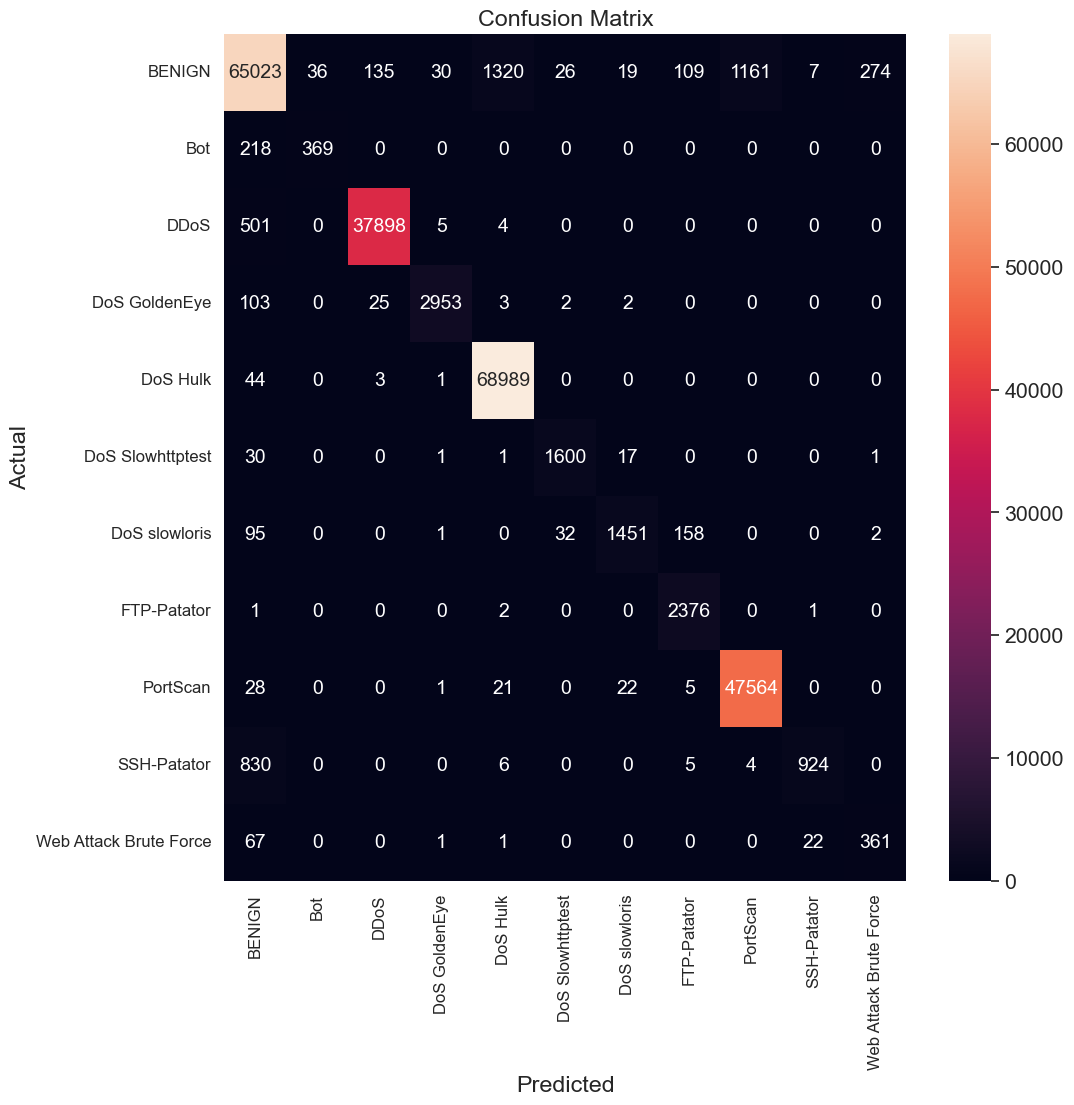

In [49]:
# lbl_train_arr = lbl_train_df.values
# # labels = np.array(labels).ravel()
# lbl_test_arr = lbl_test_df.values
# # labels = np.array(labels).ravel()

# l_names = data['label'].unique()
# print(l_names)

lbl_pred, lbl_test_ids = ids(fts_train_norm, fts_test_norm, lbl_train_arr, lbl_test_arr)

In [ ]:
# note = fts_train_df['label'].unique()
# note

In [ ]:
note = pd.Dataframe([LE.inverse_transform(fts_train_df['label'])], columns=['label'])
note = pd.concat([fts_train_df, note], axis=1)
note

IDS Performance on Augmented Dataset developed by Model 1

In [10]:
fake_data_df = pd.read_csv('aug_data_1.csv', index_col=0)

In [17]:
data['label'].value_counts()

DoS Hulk                  230124
BENIGN                    227132
PortScan                  158804
DDoS                      128025
DoS GoldenEye              10293
FTP-Patator                 7935
SSH-Patator                 5897
DoS slowloris               5796
DoS Slowhttptest            5499
Bot                         1956
Web Attack Brute Force      1507
Name: label, dtype: int64

In [18]:
fake_data_df['label'].value_counts()

10    160032
1     159718
5     157238
6     157030
9     156959
7     155532
3     153882
2      71470
8      49924
0       2095
Name: label, dtype: int64

In [19]:
fts_train_df['label'].value_counts()

4     161087
0     158992
8     111163
2      89617
3       7205
7       5555
9       4128
6       4057
5       3849
1       1369
10      1055
Name: label, dtype: int64

In [ ]:
# min_max_scalar = MinMaxScaler().fit(fake_data_df.drop(columns=['label']))
# fts_norm = min_max_scaler.transform(fake_data_df.drop(columns=['label']))
# fts_norm

# lbl_train_df = fake_data_df['label']

In [11]:
# # concatonate normalised feature data and labels of the original training data
# fts_train_norm_df = convert_to_dataframe(fts_train_norm, features.columns)
# og_full = pd.concat([fts_train_norm_df, lbl_train_df], axis=1)

# Concatonate with fake data to create augmented dataset
aug_1 = pd.concat([fake_data_df, fts_train_df], axis=0)
# shuffle the rows
aug_1 = aug_1.sample(frac=1, random_state=42)
aug_1

destination_port  flow_duration  total_fwd_packets  \
819946                8.0      8475612.0               50.0   
367987               39.0     16351142.0               20.0   
230850              208.0      9615254.0               11.0   
580468                0.0         7079.0                8.0   
1187768               2.0      6017942.0               10.0   
...                   ...            ...                ...   
259178               10.0     10127929.0               21.0   
190534               80.0        41209.0                3.0   
131932            23562.0         1075.0                1.0   
671155               52.0     67020523.0               24.0   
121958             8139.0       676723.0                8.0   

         total_backward_packets  total_length_of_fwd_packets  \
819946                     58.0                        267.0   
367987                     37.0                        299.0   
230850                     12.0                         82.0   
580468                      6.0                          3.0   
1187768                    11.0                         36.0   
...                         ...                          ...   
259178                     47.0                        132.0   
190534                      6.0                         26.0   
131932                      0.0                          0.0   
671155                     34.0                       2792.0   
121958                     13.0                        118.0   

         total_length_of_bwd_packets  fwd_packet_length_max  \
819946                      135160.0                    3.0   
367987                      144129.0                  634.0   
230850                       20876.0                    1.0   
580468                       22312.0                    0.0   
1187768                      26913.0                    1.0   
...                              ...                    ...   
259178                       52856.0                  533.0   
190534                       11601.0                   20.0   
131932                           0.0                    0.0   
671155                       76509.0                  452.0   
121958                       31649.0                  125.0   

         fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
819946                     0.0            8.312264e+00           4.809055e+00   
367987                     0.0            4.706317e+01           1.949711e+02   
230850                     2.0            4.191095e+00           3.242441e-01   
580468                     0.0            1.533950e-02           4.158869e+01   
1187768                    0.0            1.041949e+00           3.682777e-01   
...                        ...                     ...                    ...   
259178                     0.0            9.959959e+01           2.251701e+02   
190534                     0.0            8.666667e+00           1.026320e+01   
131932                     0.0            7.207597e-10           1.105274e-08   
671155                     0.0            1.937750e+02           5.454377e+01   
121958                     0.0            2.863427e+01           5.928193e+01   

         ...  min_seg_size_forward   active_mean    active_std  active_max  \
819946   ...             -377461.0  1.845984e+04  1.585960e+04     23606.0   
367987   ...            -3555221.0  3.439119e+05  1.739394e+04    497747.0   
230850   ...            -1558709.0  1.091640e+04  2.583292e+03     25065.0   
580468   ...             -745301.0  5.488656e+03  1.406810e+04      6424.0   
1187768  ...             -394773.0  3.529714e+03  1.924459e+03      1566.0   
...      ...                   ...           ...           ...         ...   
259178   ...            -1174901.0  2.700054e+05  5.500712e+03    575145.0   
190534   ...                  20.0  0.000000e+00  0.000000e+00         0.0   
131932   ...                 138.0  6.820383e-08  4

In [12]:
# make sure correct data type is being used
aug_1 = aug_1.astype(data.dtypes.to_dict())
aug_1['label'] = aug_1['label'].astype('int64')
aug_1

destination_port  flow_duration  total_fwd_packets  \
819946                  8        8475612                 50   
367987                 39       16351142                 20   
230850                208        9615254                 11   
580468                  0           7079                  8   
1187768                 2        6017942                 10   
...                   ...            ...                ...   
259178                 10       10127929                 21   
190534                 80          41209                  3   
131932              23562           1075                  1   
671155                 52       67020523                 24   
121958               8139         676723                  8   

         total_backward_packets  total_length_of_fwd_packets  \
819946                       58                          267   
367987                       37                          299   
230850                       12                           82   
580468                        6                            3   
1187768                      11                           36   
...                         ...                          ...   
259178                       47                          132   
190534                        5                           26   
131932                        0                            0   
671155                       34                         2792   
121958                       13                          118   

         total_length_of_bwd_packets  fwd_packet_length_max  \
819946                        135160                      3   
367987                        144129                    634   
230850                         20876                      1   
580468                         22312                      0   
1187768                        26913                      1   
...                              ...                    ...   
259178                         52856                    533   
190534                         11601                     20   
131932                             0                      0   
671155                         76509                    452   
121958                         31649                    125   

         fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
819946                       0            8.312264e+00           4.809055e+00   
367987                       0            4.706317e+01           1.949711e+02   
230850                       2            4.191095e+00           3.242441e-01   
580468                       0            1.533950e-02           4.158869e+01   
1187768                      0            1.041949e+00           3.682777e-01   
...                        ...                     ...                    ...   
259178                       0            9.959959e+01           2.251701e+02   
190534                       0            8.666667e+00           1.026320e+01   
131932                       0            7.207597e-10           1.105274e-08   
671155                       0            1.937750e+02           5.454377e+01   
121958                       0            2.863427e+01           5.928193e+01   

         ...  min_seg_size_forward   active_mean    active_std  active_max  \
819946   ...               -377461  1.845984e+04  1.585960e+04       23606   
367987   ...              -3555221  3.439119e+05  1.739394e+04      497747   
230850   ...              -1558709  1.091640e+04  2.583292e+03       25065   
580468   ...               -745301  5.488656e+03  1.406810e+04        6424   
1187768  ...               -394773  3.529714e+03  1.924459e+03        1566   
...      ...                   ...           ...           ...         ...   
259178   ...              -1174901  2.700054e+05  5.500712e+03      575145   
190534   ...                    19  0.000000e+00  0.000000e+00           0   
131932   ...                   138  6.820383e-08  4

In [58]:
# Normalise features
min_max_scalar = MinMaxScaler().fit(aug_1.drop(columns=['label']))
aug_fts_train = min_max_scaler.transform(aug_1.drop(columns=['label']))
aug_fts_train

array([[1.22077764e-04, 7.06301125e-02, 2.44079819e-04, ...,
        2.06620171e-04, 2.36683333e-04, 3.69158333e-04],
       [5.95129097e-04, 1.36259533e-01, 9.46431952e-05, ...,
        1.69190229e-04, 9.18485667e-02, 7.92609667e-02],
       [3.17402185e-03, 8.01271297e-02, 4.98122080e-05, ...,
        2.14886910e-04, 6.71337917e-02, 1.04634017e-01],
       ...,
       [3.59549533e-01, 8.96666719e-06, 0.00000000e+00, ...,
        2.77454757e-17, 0.00000000e+00, 0.00000000e+00],
       [7.93505463e-04, 5.58504399e-01, 1.14568078e-04, ...,
        6.75258487e-02, 1.39947142e-01, 5.74351000e-02],
       [1.24198865e-01, 5.63936700e-03, 3.48685456e-05, ...,
        6.87303545e-05, 5.24750000e-05, 5.59000000e-05]])

In [30]:
fts_test_norm

array([[4.46346823e-02, 1.58333343e-07, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.88878716e-02, 2.41666681e-07, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.22077764e-03, 1.25550674e-02, 9.96244160e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.78294574e-02, 1.08333340e-07, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00054935e-02, 1.45833342e-06, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.76005616e-03, 1.05000006e-06, 9.96244160e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [22]:
aug_1['label'].value_counts()

0     161087
1     161087
2     161087
3     161087
5     161087
6     161087
7     161087
8     161087
9     161087
10    161087
4     161087
Name: label, dtype: int64

In [59]:
aug_lbl_train = aug_1['label'].values
# np.array(lbl_train_arr).ravel()

Epoch 1/10
3544/3544 [==============================] - 53s 14ms/step - loss: 0.3753 - accuracy: 0.9013
Epoch 2/10
3544/3544 [==============================] - 51s 14ms/step - loss: 0.0837 - accuracy: 0.9788
Epoch 3/10
3544/3544 [==============================] - 50s 14ms/step - loss: 0.0530 - accuracy: 0.9856
Epoch 4/10
3544/3544 [==============================] - 51s 14ms/step - loss: 0.0410 - accuracy: 0.9886
Epoch 5/10
3544/3544 [==============================] - 50s 14ms/step - loss: 0.0347 - accuracy: 0.9906
Epoch 6/10
3544/3544 [==============================] - 50s 14ms/step - loss: 0.0309 - accuracy: 0.9918
Epoch 7/10
3544/3544 [==============================] - 51s 14ms/step - loss: 0.0284 - accuracy: 0.9924
Epoch 8/10
3544/3544 [==============================] - 51s 14ms/step - loss: 0.0265 - accuracy: 0.9929
Epoch 9/10
3544/3544 [==============================] - 50s 14ms/step - loss: 0.0249 - accuracy: 0.9932
Epoch 10/10
3544/3544 [==============================] - 50s 14m

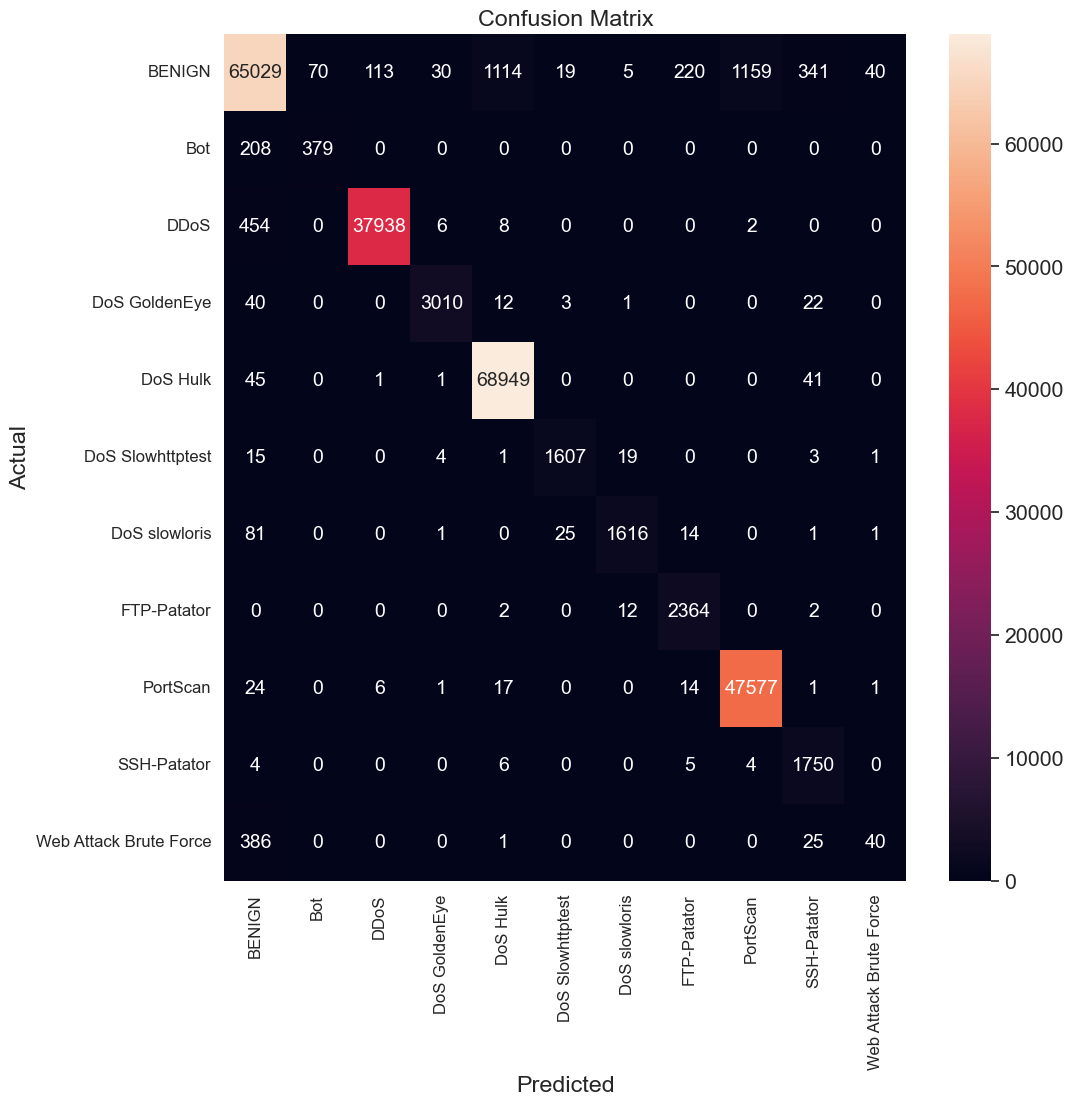

In [60]:
lbl_pred, lbl_test_ids = ids(aug_fts_train, fts_test_norm, aug_lbl_train, lbl_test_arr)

IDS Performance on Augmented Dataset developed by WGAN (Model 2)

In [13]:
fake_w_df = pd.read_csv('aug_data_2.csv', index_col=0)

In [47]:
# join original dataset with aug_data
aug_2 = pd.concat([fake_w_df, fts_train_df], axis=0)
# shuffle the rows
aug_2 = aug_2.sample(frac=1, random_state=42)
aug_2

destination_port  flow_duration  total_fwd_packets  \
819946           -18157.0    -21629783.0           174835.0   
367987            54203.0     90100801.0           148463.0   
230850           -32640.0    -32674150.0            24088.0   
580468            -3109.0    -95676429.0           145759.0   
1187768            6225.0     17240742.0           -96542.0   
...                   ...            ...                ...   
259178            12726.0     92185421.0           124985.0   
190534               80.0        41209.0                3.0   
131932           -50721.0     22197412.0           -44269.0   
671155            33675.0    -90345972.0           176358.0   
121958           -49029.0     17481014.0           -82471.0   

         total_backward_packets  total_length_of_fwd_packets  \
819946                  72520.0                   -1095728.0   
367987                  10920.0                   -1007811.0   
230850                  40618.0                    -193488.0   
580468                -144691.0                   -1054009.0   
1187768                258356.0                      29827.0   
...                         ...                          ...   
259178                -118913.0                    -894142.0   
190534                      6.0                         26.0   
131932                 203634.0                    -721762.0   
671155                  26128.0                    -966611.0   
121958                 233056.0                    -885665.0   

         total_length_of_bwd_packets  fwd_packet_length_max  \
819946                     6857445.0               -16484.0   
367987                     7979508.0                -2655.0   
230850                   133562422.0               -18509.0   
580468                   396916330.0               -23782.0   
1187768                  -76269378.0                 4976.0   
...                              ...                    ...   
259178                  -144856208.0                 6484.0   
190534                       11601.0                   20.0   
131932                   258483769.0                -6784.0   
671155                   410617441.0               -20494.0   
121958                   195504700.0               -11369.0   

         fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
819946                    83.0              507.857516            -850.847968   
367987                   596.0            -3489.301956            5467.826684   
230850                  -912.0             3565.720501            1463.751584   
580468                  1489.0            -3756.083623            1341.955686   
1187768                 -840.0             4288.419637           -1289.460781   
...                        ...                     ...                    ...   
259178                  1444.0            -4079.070238            5780.411587   
190534                     0.0                8.666667              10.263203   
131932                   755.0            -2873.217117           -5023.220462   
671155                  1456.0            -3514.719446            -452.033607   
121958                  -386.0            -2505.922519           -5195.945985   

         ...  min_seg_size_forward   active_mean    active_std  active_max  \
819946   ...          -407161527.0  4.568356e+07  5.830984e+06 -29114199.0   
367987   ...          -144832055.0 -4.213317e+07 -1.859787e+07 -47105326.0   
230850   ...          -806001386.0  5.039509e+07 -1.864964e+07  65266064.0   
580468   ...          -900380150.0  2.823157e+07 -1.823973e+07 -15886481.0   
1187768  ...          -165569426.0 -8.821291e+06  4.085033e+07  30249153.0   
...      ...                   ...           ...           ...         ...   
259178   ...          -216367464.0 -1.229451e+07 -2.500304e+07 -61976340.0   
190534   ...                  20.0  0.000000e+00  0.000000e+00         0.0   
131932   ...          -979649349.0 -2.727372e+07 -4

In [48]:
# make sure correct data type is being used
aug_2 = aug_2.astype(data.dtypes.to_dict())
aug_2['label'] = aug_2['label'].astype('int64')
aug_2

destination_port  flow_duration  total_fwd_packets  \
819946             -18157      -21629783             174835   
367987              54203       90100801             148463   
230850             -32640      -32674150              24088   
580468              -3109      -95676429             145759   
1187768              6225       17240742             -96542   
...                   ...            ...                ...   
259178              12726       92185421             124985   
190534                 80          41209                  3   
131932             -50721       22197412             -44269   
671155              33675      -90345972             176358   
121958             -49029       17481014             -82471   

         total_backward_packets  total_length_of_fwd_packets  \
819946                    72520                     -1095728   
367987                    10920                     -1007811   
230850                    40618                      -193488   
580468                  -144691                     -1054009   
1187768                  258356                        29827   
...                         ...                          ...   
259178                  -118913                      -894142   
190534                        5                           26   
131932                   203634                      -721762   
671155                    26128                      -966611   
121958                   233056                      -885665   

         total_length_of_bwd_packets  fwd_packet_length_max  \
819946                       6857445                 -16484   
367987                       7979508                  -2655   
230850                     133562422                 -18509   
580468                     396916330                 -23782   
1187768                    -76269378                   4976   
...                              ...                    ...   
259178                    -144856208                   6484   
190534                         11601                     20   
131932                     258483769                  -6784   
671155                     410617441                 -20494   
121958                     195504700                 -11369   

         fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
819946                      83              507.857516            -850.847968   
367987                     596            -3489.301956            5467.826684   
230850                    -912             3565.720501            1463.751584   
580468                    1489            -3756.083623            1341.955686   
1187768                   -840             4288.419637           -1289.460781   
...                        ...                     ...                    ...   
259178                    1444            -4079.070238            5780.411587   
190534                       0                8.666667              10.263203   
131932                     755            -2873.217117           -5023.220462   
671155                    1456            -3514.719446            -452.033607   
121958                    -386            -2505.922519           -5195.945985   

         ...  min_seg_size_forward   active_mean    active_std  active_max  \
819946   ...            -407161527  4.568356e+07  5.830984e+06   -29114199   
367987   ...            -144832055 -4.213317e+07 -1.859787e+07   -47105326   
230850   ...            -806001386  5.039509e+07 -1.864964e+07    65266064   
580468   ...            -900380150  2.823157e+07 -1.823973e+07   -15886481   
1187768  ...            -165569426 -8.821291e+06  4.085033e+07    30249153   
...      ...                   ...           ...           ...         ...   
259178   ...            -216367464 -1.229451e+07 -2.500304e+07   -61976340   
190534   ...                    19  0.000000e+00  0.000000e+00           0   
131932   ...            -979649349 -2.727372e+07 -4

In [49]:
aug_2['label'].value_counts()

7     161087
3     161087
2     161087
6     161087
10    161087
1     161087
9     161087
4     161087
8     161087
0     161087
5     161087
Name: label, dtype: int64

In [50]:
# Normalise features
min_max_scalar = MinMaxScaler().fit(aug_2.drop(columns=['label']))
aug_fts_train_2 = min_max_scaler.transform(aug_2.drop(columns=['label']))
aug_fts_train_2

array([[-0.27707074, -0.18024819,  0.87088676, ..., -0.77385241,
         0.27345955, -0.44956213],
       [ 0.82712263,  0.75084006,  0.739522  , ...,  0.56734622,
         0.8289414 ,  0.09642672],
       [-0.49807728, -0.27228459,  0.11998267, ...,  0.02541282,
        -0.33225581,  0.35673108],
       ...,
       [-0.77398828,  0.18497845, -0.22051864, ...,  0.02442735,
         0.61134993, -0.67047643],
       [ 0.51387109, -0.75288314,  0.87847316, ..., -0.79835671,
        -0.90658414,  0.02779021],
       [-0.74816883,  0.14567513, -0.41081124, ...,  0.07954545,
        -0.45259478, -0.46595972]])

In [51]:
aug_lbl_train_2 = aug_2['label'].values

Epoch 1/10
3544/3544 [==============================] - 55s 15ms/step - loss: 0.1549 - accuracy: 0.9563
Epoch 2/10
3544/3544 [==============================] - 51s 14ms/step - loss: 0.0583 - accuracy: 0.9828
Epoch 3/10
3544/3544 [==============================] - 52s 15ms/step - loss: 0.0440 - accuracy: 0.9863
Epoch 4/10
3544/3544 [==============================] - 52s 15ms/step - loss: 0.0374 - accuracy: 0.9880
Epoch 5/10
3544/3544 [==============================] - 52s 15ms/step - loss: 0.0334 - accuracy: 0.9892
Epoch 6/10
3544/3544 [==============================] - 52s 15ms/step - loss: 0.0306 - accuracy: 0.9901
Epoch 7/10
3544/3544 [==============================] - 54s 15ms/step - loss: 0.0285 - accuracy: 0.9910
Epoch 8/10
3544/3544 [==============================] - 51s 14ms/step - loss: 0.0267 - accuracy: 0.9917
Epoch 9/10
3544/3544 [==============================] - 52s 15ms/step - loss: 0.0252 - accuracy: 0.9922
Epoch 10/10
3544/3544 [==============================] - 51s 15m

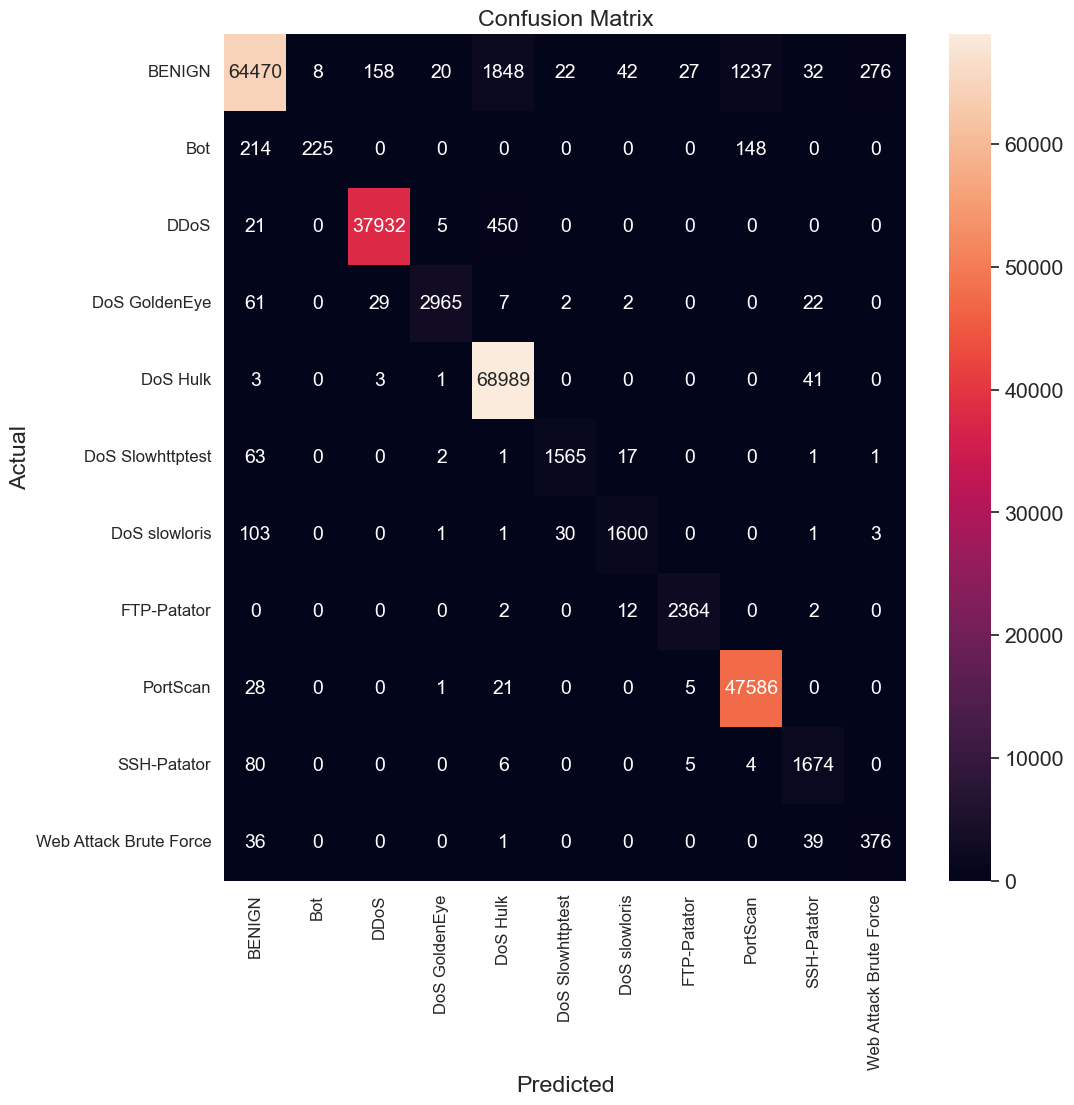

In [52]:
lbl_pred, lbl_test_ids = ids(aug_fts_train_2, fts_test_norm, aug_lbl_train_2, lbl_test_arr)

IDS Performance on Model 2 Config 2

In [13]:
fake_w_df_2 = pd.read_csv('aug_data_w2.csv', index_col=0)

In [84]:
# join original dataset with aug_data
aug_w2 = pd.concat([fake_w_df_2, fts_train_df], axis=0)
# shuffle the rows
aug_w2 = aug_w2.sample(frac=1, random_state=42)
aug_w2

destination_port  flow_duration  total_fwd_packets  \
819946            60556.0      1697672.0            13603.0   
367987                0.0     47633968.0                1.0   
230850            10099.0     21264593.0             1635.0   
580468            46692.0           -1.0                1.0   
1187768           20989.0     99199040.0            20822.0   
...                   ...            ...                ...   
259178            17023.0     54477055.0            25168.0   
190534               80.0        41209.0                3.0   
131932             9529.0     50714238.0           187613.0   
671155            58319.0     47791088.0            39210.0   
121958                0.0      1322423.0           160129.0   

         total_backward_packets  total_length_of_fwd_packets  \
819946                 168219.0                      52579.0   
367987                      0.0                     268781.0   
230850                      0.0                          0.0   
580468                  64196.0                     710891.0   
1187768                     0.0                          0.0   
...                         ...                          ...   
259178                  18884.0                     629718.0   
190534                      6.0                         26.0   
131932                      0.0                     278425.0   
671155                 216964.0                     533762.0   
121958                      0.0                          0.0   

         total_length_of_bwd_packets  fwd_packet_length_max  \
819946                           0.0                12098.0   
367987                    11377211.0                 6906.0   
230850                   232778294.0                 7467.0   
580468                           0.0                    0.0   
1187768                  775345945.0                    0.0   
...                              ...                    ...   
259178                    55259928.0                17124.0   
190534                       11601.0                   20.0   
131932                    92739368.0                    0.0   
671155                           0.0                 3663.0   
121958                           0.0                    0.0   

         fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
819946                     0.0                0.000000               0.000000   
367987                     0.0                0.000000               0.000000   
230850                     0.0                0.000000               0.000000   
580468                   296.0                0.000000               0.000000   
1187768                 1330.0                0.000000               0.000000   
...                        ...                     ...                    ...   
259178                     0.0                0.000000            2422.747181   
190534                     0.0                8.666667              10.263203   
131932                   601.0              256.734026            7191.123816   
671155                   598.0                0.000000               0.000000   
121958                   152.0                0.000000            6867.191924   

         ...  min_seg_size_forward   active_mean    active_std  active_max  \
819946   ...          -228479973.0  4.487301e+07  1.574163e+07         0.0   
367987   ...          -536870660.0  5.889088e+06  1.709016e+07  29876026.0   
230850   ...          -430684394.0  0.000000e+00  0.000000e+00         0.0   
580468   ...          -478101568.0  0.000000e+00  0.000000e+00  32308863.0   
1187768  ...          -137134648.0  0.000000e+00  0.000000e+00  22407533.0   
...      ...                   ...           ...           ...         ...   
259178   ...          -536870660.0  1.241002e+07  1.856374e+07         0.0   
190534   ...                  20.0  0.000000e+00  0.000000e+00         0.0   
131932   ...          -197202636.0  0.000000e+00  1

In [85]:
# make sure correct data type is being used
aug_w2 = aug_w2.astype(data.dtypes.to_dict())
aug_w2['label'] = aug_w2['label'].astype('int64')
aug_w2

destination_port  flow_duration  total_fwd_packets  \
819946              60556        1697672              13603   
367987                  0       47633968                  1   
230850              10099       21264593               1635   
580468              46692             -1                  1   
1187768             20989       99199040              20822   
...                   ...            ...                ...   
259178              17023       54477055              25168   
190534                 80          41209                  3   
131932               9529       50714238             187613   
671155              58319       47791088              39210   
121958                  0        1322423             160129   

         total_backward_packets  total_length_of_fwd_packets  \
819946                   168219                        52579   
367987                        0                       268781   
230850                        0                            0   
580468                    64196                       710891   
1187768                       0                            0   
...                         ...                          ...   
259178                    18884                       629718   
190534                        5                           26   
131932                        0                       278425   
671155                   216964                       533762   
121958                        0                            0   

         total_length_of_bwd_packets  fwd_packet_length_max  \
819946                             0                  12098   
367987                      11377211                   6906   
230850                     232778294                   7467   
580468                             0                      0   
1187768                    775345945                      0   
...                              ...                    ...   
259178                      55259928                  17124   
190534                         11601                     20   
131932                      92739368                      0   
671155                             0                   3663   
121958                             0                      0   

         fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
819946                       0                0.000000               0.000000   
367987                       0                0.000000               0.000000   
230850                       0                0.000000               0.000000   
580468                     296                0.000000               0.000000   
1187768                   1330                0.000000               0.000000   
...                        ...                     ...                    ...   
259178                       0                0.000000            2422.747181   
190534                       0                8.666667              10.263203   
131932                     601              256.734026            7191.123816   
671155                     598                0.000000               0.000000   
121958                     152                0.000000            6867.191924   

         ...  min_seg_size_forward   active_mean    active_std  active_max  \
819946   ...            -228479973  4.487301e+07  1.574163e+07           0   
367987   ...            -536870660  5.889088e+06  1.709016e+07    29876026   
230850   ...            -430684394  0.000000e+00  0.000000e+00           0   
580468   ...            -478101568  0.000000e+00  0.000000e+00    32308863   
1187768  ...            -137134648  0.000000e+00  0.000000e+00    22407533   
...      ...                   ...           ...           ...         ...   
259178   ...            -536870660  1.241002e+07  1.856374e+07           0   
190534   ...                    19  0.000000e+00  0.000000e+00           0   
131932   ...            -197202636  0.000000e+00  1

In [86]:
# Normalise features
min_max_scalar = MinMaxScaler().fit(aug_w2.drop(columns=['label']))
aug_fts_train_w2 = min_max_scaler.transform(aug_w2.drop(columns=['label']))
aug_fts_train_w2

array([[0.92406763, 0.01414728, 0.06775457, ..., 0.40270388, 0.        ,
        0.40458158],
       [0.        , 0.39694976, 0.        , ..., 0.30616373, 0.25054747,
        0.        ],
       [0.15410792, 0.17720496, 0.00813931, ..., 0.12292048, 0.13961504,
        0.01426261],
       ...,
       [0.14540988, 0.42261868, 0.9345368 , ..., 0.        , 0.74752408,
        0.        ],
       [0.88993164, 0.3982591 , 0.19530869, ..., 0.        , 0.        ,
        0.12715688],
       [0.        , 0.0110202 , 0.79763292, ..., 0.        , 0.72357511,
        0.        ]])

In [87]:
aug_lbl_train_w2 = aug_w2['label'].values

Epoch 1/10
3544/3544 [==============================] - 74s 20ms/step - loss: 0.1708 - accuracy: 0.9555
Epoch 2/10
3544/3544 [==============================] - 90s 25ms/step - loss: 0.0609 - accuracy: 0.9813
Epoch 3/10
3544/3544 [==============================] - 89s 25ms/step - loss: 0.0452 - accuracy: 0.9858
Epoch 4/10
3544/3544 [==============================] - 85s 24ms/step - loss: 0.0382 - accuracy: 0.9875
Epoch 5/10
3544/3544 [==============================] - 85s 24ms/step - loss: 0.0342 - accuracy: 0.9889
Epoch 6/10
3544/3544 [==============================] - 70s 20ms/step - loss: 0.0312 - accuracy: 0.9898
Epoch 7/10
3544/3544 [==============================] - 66s 19ms/step - loss: 0.0289 - accuracy: 0.9906
Epoch 8/10
3544/3544 [==============================] - 54s 15ms/step - loss: 0.0269 - accuracy: 0.9916
Epoch 9/10
3544/3544 [==============================] - 67s 19ms/step - loss: 0.0253 - accuracy: 0.9923
Epoch 10/10
3544/3544 [==============================] - 78s 22m

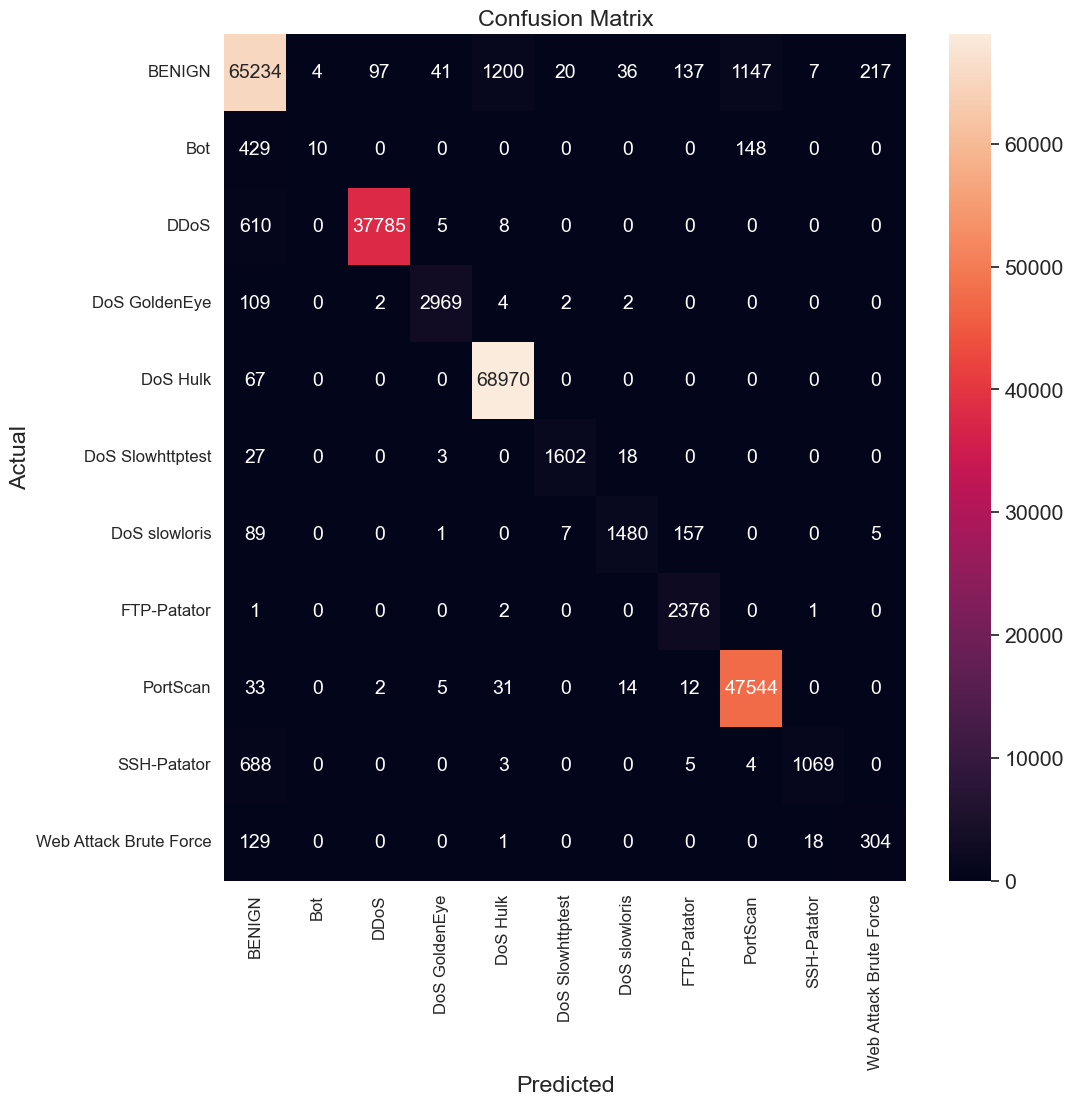

In [93]:
lbl_pred, lbl_test_ids = ids(aug_fts_train_w2, fts_test_norm, aug_lbl_train_w2, lbl_test_arr)

IDS Performance on Model 2 Config 3

In [13]:
fake_w_df_3 = pd.read_csv('aug_data_w3.csv', index_col=0)

In [84]:
# join original dataset with aug_data
aug_w3 = pd.concat([fake_w_df_3, fts_train_df], axis=0)
# shuffle the rows
aug_w3 = aug_w3.sample(frac=1, random_state=42)
aug_w3

destination_port  flow_duration  total_fwd_packets  \
819946            60556.0      1697672.0            13603.0   
367987                0.0     47633968.0                1.0   
230850            10099.0     21264593.0             1635.0   
580468            46692.0           -1.0                1.0   
1187768           20989.0     99199040.0            20822.0   
...                   ...            ...                ...   
259178            17023.0     54477055.0            25168.0   
190534               80.0        41209.0                3.0   
131932             9529.0     50714238.0           187613.0   
671155            58319.0     47791088.0            39210.0   
121958                0.0      1322423.0           160129.0   

         total_backward_packets  total_length_of_fwd_packets  \
819946                 168219.0                      52579.0   
367987                      0.0                     268781.0   
230850                      0.0                          0.0   
580468                  64196.0                     710891.0   
1187768                     0.0                          0.0   
...                         ...                          ...   
259178                  18884.0                     629718.0   
190534                      6.0                         26.0   
131932                      0.0                     278425.0   
671155                 216964.0                     533762.0   
121958                      0.0                          0.0   

         total_length_of_bwd_packets  fwd_packet_length_max  \
819946                           0.0                12098.0   
367987                    11377211.0                 6906.0   
230850                   232778294.0                 7467.0   
580468                           0.0                    0.0   
1187768                  775345945.0                    0.0   
...                              ...                    ...   
259178                    55259928.0                17124.0   
190534                       11601.0                   20.0   
131932                    92739368.0                    0.0   
671155                           0.0                 3663.0   
121958                           0.0                    0.0   

         fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
819946                     0.0                0.000000               0.000000   
367987                     0.0                0.000000               0.000000   
230850                     0.0                0.000000               0.000000   
580468                   296.0                0.000000               0.000000   
1187768                 1330.0                0.000000               0.000000   
...                        ...                     ...                    ...   
259178                     0.0                0.000000            2422.747181   
190534                     0.0                8.666667              10.263203   
131932                   601.0              256.734026            7191.123816   
671155                   598.0                0.000000               0.000000   
121958                   152.0                0.000000            6867.191924   

         ...  min_seg_size_forward   active_mean    active_std  active_max  \
819946   ...          -228479973.0  4.487301e+07  1.574163e+07         0.0   
367987   ...          -536870660.0  5.889088e+06  1.709016e+07  29876026.0   
230850   ...          -430684394.0  0.000000e+00  0.000000e+00         0.0   
580468   ...          -478101568.0  0.000000e+00  0.000000e+00  32308863.0   
1187768  ...          -137134648.0  0.000000e+00  0.000000e+00  22407533.0   
...      ...                   ...           ...           ...         ...   
259178   ...          -536870660.0  1.241002e+07  1.856374e+07         0.0   
190534   ...                  20.0  0.000000e+00  0.000000e+00         0.0   
131932   ...          -197202636.0  0.000000e+00  1

In [85]:
# make sure correct data type is being used
aug_w3 = aug_w3.astype(data.dtypes.to_dict())
aug_w3['label'] = aug_w3['label'].astype('int64')
aug_w3

destination_port  flow_duration  total_fwd_packets  \
819946              60556        1697672              13603   
367987                  0       47633968                  1   
230850              10099       21264593               1635   
580468              46692             -1                  1   
1187768             20989       99199040              20822   
...                   ...            ...                ...   
259178              17023       54477055              25168   
190534                 80          41209                  3   
131932               9529       50714238             187613   
671155              58319       47791088              39210   
121958                  0        1322423             160129   

         total_backward_packets  total_length_of_fwd_packets  \
819946                   168219                        52579   
367987                        0                       268781   
230850                        0                            0   
580468                    64196                       710891   
1187768                       0                            0   
...                         ...                          ...   
259178                    18884                       629718   
190534                        5                           26   
131932                        0                       278425   
671155                   216964                       533762   
121958                        0                            0   

         total_length_of_bwd_packets  fwd_packet_length_max  \
819946                             0                  12098   
367987                      11377211                   6906   
230850                     232778294                   7467   
580468                             0                      0   
1187768                    775345945                      0   
...                              ...                    ...   
259178                      55259928                  17124   
190534                         11601                     20   
131932                      92739368                      0   
671155                             0                   3663   
121958                             0                      0   

         fwd_packet_length_min  fwd_packet_length_mean  fwd_packet_length_std  \
819946                       0                0.000000               0.000000   
367987                       0                0.000000               0.000000   
230850                       0                0.000000               0.000000   
580468                     296                0.000000               0.000000   
1187768                   1330                0.000000               0.000000   
...                        ...                     ...                    ...   
259178                       0                0.000000            2422.747181   
190534                       0                8.666667              10.263203   
131932                     601              256.734026            7191.123816   
671155                     598                0.000000               0.000000   
121958                     152                0.000000            6867.191924   

         ...  min_seg_size_forward   active_mean    active_std  active_max  \
819946   ...            -228479973  4.487301e+07  1.574163e+07           0   
367987   ...            -536870660  5.889088e+06  1.709016e+07    29876026   
230850   ...            -430684394  0.000000e+00  0.000000e+00           0   
580468   ...            -478101568  0.000000e+00  0.000000e+00    32308863   
1187768  ...            -137134648  0.000000e+00  0.000000e+00    22407533   
...      ...                   ...           ...           ...         ...   
259178   ...            -536870660  1.241002e+07  1.856374e+07           0   
190534   ...                    19  0.000000e+00  0.000000e+00           0   
131932   ...            -197202636  0.000000e+00  1

In [86]:
# Normalise features
min_max_scalar = MinMaxScaler().fit(aug_w3.drop(columns=['label']))
aug_fts_train_w3 = min_max_scaler.transform(aug_w3.drop(columns=['label']))
aug_fts_train_w3

array([[0.92406763, 0.01414728, 0.06775457, ..., 0.40270388, 0.        ,
        0.40458158],
       [0.        , 0.39694976, 0.        , ..., 0.30616373, 0.25054747,
        0.        ],
       [0.15410792, 0.17720496, 0.00813931, ..., 0.12292048, 0.13961504,
        0.01426261],
       ...,
       [0.14540988, 0.42261868, 0.9345368 , ..., 0.        , 0.74752408,
        0.        ],
       [0.88993164, 0.3982591 , 0.19530869, ..., 0.        , 0.        ,
        0.12715688],
       [0.        , 0.0110202 , 0.79763292, ..., 0.        , 0.72357511,
        0.        ]])

In [87]:
aug_lbl_train_w3 = aug_w3['label'].values

Epoch 1/10
3544/3544 [==============================] - 74s 20ms/step - loss: 0.1708 - accuracy: 0.9555
Epoch 2/10
3544/3544 [==============================] - 90s 25ms/step - loss: 0.0609 - accuracy: 0.9813
Epoch 3/10
3544/3544 [==============================] - 89s 25ms/step - loss: 0.0452 - accuracy: 0.9858
Epoch 4/10
3544/3544 [==============================] - 85s 24ms/step - loss: 0.0382 - accuracy: 0.9875
Epoch 5/10
3544/3544 [==============================] - 85s 24ms/step - loss: 0.0342 - accuracy: 0.9889
Epoch 6/10
3544/3544 [==============================] - 70s 20ms/step - loss: 0.0312 - accuracy: 0.9898
Epoch 7/10
3544/3544 [==============================] - 66s 19ms/step - loss: 0.0289 - accuracy: 0.9906
Epoch 8/10
3544/3544 [==============================] - 54s 15ms/step - loss: 0.0269 - accuracy: 0.9916
Epoch 9/10
3544/3544 [==============================] - 67s 19ms/step - loss: 0.0253 - accuracy: 0.9923
Epoch 10/10
3544/3544 [==============================] - 78s 22m

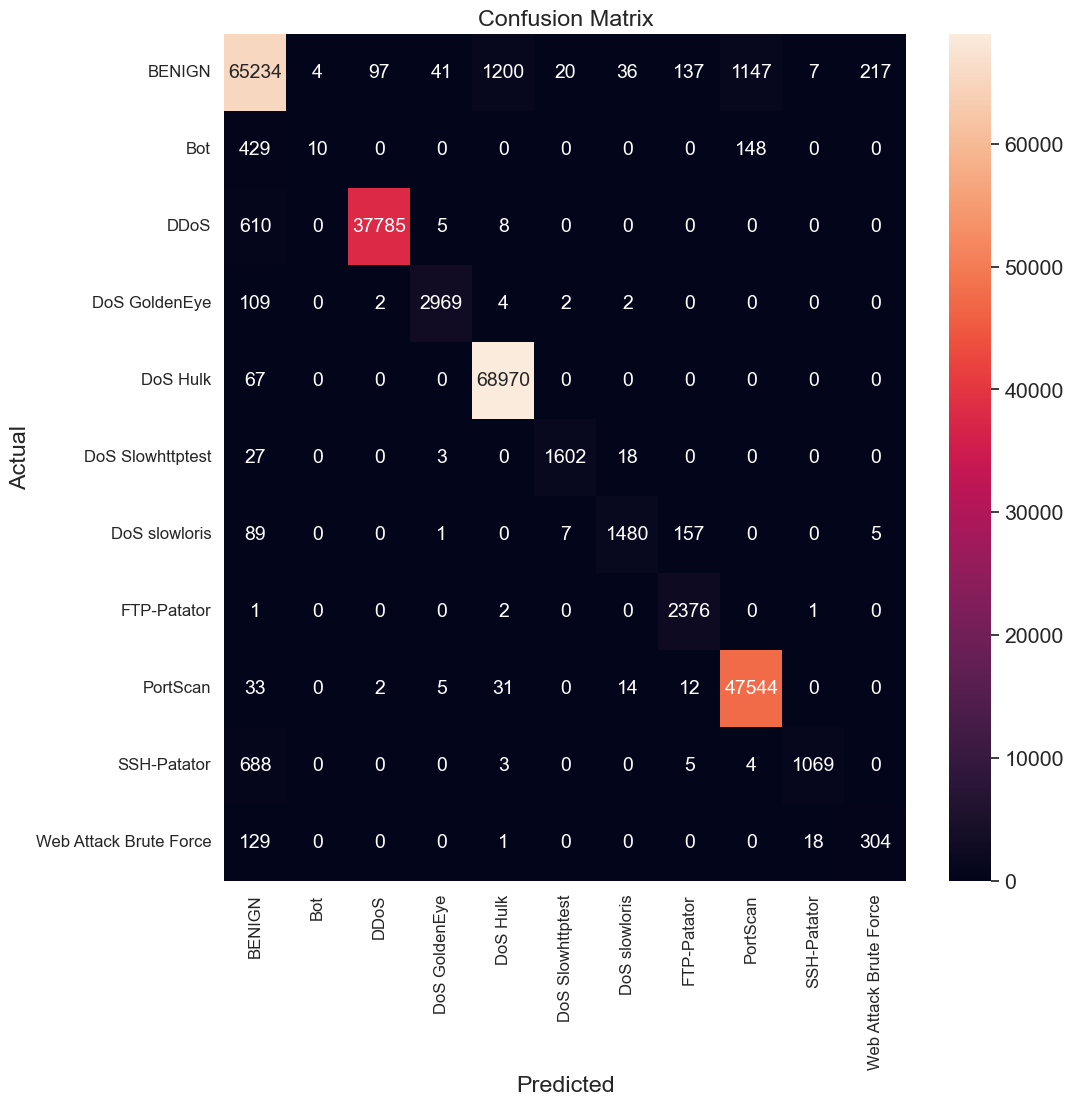

In [93]:
lbl_pred, lbl_test_ids = ids(aug_fts_train_w3, fts_test_norm, aug_lbl_train_w3, lbl_test_arr)

Statistical Analysis on Real and Synthetic Data

In [55]:
def variance(data):
    var = dict()
    for c in range(data.shape[1]):
        # Calculate the mean for each column
        mean = np.mean(data.iloc[:, c])

        # Calculate the variance
        variance = np.sum((data.iloc[:, c] - mean)**2) / (len(data.iloc[:, c]) - 1)

        var[data.columns[c]] = round(variance, 2)
        
    return var


In [56]:
var = variance(fts_train_df)

In [57]:
var = pd.DataFrame([var], columns=var.keys(), index=[0])
for c in var.columns:
    print(f'{c} variance = {var[c][0]}')


destination_port variance = 171138802.12
flow_duration variance = 1602995556394316.5
total_fwd_packets variance = 178053.62
total_backward_packets variance = 318954.92
total_length_of_fwd_packets variance = 10949323.94
total_length_of_bwd_packets variance = 1542446738151.59
fwd_packet_length_max variance = 214394.72
fwd_packet_length_min variance = 2627.9
fwd_packet_length_mean variance = 15630.49
fwd_packet_length_std variance = 31845.07
bwd_packet_length_max variance = 9836378.23
bwd_packet_length_min variance = 2253.86
bwd_packet_length_mean variance = 914223.33
bwd_packet_length_std variance = 1924601.13
flow_bytes/s variance = 375173373273532.75
flow_packets/s variance = 83950068782.79
flow_iat_mean variance = 27370188777127.41
flow_iat_std variance = 126885341579757.8
flow_iat_max variance = 1401999357572961.8
flow_iat_min variance = 12189493307009.95
fwd_iat_total variance = 1603308268476837.5
fwd_iat_mean variance = 97304876149721.95
fwd_iat_std variance = 240384826399702.9
fwd

In [52]:
from scipy.stats import skew

def skewness(data):
    skewy = dict()
    for c in range(data.shape[1]):
        skewness = skew(data.iloc[:, c])
        
        skewy[data.columns[c]] = round(skewness, 2)
    
    return skewy

In [53]:
skewy = skewness(fts_train_df)

In [54]:
skewy = pd.DataFrame([skewy], columns=skewy.keys(), index=[0])
for c in skewy.columns:
    print(f'{c} skew = {skewy[c][0]}')


destination_port skew = 3.3
flow_duration skew = 1.22
total_fwd_packets skew = 426.27
total_backward_packets skew = 426.89
total_length_of_fwd_packets skew = 188.95
total_length_of_bwd_packets skew = 426.53
fwd_packet_length_max skew = 15.39
fwd_packet_length_min skew = 28.61
fwd_packet_length_mean skew = 14.45
fwd_packet_length_std skew = 15.33
bwd_packet_length_max skew = 1.24
bwd_packet_length_min skew = 9.14
bwd_packet_length_mean skew = 0.94
bwd_packet_length_std skew = 1.48
flow_bytes/s skew = 63.63
flow_packets/s skew = 5.03
flow_iat_mean skew = 7.9
flow_iat_std skew = 1.62
flow_iat_max skew = 1.36
flow_iat_min skew = 23.03
fwd_iat_total skew = 1.23
fwd_iat_mean skew = 5.07
fwd_iat_std skew = 1.52
fwd_iat_max skew = 1.36
fwd_iat_min skew = 12.08
bwd_iat_total skew = 2.91
bwd_iat_mean skew = 7.98
bwd_iat_std skew = 3.76
bwd_iat_max skew = 3.35
bwd_iat_min skew = 13.44
fwd_psh_flags skew = 6.15
fwd_urg_flags skew = 157.83
fwd_header_length skew = -740.28
bwd_header_length skew = -

In [62]:
from scipy.stats import kurtosis

def kurto(data):
    kurt = dict()
    for c in range(data.shape[1]):
        k = kurtosis(data.iloc[:, c])
        
        kurt[data.columns[c]] = round(k, 2)
    
    return kurt


In [63]:
k = kurto(fts_train_df)

In [64]:
k = pd.DataFrame([k], columns=k.keys(), index=[0])
for c in k.columns:
    print(f'{c} skew = {k[c][0]}')

destination_port skew = 9.67
flow_duration skew = -0.35
total_fwd_packets skew = 186551.45
total_backward_packets skew = 187261.43
total_length_of_fwd_packets skew = 57239.25
total_length_of_bwd_packets skew = 186540.94
fwd_packet_length_max skew = 371.43
fwd_packet_length_min skew = 940.22
fwd_packet_length_mean skew = 274.76
fwd_packet_length_std skew = 326.69
bwd_packet_length_max skew = 0.35
bwd_packet_length_min skew = 219.44
bwd_packet_length_mean skew = -0.77
bwd_packet_length_std skew = 1.45
flow_bytes/s skew = 5213.82
flow_packets/s skew = 28.27
flow_iat_mean skew = 113.87
flow_iat_std skew = 1.87
flow_iat_max skew = -0.03
flow_iat_min skew = 588.82
fwd_iat_total skew = -0.34
fwd_iat_mean skew = 41.41
fwd_iat_std skew = 0.65
fwd_iat_max skew = -0.03
fwd_iat_min skew = 153.87
bwd_iat_total skew = 6.79
bwd_iat_mean skew = 82.99
bwd_iat_std skew = 13.7
bwd_iat_max skew = 9.61
bwd_iat_min skew = 195.45
fwd_psh_flags skew = 35.77
fwd_urg_flags skew = 24907.59
fwd_header_length skew

In [58]:
from sklearn.metrics import mean_squared_error

def pMSE(real_data, synthetic_data):
    
    pMSEs = dict()
    for col in range(real_data.shape[1]):
        pMSE = ((real_data.iloc[:, col] - synthetic_data.iloc[:, col]) / (real_data.iloc[:, col] + synthetic_data.iloc[:, col])).pow(2).sum() / real_data.shape[0]
        pMSEs[real_data.columns[col]] = round(pMSE, 2)
    
    return pMSEs


In [59]:
pmse_score_1 = pMSE(fts_train_df, fake_data_df)
pmse_score_1 = pd.DataFrame([pmse_score_1], columns=pmse_score_1.keys(), index=[0])
# print(pmse_score_1)

pmse_score_2 = pMSE(fts_train_df, fake_w_df)
pmse_score_2 = pd.DataFrame([pmse_score_2], columns=pmse_score_2.keys(), index=[0])
# print(pmse_score_2)

In [60]:
for c in pmse_score_1.columns:
    print(f'{c} pMSE = {pmse_score_1[c][0]}')

destination_port pMSE = 0.69
flow_duration pMSE = 0.78
total_fwd_packets pMSE = 0.4
total_backward_packets pMSE = 0.66
total_length_of_fwd_packets pMSE = 0.57
total_length_of_bwd_packets pMSE = 0.76
fwd_packet_length_max pMSE = 0.64
fwd_packet_length_min pMSE = 0.39
fwd_packet_length_mean pMSE = 0.58
fwd_packet_length_std pMSE = 0.78
bwd_packet_length_max pMSE = 0.76
bwd_packet_length_min pMSE = 0.37
bwd_packet_length_mean pMSE = 0.77
bwd_packet_length_std pMSE = 0.87
flow_bytes/s pMSE = 592767641693537.5
flow_packets/s pMSE = 4443.73
flow_iat_mean pMSE = 4111564932.58
flow_iat_std pMSE = 0.8
flow_iat_max pMSE = 0.79
flow_iat_min pMSE = inf
fwd_iat_total pMSE = 0.83
fwd_iat_mean pMSE = 0.82
fwd_iat_std pMSE = 0.84
fwd_iat_max pMSE = 0.83
fwd_iat_min pMSE = inf
bwd_iat_total pMSE = 0.85
bwd_iat_mean pMSE = 0.86
bwd_iat_std pMSE = 0.88
bwd_iat_max pMSE = 0.84
bwd_iat_min pMSE = 0.96
fwd_psh_flags pMSE = 0.03
fwd_urg_flags pMSE = 0.0
fwd_header_length pMSE = 1.0
bwd_header_length pMSE = 1

In [61]:
for c in pmse_score_2.columns:
    print(f'{c} pMSE = {pmse_score_2[c][0]}')

destination_port pMSE = inf
flow_duration pMSE = 511928.85
total_fwd_packets pMSE = 1.0
total_backward_packets pMSE = 1.0
total_length_of_fwd_packets pMSE = 1.01
total_length_of_bwd_packets pMSE = 1.0
fwd_packet_length_max pMSE = inf
fwd_packet_length_min pMSE = inf
fwd_packet_length_mean pMSE = 38.09
fwd_packet_length_std pMSE = 52.58
bwd_packet_length_max pMSE = inf
bwd_packet_length_min pMSE = inf
bwd_packet_length_mean pMSE = 40802.98
bwd_packet_length_std pMSE = 76878.54
flow_bytes/s pMSE = 1.2
flow_packets/s pMSE = 1421.29
flow_iat_mean pMSE = 6850.51
flow_iat_std pMSE = 134894.2
flow_iat_max pMSE = 25542.31
flow_iat_min pMSE = 96.21
fwd_iat_total pMSE = 127003.53
fwd_iat_mean pMSE = 46357.36
fwd_iat_std pMSE = 2411890.75
fwd_iat_max pMSE = 4781164.17
fwd_iat_min pMSE = 7.91
bwd_iat_total pMSE = 65663.47
bwd_iat_mean pMSE = 8053.8
bwd_iat_std pMSE = 14650.79
bwd_iat_max pMSE = 4266.73
bwd_iat_min pMSE = 73.56
fwd_psh_flags pMSE = 0.02
fwd_urg_flags pMSE = 0.0
fwd_header_length pM

In [94]:
pmse_score_3 = pMSE(fts_train_df, fake_w_df_3)
pmse_score_3 = pd.DataFrame([pmse_score_3], columns=pmse_score_3.keys(), index=[0])

In [95]:
for c in pmse_score_3.columns:
    print(f'{c} pMSE = {pmse_score_3[c][0]}')

destination_port pMSE = 0.86
flow_duration pMSE = inf
total_fwd_packets pMSE = 0.66
total_backward_packets pMSE = 0.92
total_length_of_fwd_packets pMSE = 0.92
total_length_of_bwd_packets pMSE = 0.95
fwd_packet_length_max pMSE = 0.8
fwd_packet_length_min pMSE = 0.56
fwd_packet_length_mean pMSE = 0.82
fwd_packet_length_std pMSE = 0.71
bwd_packet_length_max pMSE = 0.72
bwd_packet_length_min pMSE = 0.56
bwd_packet_length_mean pMSE = 0.7
bwd_packet_length_std pMSE = 0.49
flow_bytes/s pMSE = inf
flow_packets/s pMSE = inf
flow_iat_mean pMSE = inf
flow_iat_std pMSE = 0.69
flow_iat_max pMSE = inf
flow_iat_min pMSE = inf
fwd_iat_total pMSE = 0.74
fwd_iat_mean pMSE = 0.75
fwd_iat_std pMSE = 0.67
fwd_iat_max pMSE = 0.75
fwd_iat_min pMSE = inf
bwd_iat_total pMSE = 0.65
bwd_iat_mean pMSE = 0.8
bwd_iat_std pMSE = 0.61
bwd_iat_max pMSE = 0.71
bwd_iat_min pMSE = 0.79
fwd_psh_flags pMSE = 0.02
fwd_urg_flags pMSE = 0.02
fwd_header_length pMSE = 1.0
bwd_header_length pMSE = 1.0
fwd_packets/s pMSE = 0.95
b

Cluster Anaylsis on Real and Synthetic Data

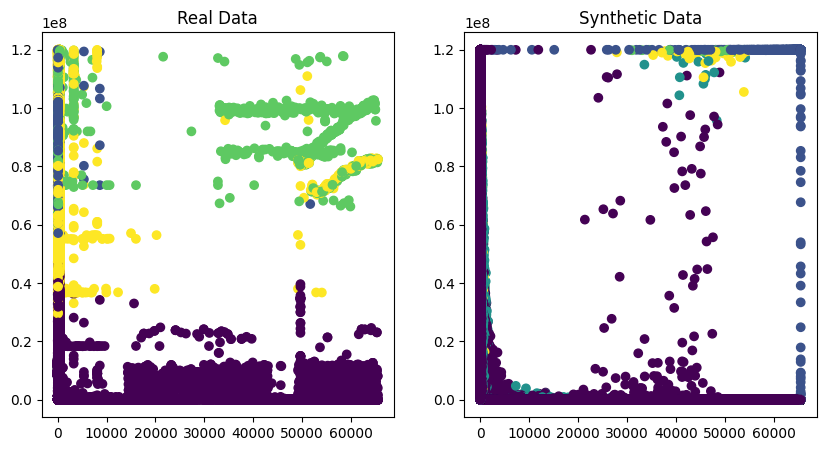

In [14]:
from sklearn.cluster import KMeans

# # generate some sample data
# real_data = pd.read_csv('real_data.csv')
# synthetic_data = pd.read_csv('synthetic_data.csv')

# extract the feature data from the real and synthetic data
real_features = fts_train_df.drop(columns=['label']).values
synthetic_features = fake_data_df.drop(columns=['label']).values

# perform clustering analysis on the real data
kmeans_real = KMeans(n_clusters=5, random_state=0).fit(real_features)
real_labels = kmeans_real.labels_

# perform clustering analysis on the synthetic data
kmeans_synthetic = KMeans(n_clusters=5, random_state=0).fit(synthetic_features)
synthetic_labels = kmeans_synthetic.labels_

# visualize the clustering results for real and synthetic data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(real_features[:, 0], real_features[:, 1], c=real_labels)
axs[0].set_title('Real Data')
axs[1].scatter(synthetic_features[:, 0], synthetic_features[:, 1], c=synthetic_labels)
axs[1].set_title('Synthetic Data')
plt.show()


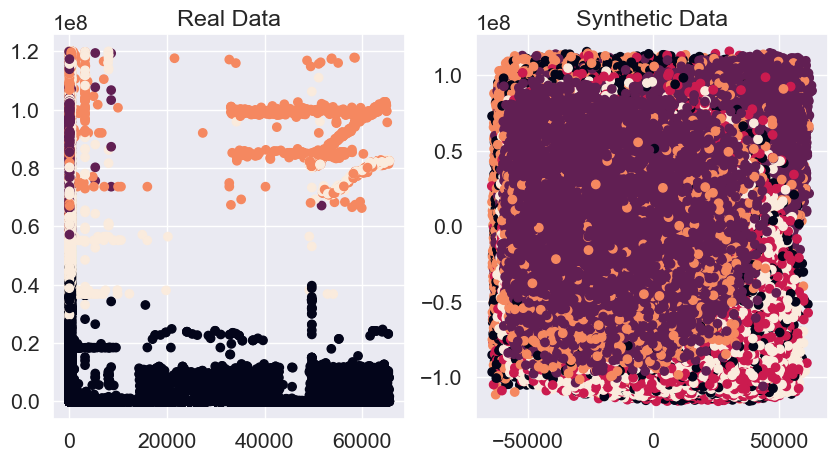

In [96]:
# from sklearn.cluster import KMeans

# # generate some sample data
# real_data = pd.read_csv('real_data.csv')
# synthetic_data = pd.read_csv('synthetic_data.csv')

# extract the feature data from the real and synthetic data
real_features = fts_train_df.drop(columns=['label']).values
synthetic_features = fake_w_df.drop(columns=['label']).values

# perform clustering analysis on the real data
kmeans_real = KMeans(n_clusters=5, random_state=0).fit(real_features)
real_labels = kmeans_real.labels_

# perform clustering analysis on the synthetic data
kmeans_synthetic = KMeans(n_clusters=5, random_state=0).fit(synthetic_features)
synthetic_labels = kmeans_synthetic.labels_

# visualize the clustering results for real and synthetic data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(real_features[:, 0], real_features[:, 1], c=real_labels)
axs[0].set_title('Real Data')
axs[1].scatter(synthetic_features[:, 0], synthetic_features[:, 1], c=synthetic_labels)
axs[1].set_title('Synthetic Data')
plt.show()


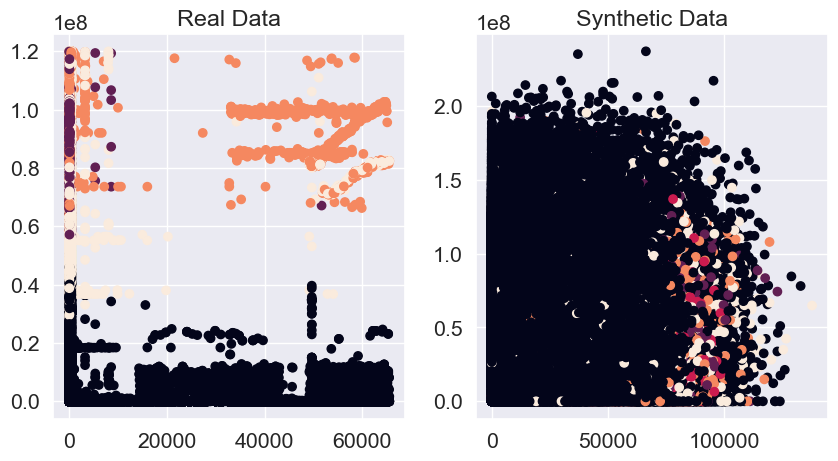

In [97]:
# from sklearn.cluster import KMeans

# # generate some sample data
# real_data = pd.read_csv('real_data.csv')
# synthetic_data = pd.read_csv('synthetic_data.csv')

# extract the feature data from the real and synthetic data
real_features = fts_train_df.drop(columns=['label']).values
synthetic_features = fake_w_df_2.drop(columns=['label']).values

# perform clustering analysis on the real data
kmeans_real = KMeans(n_clusters=5, random_state=0).fit(real_features)
real_labels = kmeans_real.labels_

# perform clustering analysis on the synthetic data
kmeans_synthetic = KMeans(n_clusters=5, random_state=0).fit(synthetic_features)
synthetic_labels = kmeans_synthetic.labels_

# visualize the clustering results for real and synthetic data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(real_features[:, 0], real_features[:, 1], c=real_labels)
axs[0].set_title('Real Data')
axs[1].scatter(synthetic_features[:, 0], synthetic_features[:, 1], c=synthetic_labels)
axs[1].set_title('Synthetic Data')
plt.show()


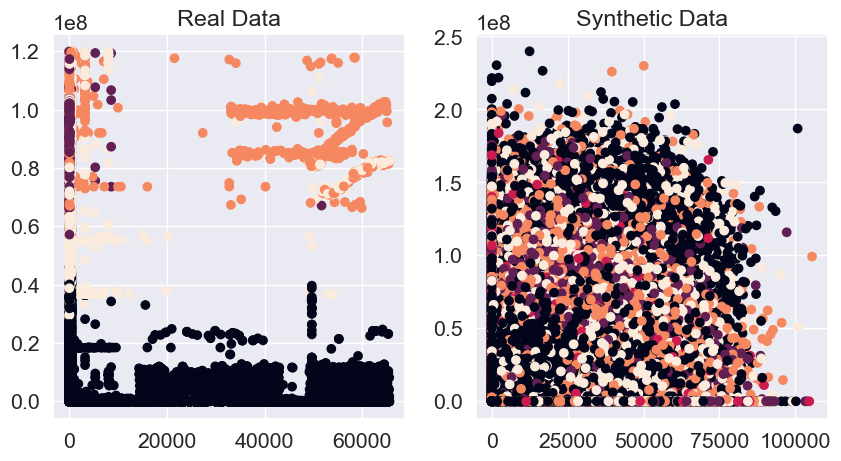

In [101]:
# from sklearn.cluster import KMeans

# # generate some sample data
# real_data = pd.read_csv('real_data.csv')
# synthetic_data = pd.read_csv('synthetic_data.csv')

# extract the feature data from the real and synthetic data
real_features = fts_train_df.drop(columns=['label']).values
synthetic_features = fake_w_df_3.drop(columns=['label']).values

# perform clustering analysis on the real data
kmeans_real = KMeans(n_clusters=5, random_state=0).fit(real_features)
real_labels = kmeans_real.labels_

# perform clustering analysis on the synthetic data
kmeans_synthetic = KMeans(n_clusters=5, random_state=0).fit(synthetic_features)
synthetic_labels = kmeans_synthetic.labels_

# visualize the clustering results for real and synthetic data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(real_features[:, 0], real_features[:, 1], c=real_labels)
axs[0].set_title('Real Data')
axs[1].scatter(synthetic_features[:, 0], synthetic_features[:, 1], c=synthetic_labels)
axs[1].set_title('Synthetic Data')
plt.show()


In [ ]:
from scipy.stats import ks_2samp, jensenshannon, wasserstein_distance

# Fit clustering algorithm to real and synthetic data
# ...

# Assign clusters to test set
# ...

# Compute KS distance for each cluster
ks_distances = {}
for cluster in range(n_clusters=5):
    real_data = test_real_data[test_real_labels == cluster]
    synthetic_data = test_synthetic_data[test_synthetic_labels == cluster]
    ks_distance, _ = ks_2samp(real_data, synthetic_data)
    ks_distances[cluster] = ks_distance

# jensenshannon
# wasserstein_distance